# Algorithmic Trading Testing Phase

## Phase 1: Data Pipeline (Data Acquisition)
Fetching and cleaning Binance, On-Chain, and Macro data.

In [1]:
import ccxt
import pandas as pd
import pandas_ta as ta
import yfinance as yf
import os
from datetime import datetime
import numpy as np
import requests
from scipy.signal import argrelextrema

# Configuration
DATA_DIR = "data"
TIMEFRAMES = ['1h', '4h', '1d']
PAIRS = ['BTC/USDT', 'ETH/USDT']
START_DATE = "2022-01-01 00:00:00"
YF_START_DATE = "2022-01-01"
# End date is effectively "now"

In [2]:
def fetch_binance_data(symbol, timeframe, start_date):
    """
    Fetches historical OHLCV data from Binance.
    """
    print(f"Fetching {symbol} {timeframe} data from Binance...")
    exchange = ccxt.binance()
    
    # Convert start_date to timestamp
    since = exchange.parse8601(start_date)
    
    all_ohlcv = []
    limit = 1000
    
    while True:
        try:
            ohlcv = exchange.fetch_ohlcv(symbol, timeframe, since, limit)
            if not ohlcv:
                break
            
            all_ohlcv.extend(ohlcv)
            since = ohlcv[-1][0] + 1  # Move to next timestamp
            
            # Break if we reached current time (approx) - fetch_ohlcv handles this but good to be safe
            if len(ohlcv) < limit:
                break
                
        except Exception as e:
            print(f"Error fetching data: {e}")
            break
            
    df = pd.DataFrame(all_ohlcv, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
    df.set_index('timestamp', inplace=True)
    
    # Clean data
    df = df[~df.index.duplicated(keep='first')]
    df.dropna(inplace=True)
    
    return df

In [3]:
def fetch_macro_data(start_date):
    """
    Fetches Macro data (DXY) using yfinance.
    """
    print("Fetching Macro data (DXY)...")
    # DXY symbol on Yahoo Finance is 'DX-Y.NYB' or similar. 'DX-Y.NYB' is often used.
    # Alternatively 'UUP' (ETF) or 'DX=F' (Futures). Let's try 'DX-Y.NYB'.
    ticker = 'DX-Y.NYB' 
    
    try:
        df = yf.download(ticker, start=start_date, progress=False)
        if df.empty:
             # Fallback if the above symbol doesn't work well
             print("Primary DXY symbol failed, trying 'DX=F'")
             df = yf.download('DX=F', start=start_date, progress=False)
             
        # yfinance returns MultiIndex columns sometimes, flatten if needed
        if isinstance(df.columns, pd.MultiIndex):
            df.columns = df.columns.get_level_values(0)
            
        # Rename Close to DXY_Close for clarity
        if 'Close' in df.columns:
            df = df[['Close']].rename(columns={'Close': 'DXY'})
        else:
             print("Warning: 'Close' column not found in macro data. Columns:", df.columns)
             return pd.DataFrame()

        return df
    except Exception as e:
        print(f"Error fetching macro data: {e}")
        return pd.DataFrame()

In [4]:
def save_data(df, filename):
    if not os.path.exists(DATA_DIR):
        os.makedirs(DATA_DIR)
    path = os.path.join(DATA_DIR, filename)
    df.to_csv(path)
    print(f"Saved {filename} to {path}")

In [5]:
## Extended Data Fetching: Macro + On-Chain
import yaml
from dotenv import load_dotenv
import warnings
warnings.filterwarnings('ignore')

# Load configuration
with open('config.yaml', 'r') as f:
    config = yaml.safe_load(f)

# Load environment variables
load_dotenv()

print("Configuration loaded successfully")
print(f"On-chain enabled: {config['data']['onchain']['enabled']}")
print(f"Macro enabled: {config['data']['macro']['enabled']}")


Configuration loaded successfully
On-chain enabled: True
Macro enabled: True


In [6]:
def fetch_fred_data(series_id, start_date, api_key=None):
    """
    Fetches macroeconomic data from FRED (Federal Reserve Economic Data)
    
    Args:
        series_id: FRED series ID (e.g., 'CPIAUCSL' for CPI)
        start_date: Start date in YYYY-MM-DD format
        api_key: FRED API key (optional if set in environment)
    
    Returns:
        DataFrame with the requested series
    """
    try:
        from fredapi import Fred
        
        if api_key is None:
            api_key = os.getenv('FRED_API_KEY')
        
        if api_key is None or api_key == 'your_fred_api_key_here':
            print(f"⚠️  FRED API key not set. Using mock data for {series_id}")
            # Return mock data with similar structure
            dates = pd.date_range(start=start_date, end=datetime.now(), freq='D')
            mock_data = pd.DataFrame({
                series_id: np.random.randn(len(dates)).cumsum() + 100
            }, index=dates)
            return mock_data
        
        fred = Fred(api_key=api_key)
        data = fred.get_series(series_id, observation_start=start_date)
        df = pd.DataFrame({series_id: data})
        
        print(f"✅ Fetched {series_id}: {len(df)} records from {df.index.min()} to {df.index.max()}")
        return df
        
    except Exception as e:
        print(f"❌ Error fetching {series_id}: {e}")
        # Return empty DataFrame
        return pd.DataFrame()

def fetch_all_macro_data(start_date=YF_START_DATE):
    """
    Fetches all configured macro indicators from FRED
    """
    print("\n" + "="*70)
    print("FETCHING MACROECONOMIC DATA FROM FRED")
    print("="*70)
    
    macro_indicators = config['data']['macro']['indicators']
    
    # FRED series ID mapping
    fred_series = {
        'DXY': None,  # Already fetched via yfinance
        'US10Y': 'DGS10',  # 10-Year Treasury Constant Maturity Rate
        'CPI': 'CPIAUCSL',  # Consumer Price Index
        'PCE': 'PCEPI',  # Personal Consumption Expenditures Price Index
        'UNRATE': 'UNRATE',  # Unemployment Rate
        'PAYEMS': 'PAYEMS',  # Non-farm Payroll Employment
        'FEDFUNDS': 'FEDFUNDS'  # Federal Funds Effective Rate
    }
    
    macro_data = {}
    
    for indicator in macro_indicators:
        if indicator == 'DXY':
            continue  # Skip DXY, already have it
        
        series_id = fred_series.get(indicator)
        if series_id:
            df = fetch_fred_data(series_id, start_date)
            if not df.empty:
                macro_data[indicator] = df
    
    return macro_data


In [7]:
def fetch_onchain_data_coinmetrics(asset, metric, start_date):
    """
    Fetches on-chain metrics from CoinMetrics Community API (FREE)
    
    Args:
        asset: Asset symbol ('BTC', 'ETH')
        metric: Metric name
        start_date: Start date
    
    Returns:
        DataFrame with the metric data
    """
    try:
        # CoinMetrics community API (no key required)
        base_url = 'https://community-api.coinmetrics.io/v4'
        
        # Metric mapping
        metric_map = {
            'NVT': 'NVTAdj',  # Network Value to Transactions ratio
            'MVRV': 'CapMVRVCur',  # Market Value to Realized Value
            'active_addresses': 'AdrActCnt',
            'transaction_count': 'TxCnt'
        }
        
        cm_metric = metric_map.get(metric)
        if not cm_metric:
            print(f"⚠️  Metric {metric} not available in CoinMetrics, using calculated proxy")
            return pd.DataFrame()
        
        # Format asset for CoinMetrics
        cm_asset = asset.lower()
        
        # Build API request
        url = f'{base_url}/timeseries/asset-metrics'
        params = {
            'assets': cm_asset,
            'metrics': cm_metric,
            'start_time': start_date,
            'frequency': '1d'
        }
        
        response = requests.get(url, params=params)
        response.raise_for_status()
        
        data = response.json()['data']
        
        if not data:
            print(f"⚠️  No data from CoinMetrics for {asset} {metric}")
            return pd.DataFrame()
        
        # Parse response
        df = pd.DataFrame(data)
        df['time'] = pd.to_datetime(df['time'])
        df = df.set_index('time')
        df = df[[cm_metric]].rename(columns={cm_metric: f'{asset}_{metric}'})
        
        print(f"✅ Fetched {asset} {metric} from CoinMetrics: {len(df)} records")
        return df
        
    except Exception as e:
        print(f"⚠️  CoinMetrics error for {asset} {metric}: {e}")
        print(f"   Will use calculated proxy instead")
        return pd.DataFrame()

def calculate_onchain_proxies(price_df, asset):
    """
    Calculate on-chain proxy metrics from price/volume data
    
    Args:
        price_df: DataFrame with OHLCV data
        asset: Asset symbol
    
    Returns:
        DataFrame with calculated on-chain proxies
    """
    df = price_df.copy()
    
    # NVT Proxy: Market Cap / Volume ratio (inverted so lower = better like real NVT)
    df['market_cap_proxy'] = df['close'] * df['volume']
    df[f'{asset}_NVT_proxy'] = df['market_cap_proxy'] / (df['volume'] * df['close'] + 1)
    df[f'{asset}_NVT_proxy'] = df[f'{asset}_NVT_proxy'].rolling(window=14).mean()
    
    # MVRV Proxy: Price / Moving Average ratio (simplified MVRV concept)
    df[f'{asset}_MVRV_proxy'] = df['close'] / df['close'].rolling(window=200).mean()
    
    # Exchange Flow Proxy: Volume momentum (high volume = potential exchange activity)
    df['volume_ma'] = df['volume'].rolling(window=20).mean()
    df[f'{asset}_exchange_flow_proxy'] = df['volume'] / (df['volume_ma'] + 1)
    
    # HODL Proxy: Price stability score (low volatility = HODLing)
    df['returns'] = df['close'].pct_change()
    df['volatility_30d'] = df['returns'].rolling(window=30).std()
    df[f'{asset}_hodl_proxy'] = 1 / (df['volatility_30d'] + 0.001)  # Inverse of volatility
    
    # Clean up temporary columns
    result_cols = [col for col in df.columns if '_proxy' in col or metric.upper() in col for metric in ['NVT', 'MVRV']]
    
    print(f"✅ Calculated {len(result_cols)} on-chain proxies for {asset}")
    
    return df[result_cols] if result_cols else df

# Glassnode removed - using CoinMetrics (free) + calculated proxies instead

def fetch_all_onchain_data(start_date=START_DATE, use_proxies=True):
    """
    Fetches all configured on-chain metrics for BTC and ETH
    
    Strategy:
    1. Try CoinMetrics Community API (free, no key)
    2. If fails, calculate proxies from price/volume data
    3. Glassnode only if API key is available
    
    Args:
        start_date: Start date for data
        use_proxies: If True, calculate proxies for missing metrics
    
    Returns:
        Dict of DataFrames with on-chain metrics
    """
    print("\n" + "="*70)
    print("FETCHING ON-CHAIN DATA (Multi-Source Strategy)")
    print("="*70)
    
    assets = ['BTC', 'ETH']
    metrics = config['data']['onchain']['metrics']
    
    onchain_data = {}
    
    for asset in assets:
        print(f"\n📊 Processing {asset}...")
        
        for metric in metrics:
            # Try CoinMetrics Community API (FREE, no key required)
            df = fetch_onchain_data_coinmetrics(asset, metric, start_date)
            
            # Store if we got data
            if not df.empty:
                key = f'{asset}_{metric}'
                onchain_data[key] = df
            else:
                print(f"   ⚠️  {metric} will be calculated as proxy from price data")
    
    # 4. If use_proxies enabled, we'll calculate them later from price data
    if use_proxies:
        print("\n💡 Note: Missing on-chain metrics will be calculated as proxies from price/volume data")
    
    return onchain_data


In [8]:
def align_and_merge_data(price_df, macro_data, onchain_data, timeframe='1d'):
    """
    Aligns and merges price, macro, and on-chain data
    
    Handles:
    - Timezone conversions (UTC standardization)
    - Frequency resampling (daily → intraday with forward fill)
    - Missing value handling
    
    Args:
        price_df: Price OHLCV data
        macro_data: Dict of macro DataFrames
        onchain_data: Dict of on-chain DataFrames
        timeframe: Target timeframe ('1h', '4h', '1d')
    
    Returns:
        Merged DataFrame with all features aligned
    """
    print(f"\n🔄 Aligning data for {timeframe} timeframe...")
    
    # Ensure price_df index is timezone-aware (UTC)
    if price_df.index.tz is None:
        price_df.index = price_df.index.tz_localize('UTC')
    else:
        price_df.index = price_df.index.tz_convert('UTC')
    
    result_df = price_df.copy()
    
    # Merge macro data (typically daily)
    for name, macro_df in macro_data.items():
        if macro_df.empty:
            continue
        
        # Ensure timezone awareness
        if macro_df.index.tz is None:
            macro_df.index = macro_df.index.tz_localize('UTC')
        else:
            macro_df.index = macro_df.index.tz_convert('UTC')
        
        # Resample to target frequency with forward fill
        if timeframe in ['1h', '4h']:
            # For intraday, resample daily data to hourly then select
            macro_resampled = macro_df.resample('1H').ffill()
            result_df = result_df.join(macro_resampled, how='left')
        else:
            # For daily, direct join
            result_df = result_df.join(macro_df, how='left')
        
        # Forward fill remaining NaNs
        result_df[macro_df.columns] = result_df[macro_df.columns].ffill()
        
        print(f"  ✅ Merged {name}: {result_df[macro_df.columns[0]].notna().sum()} non-null values")
    
    # Merge on-chain data (typically daily)
    for name, onchain_df in onchain_data.items():
        if onchain_df.empty:
            continue
        
        # Ensure timezone awareness
        if onchain_df.index.tz is None:
            onchain_df.index = onchain_df.index.tz_localize('UTC')
        else:
            onchain_df.index = onchain_df.index.tz_convert('UTC')
        
        # Resample to target frequency with forward fill
        if timeframe in ['1h', '4h']:
            onchain_resampled = onchain_df.resample('1H').ffill()
            result_df = result_df.join(onchain_resampled, how='left')
        else:
            result_df = result_df.join(onchain_df, how='left')
        
        # Forward fill remaining NaNs
        result_df[onchain_df.columns] = result_df[onchain_df.columns].ffill()
        
        print(f"  ✅ Merged {name}: {result_df[onchain_df.columns[0]].notna().sum()} non-null values")
    
    # Fill any remaining NaNs at the start with backward fill (limited)
    result_df = result_df.fillna(method='bfill', limit=10)
    
    print(f"✅ Final merged data: {len(result_df)} rows, {len(result_df.columns)} columns")
    print(f"   NaN counts: {result_df.isna().sum().sum()} total")
    
    return result_df


In [9]:
# Execution Block - Phase 1
if __name__ == "__main__":
    # Ensure data directory exists
    if not os.path.exists(DATA_DIR):
        os.makedirs(DATA_DIR)

    # Fetch Crypto Data
    for pair in PAIRS:
        symbol_clean = pair.replace('/', '')
        for tf in TIMEFRAMES:
            df = fetch_binance_data(pair, tf, START_DATE)
            filename = f"{symbol_clean}_{tf}.csv"
            save_data(df, filename)
            
    # Fetch Macro Data
    # Macro data is usually daily. We might need to forward fill for intraday timeframes later.
    macro_df = fetch_macro_data(YF_START_DATE)
    if not macro_df.empty:
        save_data(macro_df, "macro_dxy.csv")
    else:
        print("Failed to fetch Macro data.")
    
    print("Data acquisition complete.")

Fetching BTC/USDT 1h data from Binance...
Saved BTCUSDT_1h.csv to data\BTCUSDT_1h.csv
Fetching BTC/USDT 4h data from Binance...
Saved BTCUSDT_4h.csv to data\BTCUSDT_4h.csv
Fetching BTC/USDT 1d data from Binance...
Saved BTCUSDT_1d.csv to data\BTCUSDT_1d.csv
Fetching ETH/USDT 1h data from Binance...
Saved ETHUSDT_1h.csv to data\ETHUSDT_1h.csv
Fetching ETH/USDT 4h data from Binance...
Saved ETHUSDT_4h.csv to data\ETHUSDT_4h.csv
Fetching ETH/USDT 1d data from Binance...
Saved ETHUSDT_1d.csv to data\ETHUSDT_1d.csv
Fetching Macro data (DXY)...
Saved macro_dxy.csv to data\macro_dxy.csv
Data acquisition complete.


## Phase 2: Execution Core (Algorithmic Engine)
Implementing indicators and trading logic for Test Case 1 (Grid Search).

In [28]:
def calculate_indicators(df):
    """
    Calculates technical indicators: RSI, Bollinger Bands, KAMA, SuperTrend, EMA200, ADX.
    Standardizes column names for consistency.
    """
    # Make a copy to avoid SettingWithCopyWarning
    df = df.copy()
    
    # RSI (explicitly use close column)
    rsi = ta.rsi(df['close'], length=14)
    if rsi is not None:
        df['RSI'] = rsi
    
    # Bollinger Bands
    bb = ta.bbands(df['close'], length=20, std=2)
    if bb is not None:
        # pandas_ta returns: BBL_20_2.0_2.0, BBM_20_2.0_2.0, BBU_20_2.0_2.0, BBB_20_2.0_2.0, BBP_20_2.0_2.0
        # We only need Lower, Middle, Upper bands
        df['BBL_20_2.0'] = bb.iloc[:, 0]  # Lower band
        df['BBM_20_2.0'] = bb.iloc[:, 1]  # Middle band
        df['BBU_20_2.0'] = bb.iloc[:, 2]  # Upper band
    
    # KAMA (explicitly use close column)
    kama = ta.kama(df['close'], length=10)
    if kama is not None:
        df['KAMA'] = kama
    
    # SuperTrend (length=10, multiplier=3) - needs high, low, close
    st = ta.supertrend(df['high'], df['low'], df['close'], length=10, multiplier=3)
    if st is not None:
        # pandas_ta SuperTrend returns: SUPERT_10_3, SUPERTd_10_3, SUPERTl_10_3, SUPERTs_10_3
        # We only need the direction column (SUPERTd)
        # SUPERTd is the direction: 1 for uptrend, -1 for downtrend
        direction_col = [col for col in st.columns if 'SUPERTd' in col][0]
        df['SUPERTd_10_3.0'] = st[direction_col]
    
    # EMA200 for trend filter (explicitly use close column to avoid multi-column issue)
    ema200 = ta.ema(df['close'], length=200)
    if ema200 is not None:
        df['EMA200'] = ema200
    
    # ADX for trend strength - needs high, low, close
    adx = ta.adx(df['high'], df['low'], df['close'], length=14)
    if adx is not None:
        df['ADX'] = adx['ADX_14']
    
    # Drop rows with NaN values (first ~200 rows will be dropped due to EMA200 warmup)
    # Keep track of how many rows we're dropping
    original_len = len(df)
    df.dropna(inplace=True)
    dropped = original_len - len(df)
    if dropped > 0:
        print(f"  Dropped {dropped} rows due to indicator warmup period")
    
    return df

In [11]:
## Advanced Backtest Engine with Realistic Costs and Risk Management

class RealisticBacktestEngine:
    """
    Realistic backtest engine with:
    - Trading fees (maker/taker)
    - Slippage
    - Funding costs (for perpetuals)
    - Stop-loss & Take-profit
    - Trailing stops
    - Position sizing (fixed, Kelly, volatility-based)
    - Comprehensive metrics
    """
    
    def __init__(self, initial_capital=10000, config=None):
        self.initial_capital = initial_capital
        self.config = config or {}
        
        # Extract config
        costs_cfg = self.config.get('backtest', {}).get('costs', {})
        risk_cfg = self.config.get('backtest', {}).get('risk_management', {})
        
        self.maker_fee = costs_cfg.get('maker_fee', 0.001)
        self.taker_fee = costs_cfg.get('taker_fee', 0.001)
        self.slippage = costs_cfg.get('slippage', 0.0005)
        self.funding_rate = costs_cfg.get('funding_rate', 0.0001)
        
        # Risk management
        self.use_sl = risk_cfg.get('stop_loss', {}).get('enabled', True)
        self.sl_pct = risk_cfg.get('stop_loss', {}).get('default_pct', 0.02)
        self.use_tp = risk_cfg.get('take_profit', {}).get('enabled', True)
        self.tp_pct = risk_cfg.get('take_profit', {}).get('default_pct', 0.04)
        self.use_trailing = risk_cfg.get('trailing_stop', {}).get('enabled', True)
        self.trailing_activation = risk_cfg.get('trailing_stop', {}).get('activation_pct', 0.015)
        self.trailing_pct = risk_cfg.get('trailing_stop', {}).get('trail_pct', 0.01)
        
        # Position sizing
        self.position_method = risk_cfg.get('position_sizing', {}).get('method', 'fixed')
        self.max_position = risk_cfg.get('position_sizing', {}).get('max_position_size', 0.95)
        self.volatility_target = risk_cfg.get('position_sizing', {}).get('volatility_target', 0.02)
        
        # State
        self.reset()
    
    def reset(self):
        """Reset backtest state"""
        self.balance = self.initial_capital
        self.position = None
        self.trades = []
        self.equity_curve = []
        self.peak_equity = self.initial_capital
        
    def calculate_position_size(self, price, volatility=None):
        """
        Calculate position size based on configured method
        
        Args:
            price: Current price
            volatility: Recent volatility (for volatility-based sizing)
        
        Returns:
            Position size in units
        """
        available = self.balance * self.max_position
        
        if self.position_method == 'fixed':
            return available / price
        
        elif self.position_method == 'volatility' and volatility is not None:
            # Scale position inversely with volatility
            target_vol = self.volatility_target
            vol_adj = min(target_vol / max(volatility, 0.001), 2.0)  # Cap at 2x
            return (available * vol_adj) / price
        
        else:
            return available / price
    
    def check_stop_loss(self, current_price):
        """Check if stop-loss is hit"""
        if not self.use_sl or not self.position:
            return False
        
        entry_price = self.position['entry_price']
        sl_price = self.position.get('stop_loss')
        
        if sl_price and current_price <= sl_price:
            return True
        return False
    
    def check_take_profit(self, current_price):
        """Check if take-profit is hit"""
        if not self.use_tp or not self.position:
            return False
        
        tp_price = self.position.get('take_profit')
        
        if tp_price and current_price >= tp_price:
            return True
        return False
    
    def update_trailing_stop(self, current_price):
        """Update trailing stop if enabled"""
        if not self.use_trailing or not self.position:
            return
        
        entry_price = self.position['entry_price']
        pnl_pct = (current_price - entry_price) / entry_price
        
        # Activate trailing stop if profit threshold reached
        if pnl_pct >= self.trailing_activation:
            # Calculate new trailing stop
            new_trailing_stop = current_price * (1 - self.trailing_pct)
            
            # Update if higher than current
            current_trailing = self.position.get('trailing_stop', 0)
            if new_trailing_stop > current_trailing:
                self.position['trailing_stop'] = new_trailing_stop
    
    def check_trailing_stop(self, current_price):
        """Check if trailing stop is hit"""
        if not self.position:
            return False
        
        trailing_stop = self.position.get('trailing_stop')
        if trailing_stop and current_price <= trailing_stop:
            return True
        return False
    
    def calculate_trade_cost(self, price, size, is_entry=True):
        """
        Calculate total trading cost including fees and slippage
        
        Args:
            price: Trade price
            size: Trade size
            is_entry: True for entry, False for exit
        
        Returns:
            Total cost in quote currency
        """
        # Use taker fee (more conservative)
        fee = price * size * self.taker_fee
        
        # Slippage (worse for entry, better for exit in long)
        slip_factor = self.slippage if is_entry else -self.slippage
        slippage_cost = price * size * slip_factor
        
        return fee + slippage_cost
    
    def enter_position(self, row, size=None, volatility=None):
        """Enter a long position"""
        if self.position:
            return  # Already in position
        
        price = row['close']
        
        if size is None:
            size = self.calculate_position_size(price, volatility)
        
        # Calculate costs
        cost = self.calculate_trade_cost(price, size, is_entry=True)
        
        # Deduct from balance
        total_cost = price * size + cost
        if total_cost > self.balance:
            return  # Insufficient funds
        
        self.balance -= total_cost
        
        # Set stop-loss and take-profit
        sl_price = price * (1 - self.sl_pct) if self.use_sl else None
        tp_price = price * (1 + self.tp_pct) if self.use_tp else None
        
        self.position = {
            'entry_time': row.name,
            'entry_price': price,
            'size': size,
            'stop_loss': sl_price,
            'take_profit': tp_price,
            'trailing_stop': None,
            'entry_cost': cost
        }
    
    def exit_position(self, row, reason='signal'):
        """Exit current position"""
        if not self.position:
            return
        
        price = row['close']
        size = self.position['size']
        entry_price = self.position['entry_price']
        
        # Calculate costs
        cost = self.calculate_trade_cost(price, size, is_entry=False)
        
        # Calculate PnL
        gross_pnl = (price - entry_price) * size
        net_pnl = gross_pnl - cost - self.position['entry_cost']
        
        # Add to balance
        proceeds = price * size - cost
        self.balance += proceeds
        
        # Record trade
        trade = {
            'entry_time': self.position['entry_time'],
            'exit_time': row.name,
            'entry_price': entry_price,
            'exit_price': price,
            'size': size,
            'gross_pnl': gross_pnl,
            'net_pnl': net_pnl,
            'pnl_pct': net_pnl / (entry_price * size),
            'fees': cost + self.position['entry_cost'],
            'exit_reason': reason,
            'duration': (row.name - self.position['entry_time']).total_seconds() / 3600  # hours
        }
        
        self.trades.append(trade)
        self.position = None
    
    def run(self, df, entry_func, exit_func, entry_params={}, exit_params={}):
        """
        Run backtest on provided data
        
        Args:
            df: DataFrame with OHLCV and indicators
            entry_func: Function that returns True for entry signal
            exit_func: Function that returns True for exit signal
            entry_params: Parameters for entry function
            exit_params: Parameters for exit function
        
        Returns:
            Dict with performance metrics and trades
        """
        self.reset()
        
        # Calculate volatility for position sizing
        df['returns'] = df['close'].pct_change()
        df['volatility'] = df['returns'].rolling(window=20).std()
        
        for i in range(1, len(df)):
            row = df.iloc[i]
            prev_row = df.iloc[i-1]
            
            # Record equity
            current_equity = self.balance
            if self.position:
                current_equity += row['close'] * self.position['size']
            self.equity_curve.append({'time': row.name, 'equity': current_equity})
            
            # Update peak for drawdown calc
            if current_equity > self.peak_equity:
                self.peak_equity = current_equity
            
            # Check exits first if in position
            if self.position:
                # Update trailing stop
                self.update_trailing_stop(row['close'])
                
                # Check stop conditions
                if self.check_stop_loss(row['close']):
                    self.exit_position(row, reason='stop_loss')
                    continue
                
                if self.check_take_profit(row['close']):
                    self.exit_position(row, reason='take_profit')
                    continue
                
                if self.check_trailing_stop(row['close']):
                    self.exit_position(row, reason='trailing_stop')
                    continue
                
                # Check signal exit
                try:
                    should_exit = exit_func(row, **exit_params)
                except TypeError:
                    should_exit = exit_func(row)
                
                if should_exit:
                    self.exit_position(row, reason='signal')
                    continue
            
            # Check entry if not in position
            if not self.position:
                # Special case for BB Entry
                if entry_func.__name__ == 'check_bb_entry':
                    should_entry = entry_func(row, prev_row)
                else:
                    try:
                        should_entry = entry_func(row, **entry_params)
                    except TypeError:
                        should_entry = entry_func(row)
                
                if should_entry:
                    volatility = row.get('volatility')
                    self.enter_position(row, volatility=volatility)
        
        # Close any open position at end
        if self.position:
            self.exit_position(df.iloc[-1], reason='end_of_data')
        
        # Calculate metrics
        metrics = self.calculate_metrics()
        
        return {
            'metrics': metrics,
            'trades': pd.DataFrame(self.trades) if self.trades else pd.DataFrame(),
            'equity_curve': pd.DataFrame(self.equity_curve)
        }
    
    def calculate_metrics(self):
        """Calculate comprehensive performance metrics"""
        if not self.trades:
            return {}
        
        trades_df = pd.DataFrame(self.trades)
        equity_df = pd.DataFrame(self.equity_curve)
        
        # Basic metrics
        total_return = (self.balance - self.initial_capital) / self.initial_capital
        total_trades = len(self.trades)
        winning_trades = len(trades_df[trades_df['net_pnl'] > 0])
        losing_trades = len(trades_df[trades_df['net_pnl'] <= 0])
        win_rate = winning_trades / total_trades if total_trades > 0 else 0
        
        # PnL metrics
        avg_win = trades_df[trades_df['net_pnl'] > 0]['net_pnl'].mean() if winning_trades > 0 else 0
        avg_loss = abs(trades_df[trades_df['net_pnl'] <= 0]['net_pnl'].mean()) if losing_trades > 0 else 0
        
        # Profit factor
        gross_profit = trades_df[trades_df['net_pnl'] > 0]['net_pnl'].sum()
        gross_loss = abs(trades_df[trades_df['net_pnl'] <= 0]['net_pnl'].sum())
        profit_factor = gross_profit / gross_loss if gross_loss > 0 else float('inf')
        
        # Expectancy
        expectancy = (win_rate * avg_win) - ((1 - win_rate) * avg_loss)
        
        # Sharpe & Sortino
        returns = equity_df['equity'].pct_change().dropna()
        sharpe = (returns.mean() / returns.std() * np.sqrt(252)) if len(returns) > 0 and returns.std() > 0 else 0
        
        downside_returns = returns[returns < 0]
        sortino = (returns.mean() / downside_returns.std() * np.sqrt(252)) if len(downside_returns) > 0 and downside_returns.std() > 0 else 0
        
        # Drawdown
        equity_df['peak'] = equity_df['equity'].cummax()
        equity_df['drawdown'] = (equity_df['equity'] - equity_df['peak']) / equity_df['peak']
        max_drawdown = equity_df['drawdown'].min()
        
        # Calmar ratio
        total_days = (equity_df.iloc[-1]['time'] - equity_df.iloc[0]['time']).days
        cagr = (1 + total_return) ** (365 / max(total_days, 1)) - 1 if total_days > 0 else 0
        calmar = cagr / abs(max_drawdown) if max_drawdown != 0 else 0
        
        # Trade duration
        avg_duration = trades_df['duration'].mean()
        
        # Market exposure
        total_time = (equity_df.iloc[-1]['time'] - equity_df.iloc[0]['time']).total_seconds() / 3600
        in_market_time = trades_df['duration'].sum()
        market_exposure = in_market_time / total_time if total_time > 0 else 0
        
        return {
            'total_return_pct': total_return * 100,
            'cagr_pct': cagr * 100,
            'total_trades': total_trades,
            'winning_trades': winning_trades,
            'losing_trades': losing_trades,
            'win_rate_pct': win_rate * 100,
            'avg_win': avg_win,
            'avg_loss': avg_loss,
            'best_trade': trades_df['net_pnl'].max() if len(trades_df) > 0 else 0,
            'worst_trade': trades_df['net_pnl'].min() if len(trades_df) > 0 else 0,
            'profit_factor': profit_factor,
            'expectancy': expectancy,
            'sharpe_ratio': sharpe,
            'sortino_ratio': sortino,
            'max_drawdown_pct': max_drawdown * 100,
            'calmar_ratio': calmar,
            'avg_trade_duration_hours': avg_duration,
            'market_exposure_pct': market_exposure * 100,
            'final_equity': self.balance
        }

print("✅ RealisticBacktestEngine class loaded")


✅ RealisticBacktestEngine class loaded


In [12]:
## Ensemble Strategy: TA + On-Chain + Macro Signal Generator

class EnsembleSignalGenerator:
    """
    Multi-source ensemble strategy combining:
    - Technical Analysis signals
    - On-chain metrics
    - Macroeconomic indicators
    
    Uses weighted voting system with configurable thresholds
    """
    
    def __init__(self, config=None):
        self.config = config or {}
        ensemble_cfg = self.config.get('strategies', {}).get('ensemble', {})
        
        self.weights = ensemble_cfg.get('weights', {
            'technical': 0.5,
            'onchain': 0.3,
            'macro': 0.2
        })
        
        self.min_agreement = ensemble_cfg.get('min_agreement', 2)
        
    def generate_ta_signal(self, row):
        """
        Generate Technical Analysis signal (-1, 0, 1)
        
        Rules:
        - RSI oversold + BB lower touch = BUY
        - RSI overbought + BB upper touch = SELL
        - SuperTrend direction
        """
        signals = []
        
        # RSI signals
        if 'RSI' in row:
            if row['RSI'] < 30:
                signals.append(1)  # Oversold -> Buy
            elif row['RSI'] > 70:
                signals.append(-1)  # Overbought -> Sell
            else:
                signals.append(0)
        
        # Bollinger Bands
        if all(k in row for k in ['close', 'BBL_20_2.0', 'BBU_20_2.0', 'BBM_20_2.0']):
            if row['close'] < row['BBL_20_2.0']:
                signals.append(1)  # Below lower band -> Buy
            elif row['close'] > row['BBU_20_2.0']:
                signals.append(-1)  # Above upper band -> Sell
            else:
                signals.append(0)
        
        # SuperTrend
        if 'SUPERTd_10_3.0' in row:
            if row['SUPERTd_10_3.0'] == 1:
                signals.append(1)  # Uptrend -> Buy
            elif row['SUPERTd_10_3.0'] == -1:
                signals.append(-1)  # Downtrend -> Sell
        
        # Aggregate TA signals
        if not signals:
            return 0
        
        avg_signal = sum(signals) / len(signals)
        if avg_signal > 0.3:
            return 1
        elif avg_signal < -0.3:
            return -1
        else:
            return 0
    
    def generate_onchain_signal(self, row, asset='BTC'):
        """
        Generate On-Chain signal (-1, 0, 1)
        
        Rules:
        - Low NVT + Rising MVRV = Bullish
        - High NVT + Falling MVRV = Bearish
        - Exchange outflows = Bullish (accumulation)
        """
        signals = []
        
        # NVT signal (lower is better for buying)
        nvt_cols = [c for c in row.index if asset in c and 'NVT' in c]
        if nvt_cols:
            nvt = row[nvt_cols[0]]
            if pd.notna(nvt):
                if nvt < 40:  # Low NVT = undervalued
                    signals.append(1)
                elif nvt > 100:  # High NVT = overvalued
                    signals.append(-1)
                else:
                    signals.append(0)
        
        # MVRV signal
        mvrv_cols = [c for c in row.index if asset in c and 'MVRV' in c]
        if mvrv_cols:
            mvrv = row[mvrv_cols[0]]
            if pd.notna(mvrv):
                if mvrv < 1.0:  # Undervalued
                    signals.append(1)
                elif mvrv > 3.0:  # Overvalued
                    signals.append(-1)
                else:
                    signals.append(0)
        
        # Exchange flow signal
        flow_cols = [c for c in row.index if asset in c and 'exchange_flow' in c]
        if flow_cols:
            flow = row[flow_cols[0]]
            if pd.notna(flow):
                if flow < 0.8:  # Low exchange activity = accumulation
                    signals.append(1)
                elif flow > 1.5:  # High exchange activity = distribution
                    signals.append(-1)
                else:
                    signals.append(0)
        
        if not signals:
            return 0
        
        avg_signal = sum(signals) / len(signals)
        if avg_signal > 0.3:
            return 1
        elif avg_signal < -0.3:
            return -1
        else:
            return 0
    
    def generate_macro_signal(self, row):
        """
        Generate Macro signal (-1, 0, 1)
        
        Rules:
        - Rising DXY = Risk-off = Bearish for crypto
        - Falling DXY = Risk-on = Bullish for crypto
        - Rising rates = Bearish
        - High inflation = Bullish (store of value narrative)
        """
        signals = []
        
        # DXY signal (inverse for crypto)
        if 'DXY' in row:
            dxy = row['DXY']
            if pd.notna(dxy):
                # Calculate DXY momentum (compare to recent average)
                # Simplified: assume we have DXY_ma column
                dxy_baseline = 100  # Approximate neutral level
                if dxy < dxy_baseline - 2:  # Weak dollar
                    signals.append(1)
                elif dxy > dxy_baseline + 2:  # Strong dollar
                    signals.append(-1)
                else:
                    signals.append(0)
        
        # Fed Funds Rate signal
        if 'FEDFUNDS' in row:
            rate = row['FEDFUNDS']
            if pd.notna(rate):
                if rate < 1.0:  # Low rates = bullish
                    signals.append(1)
                elif rate > 4.0:  # High rates = bearish
                    signals.append(-1)
                else:
                    signals.append(0)
        
        # US10Y signal
        if 'DGS10' in row or 'US10Y' in row:
            col = 'DGS10' if 'DGS10' in row else 'US10Y'
            yield_10y = row[col]
            if pd.notna(yield_10y):
                if yield_10y < 2.0:  # Low yields = risk-on
                    signals.append(1)
                elif yield_10y > 4.5:  # High yields = risk-off
                    signals.append(-1)
                else:
                    signals.append(0)
        
        if not signals:
            return 0
        
        avg_signal = sum(signals) / len(signals)
        if avg_signal > 0.2:
            return 1
        elif avg_signal < -0.2:
            return -1
        else:
            return 0
    
    def generate_ensemble_signal(self, row, asset='BTC'):
        """
        Generate final ensemble signal by combining all sources
        
        Returns:
            signal: -1 (sell), 0 (neutral), 1 (buy)
            confidence: 0.0 to 1.0
            components: dict with individual signals
        """
        # Get individual signals
        ta_signal = self.generate_ta_signal(row)
        onchain_signal = self.generate_onchain_signal(row, asset)
        macro_signal = self.generate_macro_signal(row)
        
        components = {
            'technical': ta_signal,
            'onchain': onchain_signal,
            'macro': macro_signal
        }
        
        # Weighted voting
        weighted_score = (
            ta_signal * self.weights['technical'] +
            onchain_signal * self.weights['onchain'] +
            macro_signal * self.weights['macro']
        )
        
        # Count agreements
        non_zero_signals = [s for s in [ta_signal, onchain_signal, macro_signal] if s != 0]
        agreements = len([s for s in non_zero_signals if (s > 0 and weighted_score > 0) or (s < 0 and weighted_score < 0)])
        
        # Final decision with confidence
        if abs(weighted_score) > 0.3 and agreements >= self.min_agreement:
            final_signal = 1 if weighted_score > 0 else -1
            confidence = min(abs(weighted_score), 1.0) * (agreements / 3.0)
        else:
            final_signal = 0
            confidence = 0.0
        
        return final_signal, confidence, components
    
    def check_ensemble_entry(self, row, asset='BTC', min_confidence=0.4):
        """
        Entry condition for ensemble strategy
        """
        signal, confidence, _ = self.generate_ensemble_signal(row, asset)
        return signal == 1 and confidence >= min_confidence
    
    def check_ensemble_exit(self, row, asset='BTC'):
        """
        Exit condition for ensemble strategy
        """
        signal, confidence, _ = self.generate_ensemble_signal(row, asset)
        # Exit on sell signal OR neutral with declining confidence
        return signal == -1 or (signal == 0 and confidence < 0.2)

print("✅ EnsembleSignalGenerator class loaded")


✅ EnsembleSignalGenerator class loaded


In [13]:
## Walk-Forward Analysis for Model Validation

class WalkForwardAnalyzer:
    """
    Implements walk-forward analysis to prevent overfitting
    
    Process:
    1. Split data into train/test windows
    2. Train on past data
    3. Test on future data
    4. Roll forward and repeat
    """
    
    def __init__(self, config=None):
        self.config = config or {}
        wf_cfg = self.config.get('validation', {}).get('walk_forward', {})
        
        self.train_months = wf_cfg.get('train_period_months', 12)
        self.test_months = wf_cfg.get('test_period_months', 3)
        self.step_months = wf_cfg.get('step_months', 3)
    
    def create_windows(self, df):
        """
        Create train/test windows for walk-forward analysis
        
        Returns:
            List of (train_df, test_df, window_id) tuples
        """
        windows = []
        
        start_date = df.index.min()
        end_date = df.index.max()
        
        current_date = start_date
        window_id = 0
        
        while True:
            # Define train period
            train_end = current_date + pd.DateOffset(months=self.train_months)
            
            # Define test period  
            test_start = train_end
            test_end = test_start + pd.DateOffset(months=self.test_months)
            
            # Break if we don't have enough data for test period
            if test_end > end_date:
                break
            
            # Extract windows
            train_df = df[(df.index >= current_date) & (df.index < train_end)]
            test_df = df[(df.index >= test_start) & (df.index < test_end)]
            
            if len(train_df) > 100 and len(test_df) > 20:  # Minimum data requirements
                windows.append((train_df, test_df, window_id))
                window_id += 1
            
            # Roll forward
            current_date += pd.DateOffset(months=self.step_months)
        
        print(f"✅ Created {len(windows)} walk-forward windows")
        print(f"   Train period: {self.train_months} months")
        print(f"   Test period: {self.test_months} months")
        print(f"   Step size: {self.step_months} months")
        
        return windows
    
    def run_walk_forward_test(self, df, strategy_func, backtest_engine_class, **strategy_params):
        """
        Run walk-forward analysis on a strategy
        
        Args:
            df: Full dataset
            strategy_func: Function that returns (entry_func, exit_func, params)
            backtest_engine_class: Backtest engine to use
            **strategy_params: Parameters for strategy
        
        Returns:
            DataFrame with results for each window
        """
        windows = self.create_windows(df)
        results = []
        
        for train_df, test_df, window_id in windows:
            print(f"\n📊 Window {window_id + 1}/{len(windows)}")
            print(f"   Train: {train_df.index.min().date()} to {train_df.index.max().date()} ({len(train_df)} bars)")
            print(f"   Test:  {test_df.index.min().date()} to {test_df.index.max().date()} ({len(test_df)} bars)")
            
            # Get strategy configuration (could optimize on train_df here)
            entry_func, exit_func, params = strategy_func(train_df, **strategy_params)
            
            # Test on out-of-sample data
            engine = backtest_engine_class(config=self.config)
            result = engine.run(test_df, entry_func, exit_func, **params)
            
            # Store results
            window_result = {
                'window_id': window_id,
                'train_start': train_df.index.min(),
                'train_end': train_df.index.max(),
                'test_start': test_df.index.min(),
                'test_end': test_df.index.max(),
                **result['metrics']
            }
            
            results.append(window_result)
            
            print(f"   Result: PnL={result['metrics'].get('total_return_pct', 0):.2f}%, Trades={result['metrics'].get('total_trades', 0)}")
        
        results_df = pd.DataFrame(results)
        
        # Summary statistics
        print("\n" + "="*70)
        print("WALK-FORWARD ANALYSIS SUMMARY")
        print("="*70)
        print(f"Total windows: {len(results_df)}")
        print(f"Avg PnL: {results_df['total_return_pct'].mean():.2f}%")
        print(f"Median PnL: {results_df['total_return_pct'].median():.2f}%")
        print(f"Win rate (profitable windows): {(results_df['total_return_pct'] > 0).sum() / len(results_df) * 100:.1f}%")
        print(f"Avg Sharpe: {results_df['sharpe_ratio'].mean():.3f}")
        print(f"Avg Max DD: {results_df['max_drawdown_pct'].mean():.2f}%")
        
        return results_df

print("✅ WalkForwardAnalyzer class loaded")


✅ WalkForwardAnalyzer class loaded


In [14]:
# ✅ TREND FILTER FUNCTION (Used by MTF+ADX Entry)

def trend_filter(row):
    """
    Trend filter: Price above EMA200 and ADX > 20 (strong trend)
    Used by check_ichimoku_entry_MTF in Cell 41.
    """
    return (row['close'] > row['EMA200']) and (row['ADX'] > 20)

print("✅ Trend filter function loaded")


✅ Trend filter function loaded


In [15]:
# [DELETED] run_test_case_2_updated() - Replaced by run_test_case_2_with_MTF() (Cell 42)


In [16]:
# 🎯 EK İYİLEŞTİRMELER: 4h ve 1h Timeframe için Filtreler

def calculate_atr_filter(df, period=14):
    """
    ATR (Average True Range) hesaplar ve normalize eder.
    Volatility filter için kullanılır.
    """
    df = df.copy()
    
    # ATR calculation
    atr = df.ta.atr(length=period)
    if atr is not None:
        df['ATR'] = atr
        # ATR'yi price'a göre normalize et (percentage olarak)
        df['ATR_pct'] = (df['ATR'] / df['close']) * 100
    
    return df

def volatility_filter(row, min_atr_pct=0.5, max_atr_pct=5.0):
    """
    Volatility Filter: ATR bazlı giriş filtresi
    - Çok düşük volatilite: Sideways market, giriş yapma
    - Çok yüksek volatilite: Whipsaw riski, giriş yapma
    
    Args:
        row: DataFrame row
        min_atr_pct: Minimum ATR yüzdesi (default: 0.5%)
        max_atr_pct: Maximum ATR yüzdesi (default: 5.0%)
    """
    if 'ATR_pct' not in row or pd.isna(row['ATR_pct']):
        return False
    
    atr_pct = row['ATR_pct']
    return min_atr_pct <= atr_pct <= max_atr_pct

def calculate_trend_duration(df, lookback=10):
    """
    Trendin kaç bardır devam ettiğini hesaplar.
    Minimum trend duration filtresi için kullanılır.
    """
    df = df.copy()
    
    # Trend değişim noktalarını bul
    df['trend_change'] = df['trend'] != df['trend'].shift(1)
    
    # Her trend için duration hesapla
    df['trend_duration'] = 0
    current_duration = 0
    
    for i in range(len(df)):
        if i == 0 or df['trend_change'].iloc[i]:
            current_duration = 1
        else:
            current_duration += 1
        df.iloc[i, df.columns.get_loc('trend_duration')] = current_duration
    
    return df

def min_trend_duration_filter(row, min_bars=5):
    """
    Min Trend Duration Filter: Trend en az X bar devam etmeli
    
    Args:
        row: DataFrame row
        min_bars: Minimum bar sayısı (1h için 5, 4h için 3 önerilir)
    """
    if 'trend_duration' not in row or pd.isna(row['trend_duration']):
        return False
    
    return row['trend_duration'] >= min_bars

def calculate_volume_metrics(df, ma_period=20):
    """
    Volume metrikleri hesaplar: Volume MA ve relative volume
    """
    df = df.copy()
    
    # Volume moving average
    df['volume_ma'] = df['volume'].rolling(window=ma_period).mean()
    
    # Relative volume (current volume / average volume)
    df['volume_ratio'] = df['volume'] / df['volume_ma']
    
    return df

def volume_confirmation_filter(row, min_volume_ratio=1.2):
    """
    Volume Confirmation: Yüksek volume'da giriş önceliği
    
    Args:
        row: DataFrame row
        min_volume_ratio: Minimum volume ratio (1.2 = %20 üstünde volume)
    """
    if 'volume_ratio' not in row or pd.isna(row['volume_ratio']):
        return True  # Volume data yoksa bypass et
    
    return row['volume_ratio'] >= min_volume_ratio

def time_based_filter(timestamp, timeframe='1h'):
    """
    Time-based Filter: Düşük likidite saatlerini atla
    
    Args:
        timestamp: pandas Timestamp
        timeframe: '1h' veya '4h'
    
    Returns:
        bool: True if good trading hours, False if low liquidity hours
    """
    # UTC saatine çevir (Binance UTC kullanır)
    hour_utc = timestamp.hour
    
    if timeframe == '1h':
        # 1h için: Düşük likidite saatleri (UTC 22:00 - 02:00 arası)
        # Bu saatler genellikle Asya-Avrupa arası geçiş, düşük volume
        low_liquidity_hours = list(range(22, 24)) + list(range(0, 2))
        return hour_utc not in low_liquidity_hours
    
    elif timeframe == '4h':
        # 4h için: Tüm saatler genellikle OK
        # Opsiyonel: Weekend'leri filtrele (crypto 7/24 ama Pazar akşamları düşük olabilir)
        return True
    
    return True

print("✅ Advanced filters loaded: Volatility, Trend Duration, Volume, Time-based")


✅ Advanced filters loaded: Volatility, Trend Duration, Volume, Time-based


In [17]:
# ✅ ADVANCED EXIT FUNCTION (Used by MTF+ADX Strategy)

def check_ichimoku_exit_advanced(row):
    """
    Advanced exit (Kijun break + RSI overbought)
    Used by run_test_case_2_with_MTF() in Cell 42.
    
    Exit conditions:
    - Price falls below the cloud OR
    - Price breaks below Kijun-sen (chop exit) OR
    - RSI becomes overbought (> 70)
    """
    below_cloud = (row['close'] < row['senkou_span_a']) and (row['close'] < row['senkou_span_b'])
    kijun_break = row['close'] < row['kijun_sen']
    rsi_overbought = row['RSI'] > 70
    
    return below_cloud or kijun_break or rsi_overbought

print("✅ Advanced exit function loaded")


✅ Advanced exit function loaded


In [18]:
## Bias Control & Validation Functions

def validate_no_lookahead_bias(df, verbose=True):
    """
    Validates that the DataFrame doesn't contain look-ahead bias
    
    Checks:
    1. Chikou Span uses backward shift (not forward)
    2. No forward-shifted columns used in strategy
    3. Senkou Spans don't use future data
    
    Args:
        df: DataFrame to validate
        verbose: Print detailed results
    
    Returns:
        True if no bias detected, raises AssertionError otherwise
    """
    if verbose:
        print("\n🔍 LOOK-AHEAD BIAS VALIDATION")
        print("="*70)
    
    checks_passed = []
    
    # Check 1: Chikou uses backward shift
    if 'close_26_back' in df.columns:
        # Last 26 rows should have NaN (proof of backward shift)
        chikou_nans = df['close_26_back'].isna().tail(26).sum()
        if chikou_nans == 26:
            checks_passed.append("✅ Chikou Span: Backward shift validated (last 26 rows are NaN)")
        else:
            raise AssertionError(f"❌ Chikou leak detected! Expected 26 NaN at end, found {chikou_nans}")
    
    # Check 2: No forward-shifted columns in strategy
    fwd_cols = [c for c in df.columns if c.endswith('_fwd')]
    if len(fwd_cols) == 0:
        checks_passed.append("✅ No forward-shifted columns found in strategy data")
    else:
        raise AssertionError(f"❌ Forward-shifted columns detected (plot-only): {fwd_cols}")
    
    # Check 3: Senkou Spans are not shifted
    if 'senkou_span_a' in df.columns and 'senkou_span_b' in df.columns:
        # First 52 rows should have NaN (warmup period, not future data)
        span_a_start_nans = df['senkou_span_a'].isna().head(52).sum()
        span_b_start_nans = df['senkou_span_b'].isna().head(52).sum()
        
        if span_a_start_nans > 0 and span_b_start_nans > 0:
            checks_passed.append(f"✅ Senkou Spans: No forward shift (warmup NaNs: A={span_a_start_nans}, B={span_b_start_nans})")
        else:
            print(f"⚠️  Warning: Senkou Spans may not have expected warmup period")
    
    # Check 4: Index is sorted (time series integrity)
    if df.index.is_monotonic_increasing:
        checks_passed.append("✅ Time index is properly sorted (no future data mixed)")
    else:
        raise AssertionError("❌ Time index not sorted! Data may be shuffled")
    
    if verbose:
        for check in checks_passed:
            print(check)
        print("="*70)
        print("✅ ALL LOOK-AHEAD BIAS CHECKS PASSED")
    
    return True

def sanity_check_next_bar_execution(df, entry_func, exit_func, entry_params={}, exit_params={}, sample_size=None):
    """
    Sanity check: Compare same-bar vs next-bar execution
    
    Large differences suggest potential look-ahead bias in signal generation
    
    Args:
        df: DataFrame to test
        entry_func: Entry function
        exit_func: Exit function
        entry_params: Entry parameters
        exit_params: Exit parameters
        sample_size: If specified, test on last N bars only
    
    Returns:
        Dict with comparison results
    """
    print("\n🔍 NEXT-BAR EXECUTION SANITY CHECK")
    print("="*70)
    
    # Use sample if specified
    test_df = df.tail(sample_size) if sample_size else df
    
    # Test with same-bar execution (potential bias)
    print("Testing same-bar execution (may contain bias)...")
    pnl_same, wr_same, trades_same, _ = run_backtest(
        test_df.copy(), entry_func, exit_func, entry_params, exit_params, 
        enforce_profitable_exit=False
    )
    
    # Note: We need to add execute_next_bar parameter to run_backtest
    # For now, just report that this check requires updated run_backtest function
    
    print(f"  Same-bar: PnL={pnl_same:.2f}%, WinRate={wr_same:.1f}%, Trades={trades_same}")
    print("\n⚠️  Note: Full next-bar execution test requires run_backtest update")
    print("   Current results use close price (conservative)")
    
    result = {
        'same_bar_pnl': pnl_same,
        'same_bar_win_rate': wr_same,
        'same_bar_trades': trades_same,
        'bias_risk': 'LOW' if pnl_same < 50 else 'MEDIUM'
    }
    
    print("="*70)
    return result

def validate_ichimoku_integrity(df, verbose=True):
    """
    Specific validation for Ichimoku Cloud integrity
    
    Ensures:
    1. No forward shifting used
    2. Chikou uses correct backward reference
    3. Cloud calculations use historical data only
    
    Args:
        df: DataFrame with Ichimoku indicators
        verbose: Print detailed results
    
    Returns:
        True if valid, raises AssertionError otherwise
    """
    if verbose:
        print("\n🔍 ICHIMOKU INTEGRITY VALIDATION")
        print("="*70)
    
    required_cols = ['tenkan_sen', 'kijun_sen', 'senkou_span_a', 'senkou_span_b', 'close_26_back']
    missing = [c for c in required_cols if c not in df.columns]
    
    if missing:
        raise AssertionError(f"❌ Missing Ichimoku columns: {missing}")
    
    checks = []
    
    # Check 1: Tenkan uses 9-period lookback (not forward)
    # Should have NaN in first ~9 rows
    tenkan_start_nans = df['tenkan_sen'].isna().head(9).sum()
    if tenkan_start_nans > 0:
        checks.append(f"✅ Tenkan-sen: Backward-looking ({tenkan_start_nans} warmup NaNs)")
    
    # Check 2: Kijun uses 26-period lookback
    kijun_start_nans = df['kijun_sen'].isna().head(26).sum()
    if kijun_start_nans > 0:
        checks.append(f"✅ Kijun-sen: Backward-looking ({kijun_start_nans} warmup NaNs)")
    
    # Check 3: Senkou Span B uses 52-period lookback
    span_b_start_nans = df['senkou_span_b'].isna().head(52).sum()
    if span_b_start_nans > 0:
        checks.append(f"✅ Senkou Span B: Backward-looking ({span_b_start_nans} warmup NaNs)")
    
    # Check 4: Chikou backward shift creates NaN at END (not beginning)
    chikou_end_nans = df['close_26_back'].isna().tail(26).sum()
    chikou_start_nans = df['close_26_back'].isna().head(26).sum()
    
    if chikou_end_nans == 26 and chikou_start_nans == 0:
        checks.append(f"✅ Chikou Span: Correct backward shift (NaN at end, not start)")
    else:
        raise AssertionError(
            f"❌ Chikou shift error! End NaNs: {chikou_end_nans}/26, Start NaNs: {chikou_start_nans}"
        )
    
    # Check 5: No _fwd columns (those are plot-only)
    fwd_cols = [c for c in df.columns if '_fwd' in c]
    if len(fwd_cols) == 0:
        checks.append("✅ No forward-shifted columns in strategy data")
    else:
        print(f"⚠️  Found {len(fwd_cols)} forward-shifted columns (ensure these are NOT used in entry/exit logic)")
    
    if verbose:
        for check in checks:
            print(check)
        print("="*70)
        print("✅ ICHIMOKU INTEGRITY VALIDATED - NO FUTURE LEAK")
    
    return True

print("✅ Bias control & validation functions loaded")


✅ Bias control & validation functions loaded


In [19]:
# Validation Example - Run before backtesting to ensure data integrity

def run_full_validation_suite(df, strategy_type='ichimoku'):
    """
    Run comprehensive validation checks before backtesting
    
    Args:
        df: DataFrame with all indicators
        strategy_type: 'ichimoku' or 'general'
    
    Returns:
        True if all checks pass
    """
    print("\n" + "="*80)
    print("🔬 RUNNING COMPREHENSIVE VALIDATION SUITE")
    print("="*80)
    
    try:
        # General look-ahead bias checks
        validate_no_lookahead_bias(df, verbose=True)
        
        # Ichimoku-specific checks
        if strategy_type == 'ichimoku' or 'tenkan_sen' in df.columns:
            validate_ichimoku_integrity(df, verbose=True)
        
        print("\n" + "="*80)
        print("✅ ALL VALIDATION CHECKS PASSED - DATA IS SAFE FOR BACKTESTING")
        print("="*80)
        
        return True
        
    except AssertionError as e:
        print("\n" + "="*80)
        print("❌ VALIDATION FAILED")
        print("="*80)
        print(f"Error: {e}")
        print("\n⚠️  DO NOT PROCEED WITH BACKTESTING - FIX DATA ISSUES FIRST")
        return False

print("✅ Validation suite ready. Use: run_full_validation_suite(df)")


✅ Validation suite ready. Use: run_full_validation_suite(df)


In [20]:
def check_rsi_entry(row, threshold):
    return row['RSI'] < threshold

def check_bb_entry(row, prev_row):
    # Close[t-1] < BB_Lower[t-1] and Close[t] > BB_Lower[t] (Reversal)
    # Assuming column names from pandas_ta: BBL_20_2.0
    return prev_row['close'] < prev_row['BBL_20_2.0'] and row['close'] > row['BBL_20_2.0']

def check_kama_supertrend(row):
    # Close < KAMA and SuperTrend == SELL (-1)
    # SuperTrend direction column is usually SUPERTd_10_3.0 (1 for Buy, -1 for Sell)
    return row['close'] < row['KAMA'] and row['SUPERTd_10_3.0'] == -1

In [21]:
def check_rsi_exit(row, threshold):
    return row['RSI'] > threshold

def check_supertrend_exit(row):
    # SuperTrend == BUY (1)
    return row['SUPERTd_10_3.0'] == 1

def check_bb_exit_A(row):
    # BB_Middle < Close < BB_Upper
    return row['BBM_20_2.0'] < row['close'] < row['BBU_20_2.0']

def check_bb_exit_B(row, near_ratio=0.7):
    """
    BB Exit B with near_ratio parameter:
    - Close must be between BB_Lower and BB_Middle
    - near_ratio filters by proximity to middle band
    - ratio = (close - lower) / (middle - lower)
    - Higher near_ratio means closer to middle band
    """
    low = row['BBL_20_2.0']
    mid = row['BBM_20_2.0']
    c = row['close']
    
    # Check if in range
    if not (low < c < mid):
        return False
    
    # Calculate ratio (0 = at lower, 1 = at middle)
    width = max(1e-9, (mid - low))
    ratio = (c - low) / width
    
    # Return True if close is at or above the threshold
    return ratio >= near_ratio

In [22]:
import itertools

def run_backtest(df, entry_func, exit_func, entry_params={}, exit_params={}, enforce_profitable_exit=False):
    """
    Runs a single backtest on the provided DataFrame.
    Assumes 'close' column exists.
    Returns: PnL, Win Rate, Trade Count, Trade List
    
    Args:
        enforce_profitable_exit: If True, only exit when PnL > 0 (for TC1 requirement)
    """
    balance = 10000
    position = None  # None or {'price': float, 'size': float, 'time': timestamp}
    trades = []
    
    for i in range(1, len(df)):
        row = df.iloc[i]
        prev_row = df.iloc[i-1]
        
        # Check Exit if in position
        if position:
            should_exit = False
            # Generic exit call (most functions just take row and params)
            try:
                should_exit = exit_func(row, **exit_params)
            except TypeError:
                # Fallback if signature doesn't match (e.g. extra args)
                should_exit = exit_func(row)
            
            # Calculate PnL for this trade
            pnl = (row['close'] - position['price']) / position['price']
            
            # Apply profitable exit rule if enabled
            if should_exit and (not enforce_profitable_exit or pnl > 0):
                balance *= (1 + pnl)
                # Calculate duration in days
                duration_days = (df.index[i] - position['time']).days
                trades.append({
                    'entry_time': position['time'],
                    'exit_time': df.index[i],
                    'entry_price': position['price'],
                    'exit_price': row['close'],
                    'pnl': pnl,
                    'pnl_pct': round(pnl * 100, 2),
                    'duration_days': duration_days,
                    'reason': 'exit_signal',
                    'result': 'win' if pnl > 0 else 'loss'
                })
                position = None
        
        # Check Entry if not in position
        if not position:
            should_entry = False
            # Special case for BB Entry which needs prev_row
            if entry_func.__name__ == 'check_bb_entry':
                should_entry = entry_func(row, prev_row)
            else:
                # Generic entry call
                try:
                    should_entry = entry_func(row, **entry_params)
                except TypeError:
                    should_entry = entry_func(row)
                
            if should_entry:
                position = {'price': row['close'], 'size': balance / row['close'], 'time': df.index[i]}
                
    # Close open position at the end
    if position:
        pnl = (df.iloc[-1]['close'] - position['price']) / position['price']
        balance *= (1 + pnl)
        duration_days = (df.index[-1] - position['time']).days
        trades.append({
            'entry_time': position['time'],
            'exit_time': df.index[-1],
            'entry_price': position['price'],
            'exit_price': df.iloc[-1]['close'],
            'pnl': pnl,
            'pnl_pct': round(pnl * 100, 2),
            'duration_days': duration_days,
            'reason': 'end_of_data',
            'result': 'win' if pnl > 0 else 'loss'
        })
        
    total_pnl = (balance - 10000) / 10000 * 100
    win_count = len([t for t in trades if t['result'] == 'win'])
    total_trades = len(trades)
    win_rate = (win_count / total_trades * 100) if total_trades > 0 else 0
    return total_pnl, win_rate, total_trades, trades

In [23]:
# Grid Search Configuration
rsi_entry_thresholds = [20, 25, 30, 40]
rsi_exit_thresholds = [40, 45, 50, 60]
near_ratio_candidates = [0.60, 0.65, 0.70, 0.75, 0.80, 0.85, 0.90]

entry_strategies = [
    ('RSI', check_rsi_entry, rsi_entry_thresholds),
    ('BB_Reversal', check_bb_entry, [None]),
    ('KAMA_SuperTrend', check_kama_supertrend, [None])
]

exit_strategies = [
    ('RSI', check_rsi_exit, rsi_exit_thresholds),
    ('SuperTrend', check_supertrend_exit, [None]),
    ('BB_Exit_A', check_bb_exit_A, [None]),
    ('BB_Exit_B', check_bb_exit_B, near_ratio_candidates)
]

# Create function maps for later use
entry_func_map = {name: fn for (name, fn, _) in entry_strategies}
exit_func_map = {name: fn for (name, fn, _) in exit_strategies}

results = []

def run_grid_search():
    print("Starting Grid Search...")
    print("="*70)
    
    # Load Data
    data_files = [f for f in os.listdir(DATA_DIR) if f.endswith('.csv') and 'macro' not in f]
    
    for file in data_files:
        symbol_tf = file.replace('.csv', '')
        print(f"\nProcessing {symbol_tf}...")
        df = pd.read_csv(os.path.join(DATA_DIR, file))
        df['timestamp'] = pd.to_datetime(df['timestamp'])
        df.set_index('timestamp', inplace=True)
        
        print(f"  Original data: {len(df)} rows")
        
        # Calculate Indicators (dropna is done inside this function now)
        df = calculate_indicators(df)
        
        print(f"  Data after indicators: {len(df)} rows")
        
        if len(df) == 0:
            print(f"  WARNING: {symbol_tf} has 0 rows after indicator calculation!")
            continue
        
        # Iterate Combinations
        for entry_name, entry_func, entry_params_list in entry_strategies:
            for exit_name, exit_func, exit_params_list in exit_strategies:
                
                # Handle Parameter Expansion
                for entry_param in entry_params_list:
                    for exit_param in exit_params_list:
                        
                        # Prepare Params dicts
                        e_p = {'threshold': entry_param} if entry_name == 'RSI' else {}
                        
                        if exit_name == 'RSI':
                            x_p = {'threshold': exit_param}
                        elif exit_name == 'BB_Exit_B':
                            x_p = {'near_ratio': exit_param}
                        else:
                            x_p = {}
                        
                        # Run Backtest with profitable exit enforcement (TC1 requirement)
                        pnl, win_rate, trades_cnt, _ = run_backtest(
                            df, entry_func, exit_func, e_p, x_p, enforce_profitable_exit=True
                        )
                        
                        # Calculate PnL in USD (starting capital: $10,000)
                        initial_capital = 10000
                        pnl_usd = round(initial_capital * (pnl / 100), 2)
                        
                        results.append({
                            'Symbol_TF': symbol_tf,
                            'Entry': entry_name,
                            'Entry_Param': entry_param,
                            'Exit': exit_name,
                            'Exit_Param': exit_param,
                            'PnL%': round(pnl, 2),
                            'PnL_USD': pnl_usd,
                            'Win_Rate%': round(win_rate, 2),
                            'Trades': trades_cnt
                        })
                        
    # Save Results
    results_df = pd.DataFrame(results)
    results_df.sort_values(by='PnL%', ascending=False, inplace=True)
    
    # Save to CSV
    results_df.to_csv('grid_search_results.csv', index=False)
    print("Grid Search Results saved to 'grid_search_results.csv'")
    
    # Save Best Combo and its Trade List
    print("\n" + "="*70)
    print("Saving best combination and detailed trade list...")
    
    best = results_df.iloc[0]
    best.to_frame().T.to_csv('grid_search_best.csv', index=False)
    print(f"Best combo saved to 'grid_search_best.csv'")
    
    # Re-run best strategy to get detailed trades
    best_entry_func = entry_func_map[best['Entry']]
    best_exit_func = exit_func_map[best['Exit']]
    
    # Load the best symbol's data
    file = f"{best['Symbol_TF']}.csv"
    df_best = pd.read_csv(os.path.join(DATA_DIR, file))
    df_best['timestamp'] = pd.to_datetime(df_best['timestamp'])
    df_best.set_index('timestamp', inplace=True)
    df_best = calculate_indicators(df_best)
    
    # Prepare params
    best_e_p = {'threshold': best['Entry_Param']} if best['Entry'] == 'RSI' else {}
    if best['Exit'] == 'RSI':
        best_x_p = {'threshold': best['Exit_Param']}
    elif best['Exit'] == 'BB_Exit_B':
        best_x_p = {'near_ratio': best['Exit_Param']}
    else:
        best_x_p = {}
    
    # Get detailed trades
    _, _, _, best_trades = run_backtest(
        df_best, best_entry_func, best_exit_func, best_e_p, best_x_p, enforce_profitable_exit=True
    )
    
    trades_df = pd.DataFrame(best_trades)
    trades_df.to_csv('grid_best_trades.csv', index=False)
    print(f"Best combo trade list saved to 'grid_best_trades.csv' ({len(best_trades)} trades)")
    
    print("\n" + "="*70)
    print("Grid Search Complete. Top 5 Results:")
    print(results_df.head())
    return results_df

if __name__ == "__main__":
    results_df = run_grid_search()

Starting Grid Search...

Processing BTCUSDT_1d...
  Original data: 1432 rows
  Dropped 199 rows due to indicator warmup period
  Data after indicators: 1233 rows

Processing BTCUSDT_1h...
  Original data: 34349 rows
  Dropped 199 rows due to indicator warmup period
  Data after indicators: 34150 rows

Processing BTCUSDT_4h...
  Original data: 8588 rows
  Dropped 199 rows due to indicator warmup period
  Data after indicators: 8389 rows

Processing ETHUSDT_1d...
  Original data: 1432 rows
  Dropped 199 rows due to indicator warmup period
  Data after indicators: 1233 rows

Processing ETHUSDT_1h...
  Original data: 34349 rows
  Dropped 199 rows due to indicator warmup period
  Data after indicators: 34150 rows

Processing ETHUSDT_4h...
  Original data: 8588 rows
  Dropped 199 rows due to indicator warmup period
  Data after indicators: 8389 rows
Grid Search Results saved to 'grid_search_results.csv'

Saving best combination and detailed trade list...
Best combo saved to 'grid_search_best

In [24]:
# Test: İndikatör hesaplama düzeltmelerini kontrol et
print("Testing indicator calculation on BTCUSDT_1d...")
test_df = pd.read_csv(os.path.join(DATA_DIR, 'BTCUSDT_1d.csv'))
test_df['timestamp'] = pd.to_datetime(test_df['timestamp'])
test_df.set_index('timestamp', inplace=True)

print(f"Original data: {test_df.shape[0]} rows")

# Test indicators
test_df = calculate_indicators(test_df)

print(f"After indicators: {test_df.shape[0]} rows")
print(f"Columns: {test_df.columns.tolist()}")
print(f"\nNaN counts per column: {test_df.isna().sum().sum()} total NaNs")
print(f"\nSample data (last 3 rows):")
print(test_df[['close', 'RSI', 'BBL_20_2.0', 'BBM_20_2.0', 'BBU_20_2.0', 'KAMA', 'SUPERTd_10_3.0']].tail(3))


Testing indicator calculation on BTCUSDT_1d...
Original data: 1432 rows
  Dropped 199 rows due to indicator warmup period
After indicators: 1233 rows
Columns: ['open', 'high', 'low', 'close', 'volume', 'RSI', 'BBL_20_2.0', 'BBM_20_2.0', 'BBU_20_2.0', 'KAMA', 'SUPERTd_10_3.0', 'EMA200', 'ADX']

NaN counts per column: 0 total NaNs

Sample data (last 3 rows):
               close        RSI    BBL_20_2.0  BBM_20_2.0     BBU_20_2.0  \
timestamp                                                                  
2025-11-30  90360.00  39.368009  81672.434234  91923.2735  102174.112766   
2025-12-01  86286.01  32.825262  81990.537158  91084.6245  100178.711842   
2025-12-02  87003.83  34.878876  82578.485395  90352.0975   98125.709605   

                    KAMA  SUPERTd_10_3.0  
timestamp                                 
2025-11-30  88957.506212            -1.0  
2025-12-01  88922.391349            -1.0  
2025-12-02  88873.036890            -1.0  


## Test Case 2: Custom Rule (Ichimoku + Market Structure)
Implementing Ichimoku Cloud, Market Structure (HH/HL), and the custom strategy.

In [25]:
# numpy and scipy.signal.argrelextrema already imported in Cell 1

def calculate_ichimoku(df, shift_forward_for_plot=False):
    """
    Calculates Ichimoku Cloud components with leak control.
    
    IMPORTANT: Senkou Spans are NOT shifted forward for backtesting to prevent look-ahead bias.
    Forward shifting is ONLY for visualization if explicitly requested.
    
    Args:
        df: DataFrame with OHLCV data
        shift_forward_for_plot: If True, creates _fwd columns for plotting only (NOT for strategy)
    
    Returns:
        DataFrame with Ichimoku components
    """
    df = df.copy()
    
    # Tenkan-sen (Conversion Line): (9-period high + 9-period low) / 2
    high_9 = df['high'].rolling(window=9).max()
    low_9 = df['low'].rolling(window=9).min()
    df['tenkan_sen'] = (high_9 + low_9) / 2

    # Kijun-sen (Base Line): (26-period high + 26-period low) / 2
    high_26 = df['high'].rolling(window=26).max()
    low_26 = df['low'].rolling(window=26).min()
    df['kijun_sen'] = (high_26 + low_26) / 2

    # Senkou Span A (Leading Span A): (Tenkan + Kijun) / 2
    # CRITICAL: NOT shifted forward for backtesting (prevents future leak)
    df['senkou_span_a'] = (df['tenkan_sen'] + df['kijun_sen']) / 2

    # Senkou Span B (Leading Span B): (52-period high + 52-period low) / 2
    high_52 = df['high'].rolling(window=52).max()
    low_52 = df['low'].rolling(window=52).min()
    df['senkou_span_b'] = (high_52 + low_52) / 2

    # Chikou Span: Compare current close with close 26 periods ago
    # This is backward-looking (safe for backtesting)
    df['close_26_back'] = df['close'].shift(26)
    
    # Optional: Create forward-shifted columns ONLY for plotting
    if shift_forward_for_plot:
        df['senkou_span_a_fwd'] = df['senkou_span_a'].shift(26)
        df['senkou_span_b_fwd'] = df['senkou_span_b'].shift(26)
        print("⚠️  Forward-shifted Senkou columns created for plotting ONLY (_fwd suffix)")
    
    return df

def identify_market_structure(df, lookback=20):
    """
    Simplified Market Structure identification using rolling highs/lows.
    - Uptrend (1): Price making Higher Highs and Higher Lows
    - Downtrend (-1): Price making Lower Highs and Lower Lows  
    - Neutral (0): Mixed structure
    """
    df = df.copy()
    
    # Find rolling highest high and lowest low
    df['rolling_high'] = df['high'].rolling(window=lookback).max()
    df['rolling_low'] = df['low'].rolling(window=lookback).min()
    
    # Previous rolling values for comparison
    df['prev_rolling_high'] = df['rolling_high'].shift(lookback)
    df['prev_rolling_low'] = df['rolling_low'].shift(lookback)
    
    # Trend identification
    # Uptrend: Current high > Previous period high AND Current low > Previous period low
    # Downtrend: Current high < Previous period high AND Current low < Previous period low
    
    conditions_up = (df['rolling_high'] > df['prev_rolling_high']) & (df['rolling_low'] > df['prev_rolling_low'])
    conditions_down = (df['rolling_high'] < df['prev_rolling_high']) & (df['rolling_low'] < df['prev_rolling_low'])
    
    df['trend'] = 0  # Default neutral
    df.loc[conditions_up, 'trend'] = 1
    df.loc[conditions_down, 'trend'] = -1
    
    # Drop helper columns
    df.drop(columns=['rolling_high', 'rolling_low', 'prev_rolling_high', 'prev_rolling_low'], inplace=True)
    
    return df

def check_ichimoku_entry(row):
    """
    Entry conditions:
    - Tenkan-sen > Kijun-sen (bullish TK cross)
    - Price is above the cloud (Close > both Span A and Span B)
    - Chikou Span > Price (Current close > close 26 periods ago)
    - Market structure is Uptrend (trend=1)
    """
    tk_bullish = row['tenkan_sen'] > row['kijun_sen']
    above_cloud = (row['close'] > row['senkou_span_a']) and (row['close'] > row['senkou_span_b'])
    uptrend = row['trend'] == 1
    
    # Chikou filter: current close should be above close from 26 periods ago
    chikou_ok = pd.notna(row.get('close_26_back')) and (row['close'] > row['close_26_back'])
    
    return tk_bullish and above_cloud and uptrend and chikou_ok

def label_market_structure(df, left=3, right=3):
    """
    Labels market structure with HH (Higher High), HL (Higher Low), 
    LH (Lower High), LL (Lower Low) at pivot points.
    
    Args:
        df: DataFrame with 'high' and 'low' columns
        left: Number of bars to the left for pivot detection
        right: Number of bars to the right for pivot detection (not used in argrelextrema)
    
    Returns:
        DataFrame with 'ms_label' column containing structure labels
    """
    d = df.copy()
    highs = d['high'].values
    lows = d['low'].values
    
    # Find pivot highs and lows using scipy
    piv_hi_idx = argrelextrema(highs, np.greater, order=left)[0]
    piv_lo_idx = argrelextrema(lows, np.less, order=left)[0]
    
    # Initialize ms_label column
    d['ms_label'] = np.nan
    d['ms_label'] = d['ms_label'].astype('object')
    
    last_hi = None
    last_lo = None
    
    # Label highs
    for i in piv_hi_idx:
        if last_hi is None:
            d.iloc[i, d.columns.get_loc('ms_label')] = 'H'
        else:
            if highs[i] > highs[last_hi]:
                d.iloc[i, d.columns.get_loc('ms_label')] = 'HH'
            else:
                d.iloc[i, d.columns.get_loc('ms_label')] = 'LH'
        last_hi = i
    
    # Label lows
    for i in piv_lo_idx:
        if last_lo is None:
            d.iloc[i, d.columns.get_loc('ms_label')] = 'L'
        else:
            if lows[i] > lows[last_lo]:
                d.iloc[i, d.columns.get_loc('ms_label')] = 'HL'
            else:
                d.iloc[i, d.columns.get_loc('ms_label')] = 'LL'
        last_lo = i
    
    return d

def check_ichimoku_exit(row):
    """
    Exit conditions:
    - Price falls below the cloud OR
    - RSI becomes overbought (> 70)
    """
    below_cloud = (row['close'] < row['senkou_span_a']) and (row['close'] < row['senkou_span_b'])
    rsi_overbought = row['RSI'] > 70
    
    return below_cloud or rsi_overbought

In [26]:
# ============================================================================
# 🔥 MULTI-TIMEFRAME FILTER IMPLEMENTATION
# 1d trend confirmation + Aggressive ADX filter for 4h/1h strategies
# ============================================================================

def load_1d_trend_data(symbol):
    """
    1d timeframe'den trend verisini yükler
    
    Args:
        symbol: 'BTCUSDT' veya 'ETHUSDT'
    
    Returns:
        DataFrame with timestamp index and 'trend_1d' column
    """
    file_1d = f"{symbol}_1d.csv"
    df_1d = pd.read_csv(os.path.join(DATA_DIR, file_1d))
    df_1d['timestamp'] = pd.to_datetime(df_1d['timestamp'])
    df_1d.set_index('timestamp', inplace=True)
    
    # Calculate indicators for trend determination
    df_1d = calculate_indicators(df_1d)
    
    # Trend definition: EMA50 vs EMA200 + ADX > 25
    df_1d['ema_50'] = df_1d['close'].ewm(span=50, adjust=False).mean()
    
    # Trend: 1 (uptrend), -1 (downtrend), 0 (neutral)
    conditions = [
        (df_1d['ema_50'] > df_1d['EMA200']) & (df_1d['ADX'] > 25),  # Strong uptrend
        (df_1d['ema_50'] < df_1d['EMA200']) & (df_1d['ADX'] > 25),  # Strong downtrend
    ]
    choices = [1, -1]
    df_1d['trend_1d'] = np.select(conditions, choices, default=0)
    
    return df_1d[['trend_1d']].reset_index()


def check_ichimoku_entry_MTF(row, timeframe='1h'):
    """
    🔥 MULTI-TIMEFRAME + ADX FILTERED Entry Function
    
    Entry Rules:
    - Eğer 1d uptrend (trend_1d = 1) => Sadece LONG pozisyon aç
    - Eğer 1d downtrend (trend_1d = -1) veya neutral => İşlem yapma
    - ADX > threshold (güçlü trend olmalı, yatay piyasada işlem yok)
    """
    # 1. Original Ichimoku conditions
    tk_bullish = row['tenkan_sen'] > row['kijun_sen']
    above_cloud = (row['close'] > row['senkou_span_a']) and (row['close'] > row['senkou_span_b'])
    uptrend = row['trend'] == 1
    chikou_ok = pd.notna(row.get('close_26_back')) and (row['close'] > row['close_26_back'])
    trend_ok = trend_filter(row)
    
    base_conditions = tk_bullish and above_cloud and uptrend and chikou_ok and trend_ok
    
    if not base_conditions:
        return False
    
    # 🔥 Multi-Timeframe Filter (1d trend confirmation)
    if 'trend_1d' in row:
        if row['trend_1d'] != 1:  # Sadece 1d uptrend'de işlem yap
            return False
    
    # 🔥 AGGRESSIVE ADX Filter (Trend Strength)
    if timeframe in ['1h', '4h']:
        min_adx = 30 if timeframe == '1h' else 25
        if 'ADX' not in row or pd.isna(row['ADX']) or row['ADX'] < min_adx:
            return False
    
    # 2. Volatility Filter (sadece 1h ve 4h için)
    if timeframe in ['1h', '4h']:
        if timeframe == '1h':
            vol_ok = volatility_filter(row, min_atr_pct=0.8, max_atr_pct=4.0)
        else:
            vol_ok = volatility_filter(row, min_atr_pct=0.8, max_atr_pct=5.0)
        if not vol_ok:
            return False
    
    # 3. Min Trend Duration
    if timeframe in ['1h', '4h']:
        min_bars = 5 if timeframe == '1h' else 3
        duration_ok = min_trend_duration_filter(row, min_bars=min_bars)
        if not duration_ok:
            return False
    
    # 4. Volume Confirmation
    if timeframe in ['1h', '4h']:
        min_ratio = 1.5 if timeframe == '1h' else 1.2
        volume_ok = volume_confirmation_filter(row, min_volume_ratio=min_ratio)
        if not volume_ok:
            return False
    
    # 5. Time-based Filter (sadece 1h için)
    if timeframe == '1h':
        timestamp = row.name if hasattr(row, 'name') else None
        if timestamp is not None:
            time_ok = time_based_filter(timestamp, timeframe=timeframe)
            if not time_ok:
                return False
    
    return True


def run_test_case_2():
    """
    🔥 Test Case 2: Ichimoku + Market Structure + MTF + ADX Filter
    
    Official TC2 Strategy with:
    - 1d trend confirmation
    - Aggressive ADX filter (1h > 30, 4h > 25)
    - EMA200 + ADX trend filter
    - ATR volatility filter
    """
    print("🔥 Running Test Case 2 (Ichimoku + MTF + ADX Filter)...")
    print("="*70)
    print("Filters applied:")
    print("  ✅ EMA200 + ADX trend filter (local)")
    print("  ✅ ATR volatility filter")
    print("  ✅ 1d TREND CONFIRMATION (MTF)")
    print("  ✅ AGGRESSIVE ADX FILTER (1h: ADX>30, 4h: ADX>25)")
    print("="*70)
    
    data_files = [f for f in os.listdir(DATA_DIR) if f.endswith('.csv') and 'macro' not in f]
    
    results = []
    
    for file in data_files:
        symbol_tf = file.replace('.csv', '')
        print(f"\n{'='*70}")
        print(f"Processing {symbol_tf}...")
        
        df = pd.read_csv(os.path.join(DATA_DIR, file))
        df['timestamp'] = pd.to_datetime(df['timestamp'])
        df.set_index('timestamp', inplace=True)
        
        # Extract symbol and timeframe
        parts = symbol_tf.split('_')
        symbol = parts[0]
        tf = parts[-1]
        
        print(f"  Symbol: {symbol}, Timeframe: {tf}")
        print(f"  Original data: {len(df)} rows")
        
        # Calculate base indicators
        df = calculate_indicators(df)
        df = calculate_atr_filter(df, period=14)
        df = calculate_ichimoku(df)
        
        # Market structure
        lb = 20 if tf == '1d' else (12 if tf == '4h' else 10)
        df = identify_market_structure(df, lookback=lb)
        df = calculate_trend_duration(df)
        df = calculate_volume_metrics(df, ma_period=20)
        df = label_market_structure(df)
        
        # Load 1d trend data for lower timeframes
        if tf in ['1h', '4h']:
            print(f"  📊 Loading 1d trend data for {symbol}...")
            try:
                df_1d_trend = load_1d_trend_data(symbol)
                
                df = df.reset_index()
                df = pd.merge_asof(
                    df.sort_values('timestamp'), 
                    df_1d_trend.sort_values('timestamp'), 
                    on='timestamp', 
                    direction='backward'
                )
                df.set_index('timestamp', inplace=True)
                
                trend_1d_dist = df['trend_1d'].value_counts()
                print(f"  1d Trend: Up={trend_1d_dist.get(1, 0)}, Neutral={trend_1d_dist.get(0, 0)}, Down={trend_1d_dist.get(-1, 0)}")
                
            except FileNotFoundError:
                print(f"  ⚠️ WARNING: {symbol}_1d.csv not found! Skipping MTF filter.")
                df['trend_1d'] = 1
        else:
            print(f"  ℹ️ 1d timeframe - MTF filter not applicable")
        
        df.dropna(inplace=True)
        print(f"  Data after all indicators: {len(df)} rows")
        
        if len(df) == 0:
            print(f"  ⚠️ WARNING: {symbol_tf} has 0 rows!")
            continue
        
        trend_dist = df['trend'].value_counts()
        print(f"  Local Trend: Up={trend_dist.get(1, 0)}, Neutral={trend_dist.get(0, 0)}, Down={trend_dist.get(-1, 0)}")
        
        # Wrapper functions with MTF filter
        def entry_wrapper(row, **kwargs):
            return check_ichimoku_entry_MTF(row, timeframe=tf)
            
        def exit_wrapper(row, **kwargs):
            return check_ichimoku_exit_advanced(row)
        
        pnl, win_rate, trades, trades_list = run_backtest(
            df, entry_wrapper, exit_wrapper, 
            enforce_profitable_exit=False
        )
        
        print(f"  Results: PnL={pnl:.2f}%, WinRate={win_rate:.2f}%, Trades={trades}")
        
        results.append({
            'Symbol_TF': symbol_tf,
            'Strategy': 'Ichimoku_MTF+ADX',
            'PnL%': round(pnl, 2),
            'Win_Rate%': round(win_rate, 2),
            'Trades': trades,
            'Avg_ATR%': round(df['ATR_pct'].mean(), 2) if 'ATR_pct' in df else 0,
        })
    
    results_df = pd.DataFrame(results)
    results_df.sort_values(by='PnL%', ascending=False, inplace=True)
    
    print("\n" + "="*70)
    print("🔥 TEST CASE 2 COMPLETE:")
    print("="*70)
    print(results_df)
    print("\n💾 Saving results to 'test_case_2_results.csv'...")
    results_df.to_csv('test_case_2_results.csv', index=False)
    
    return results_df

print("✅ Test Case 2 (MTF + ADX Filter) functions loaded!")

# 🚀 RUN TEST CASE 2
if __name__ == "__main__":
    print("🎯 Running Test Case 2: Ichimoku + MTF + ADX filtered backtest...")
    print()
    tc2_results = run_test_case_2()
    
    print("\n" + "="*70)
    print("📊 TEST CASE 2 RESULTS:")
    print("="*70)
    print(tc2_results[['Symbol_TF', 'PnL%', 'Win_Rate%', 'Trades']].to_string(index=False))
    print("\n✅ Test Case 2 complete!")

✅ Test Case 2 (MTF + ADX Filter) functions loaded!
🎯 Running Test Case 2: Ichimoku + MTF + ADX filtered backtest...

🔥 Running Test Case 2 (Ichimoku + MTF + ADX Filter)...
Filters applied:
  ✅ EMA200 + ADX trend filter (local)
  ✅ ATR volatility filter
  ✅ 1d TREND CONFIRMATION (MTF)
  ✅ AGGRESSIVE ADX FILTER (1h: ADX>30, 4h: ADX>25)

Processing BTCUSDT_1d...
  Symbol: BTCUSDT, Timeframe: 1d
  Original data: 1432 rows
  Dropped 199 rows due to indicator warmup period
  ℹ️ 1d timeframe - MTF filter not applicable
  Data after all indicators: 229 rows
  Local Trend: Up=107, Neutral=58, Down=64
  Results: PnL=27.72%, WinRate=51.61%, Trades=31

Processing BTCUSDT_1h...
  Symbol: BTCUSDT, Timeframe: 1h
  Original data: 34349 rows
  Dropped 199 rows due to indicator warmup period
  📊 Loading 1d trend data for BTCUSDT...
  Dropped 199 rows due to indicator warmup period
  1d Trend: Up=11591, Neutral=15696, Down=2286
  Data after all indicators: 5896 rows
  Local Trend: Up=2045, Neutral=1925, 

## Test Case 3: Forward Test (Oct-Nov 2025)
Selecting the best model from TC1/TC2 and testing on the most recent data.


In [29]:
def run_forward_test():
    """
    Test Case 3: Forward Test
    - Selects best performing strategy from TC1 and TC2
    - Filters data for Oct-Nov 2025
    - Compares forward test performance to historical backtest
    """
    print("Running Test Case 3 (Forward Test - Oct-Nov 2025)...")
    print("="*70)
    
    # Load best results from TC1 and TC2
    tc1_results = pd.read_csv('grid_search_results.csv')
    tc2_results = pd.read_csv('test_case_2_results.csv')
    
    print("\n📊 Best models from each test case:")
    print("\nTC1 (Grid Search) - Top 3:")
    print(tc1_results.head(3).to_string())
    print("\nTC2 (Ichimoku+MS) - Top 3:")
    print(tc2_results.head(3).to_string())
    
    # Forward test period: Oct 1, 2025 - Nov 26, 2025
    forward_start = pd.Timestamp('2025-10-01')
    forward_end = pd.Timestamp('2025-11-26')
    
    print(f"\n🔮 Forward Test Period: {forward_start.date()} to {forward_end.date()}")
    print("="*70)
    
    forward_results = []
    
    # Test best TC1 strategies on forward period
    print("\n📈 Testing TC1 Strategies on Forward Period:")
    
    # Best TC1: RSI Entry + RSI Exit on different timeframes
    best_tc1_configs = [
        ('BTCUSDT_1d', 'RSI', 30, 'RSI', 70),
        ('ETHUSDT_1d', 'RSI', 25, 'RSI', 50),
        ('BTCUSDT_1d', 'BB_Reversal', None, 'SuperTrend', None),
    ]
    
    for symbol_tf, entry_name, entry_param, exit_name, exit_param in best_tc1_configs:
        file = f"{symbol_tf}.csv"
        df = pd.read_csv(os.path.join(DATA_DIR, file))
        df['timestamp'] = pd.to_datetime(df['timestamp'])
        df.set_index('timestamp', inplace=True)
        
        # Filter to forward period
        df_forward = df[(df.index >= forward_start) & (df.index <= forward_end)].copy()
        
        if len(df_forward) < 10:
            print(f"  {symbol_tf}: Insufficient data for forward period")
            continue
        
        # Calculate indicators
        df_forward = calculate_indicators(df_forward)
        
        if len(df_forward) == 0:
            print(f"  {symbol_tf}: No data after indicator calculation")
            continue
        
        # Select entry/exit functions
        entry_funcs = {'RSI': check_rsi_entry, 'BB_Reversal': check_bb_entry, 'KAMA_SuperTrend': check_kama_supertrend}
        exit_funcs = {'RSI': check_rsi_exit, 'SuperTrend': check_supertrend_exit, 'BB_Exit_A': check_bb_exit_A, 'BB_Exit_B': check_bb_exit_B}
        
        entry_func = entry_funcs[entry_name]
        exit_func = exit_funcs[exit_name]
        
        e_p = {'threshold': entry_param} if entry_name == 'RSI' else {}
        
        if exit_name == 'RSI':
            x_p = {'threshold': exit_param}
        elif exit_name == 'BB_Exit_B':
            x_p = {'near_ratio': exit_param} if exit_param is not None else {}
        else:
            x_p = {}
        
        # TC1 uses profitable exit enforcement
        pnl, win_rate, trades, _ = run_backtest(df_forward, entry_func, exit_func, e_p, x_p, enforce_profitable_exit=True)
        
        strategy_name = f"{entry_name}({entry_param})+{exit_name}({exit_param})"
        print(f"  {symbol_tf} - {strategy_name}: PnL={pnl:.2f}%, WinRate={win_rate:.2f}%, Trades={trades}")
        
        forward_results.append({
            'Symbol_TF': symbol_tf,
            'Test_Case': 'TC1',
            'Strategy': strategy_name,
            'Period': 'Forward (Oct-Nov 2025)',
            'PnL%': round(pnl, 2),
            'Win_Rate%': round(win_rate, 2),
            'Trades': trades
        })
    
    # Test TC2 (Ichimoku+MS) on forward period
    print("\n📈 Testing TC2 (Ichimoku+MS) on Forward Period:")
    
    for file in ['BTCUSDT_4h.csv', 'ETHUSDT_1h.csv', 'BTCUSDT_1d.csv']:
        symbol_tf = file.replace('.csv', '')
        df = pd.read_csv(os.path.join(DATA_DIR, file))
        df['timestamp'] = pd.to_datetime(df['timestamp'])
        df.set_index('timestamp', inplace=True)
        
        # Filter to forward period
        df_forward = df[(df.index >= forward_start) & (df.index <= forward_end)].copy()
        
        if len(df_forward) < 10:
            print(f"  {symbol_tf}: Insufficient data for forward period")
            continue
        
        print(f"  {symbol_tf}: Forward data points = {len(df_forward)}")
        
        # Calculate all indicators
        df_forward = calculate_indicators(df_forward)
        df_forward = calculate_ichimoku(df_forward)
        df_forward = identify_market_structure(df_forward)
        df_forward = label_market_structure(df_forward)
        df_forward.dropna(inplace=True)
        
        if len(df_forward) == 0:
            print(f"  {symbol_tf}: No data after all indicators")
            continue
        
        # TC2 doesn't enforce profitable exit
        pnl, win_rate, trades, _ = run_backtest(df_forward, check_ichimoku_entry, check_ichimoku_exit, enforce_profitable_exit=False)
        
        print(f"  {symbol_tf} - Ichimoku+MS: PnL={pnl:.2f}%, WinRate={win_rate:.2f}%, Trades={trades}")
        
        forward_results.append({
            'Symbol_TF': symbol_tf,
            'Test_Case': 'TC2',
            'Strategy': 'Ichimoku+MarketStructure',
            'Period': 'Forward (Oct-Nov 2025)',
            'PnL%': round(pnl, 2),
            'Win_Rate%': round(win_rate, 2),
            'Trades': trades
        })
    
    # Summary
    forward_df = pd.DataFrame(forward_results)
    forward_df.sort_values(by='PnL%', ascending=False, inplace=True)
    
    print("\n" + "="*70)
    print("📊 FORWARD TEST RESULTS SUMMARY (Oct-Nov 2025):")
    print("="*70)
    print(forward_df.to_string(index=False))
    
    forward_df.to_csv('forward_test_results.csv', index=False)
    print("\nResults saved to 'forward_test_results.csv'")
    
    return forward_df

if __name__ == "__main__":
    forward_results = run_forward_test()


Running Test Case 3 (Forward Test - Oct-Nov 2025)...

📊 Best models from each test case:

TC1 (Grid Search) - Top 3:
    Symbol_TF Entry  Entry_Param       Exit  Exit_Param    PnL%   PnL_USD  Win_Rate%  Trades
0  ETHUSDT_1d   RSI         40.0  BB_Exit_B        0.85  429.94  42994.31      94.44      18
1  BTCUSDT_1d   RSI         40.0  BB_Exit_B        0.85  242.57  24256.70      94.74      19
2  BTCUSDT_1d   RSI         40.0  BB_Exit_B        0.80  236.98  23697.54      94.74      19

TC2 (Ichimoku+MS) - Top 3:
    Symbol_TF          Strategy   PnL%  Win_Rate%  Trades  Avg_ATR%
0  BTCUSDT_1d  Ichimoku_MTF+ADX  27.72      51.61      31      3.65
1  ETHUSDT_1d  Ichimoku_MTF+ADX  14.41      45.00      20      5.06
2  BTCUSDT_1h  Ichimoku_MTF+ADX  -8.09      47.37      19      0.68

🔮 Forward Test Period: 2025-10-01 to 2025-11-26

📈 Testing TC1 Strategies on Forward Period:
  Dropped 19 rows due to indicator warmup period
  BTCUSDT_1d - RSI(30)+RSI(70): PnL=4.44%, WinRate=100.00%, Trades=1

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

def plot_trading_signals(df, symbol_tf, entry_func, exit_func, entry_params={}, exit_params={}, 
                         show_ichimoku=False, show_ms_labels=False, show_bb=True, show_supertrend=True):
    """
    Plots price chart with buy/sell signals, Bollinger Bands, SuperTrend, 
    and optionally Ichimoku Cloud and Market Structure labels.
    
    Args:
        df: DataFrame with OHLCV and indicators
        symbol_tf: Symbol and timeframe string for title
        entry_func: Entry signal function
        exit_func: Exit signal function
        show_ichimoku: Show Ichimoku Cloud
        show_ms_labels: Show Market Structure labels
        show_bb: Show Bollinger Bands (default True)
        show_supertrend: Show SuperTrend indicator (default True)
    """
    fig, axes = plt.subplots(2, 1, figsize=(16, 10), gridspec_kw={'height_ratios': [3, 1]})
    
    ax1 = axes[0]
    ax2 = axes[1]
    
    # Plot price
    ax1.plot(df.index, df['close'], label='Close Price', color='black', linewidth=1.2)
    
    # Plot Bollinger Bands
    if show_bb and 'BBU_20_2.0' in df.columns:
        ax1.plot(df.index, df['BBU_20_2.0'], label='BB Upper', color='blue', linewidth=0.8, alpha=0.6)
        ax1.plot(df.index, df['BBM_20_2.0'], label='BB Middle', color='blue', linewidth=0.8, linestyle='--', alpha=0.6)
        ax1.plot(df.index, df['BBL_20_2.0'], label='BB Lower', color='blue', linewidth=0.8, alpha=0.6)
        ax1.fill_between(df.index, df['BBL_20_2.0'], df['BBU_20_2.0'], alpha=0.1, color='blue')
    
    # Plot SuperTrend direction as background color
    if show_supertrend and 'SUPERTd_10_3.0' in df.columns:
        # Color background based on SuperTrend direction
        for i in range(1, len(df)):
            if df['SUPERTd_10_3.0'].iloc[i] == 1:  # Bullish
                ax1.axvspan(df.index[i-1], df.index[i], alpha=0.05, color='green')
            elif df['SUPERTd_10_3.0'].iloc[i] == -1:  # Bearish
                ax1.axvspan(df.index[i-1], df.index[i], alpha=0.05, color='red')
    
    # Plot Ichimoku Cloud if requested
    if show_ichimoku and 'senkou_span_a' in df.columns:
        ax1.fill_between(df.index, df['senkou_span_a'], df['senkou_span_b'], 
                         where=df['senkou_span_a'] >= df['senkou_span_b'],
                         color='green', alpha=0.2, label='Bullish Cloud')
        ax1.fill_between(df.index, df['senkou_span_a'], df['senkou_span_b'], 
                         where=df['senkou_span_a'] < df['senkou_span_b'],
                         color='red', alpha=0.2, label='Bearish Cloud')
        ax1.plot(df.index, df['tenkan_sen'], label='Tenkan-sen', color='blue', linewidth=0.8, alpha=0.7)
        ax1.plot(df.index, df['kijun_sen'], label='Kijun-sen', color='red', linewidth=0.8, alpha=0.7)
    
    # Find buy/sell signals
    buy_signals = []
    sell_signals = []
    position = None
    
    for i in range(1, len(df)):
        row = df.iloc[i]
        prev_row = df.iloc[i-1]
        
        if position:
            try:
                should_exit = exit_func(row, **exit_params)
            except TypeError:
                should_exit = exit_func(row)
            
            if should_exit:
                sell_signals.append((df.index[i], row['close']))
                position = None
        
        if not position:
            if entry_func.__name__ == 'check_bb_entry':
                should_entry = entry_func(row, prev_row)
            else:
                try:
                    should_entry = entry_func(row, **entry_params)
                except TypeError:
                    should_entry = entry_func(row)
            
            if should_entry:
                buy_signals.append((df.index[i], row['close']))
                position = {'price': row['close']}
    
    # Plot signals - smaller markers with edge for better visibility
    if buy_signals:
        buy_x, buy_y = zip(*buy_signals)
        ax1.scatter(buy_x, buy_y, marker='^', facecolors='lime', edgecolors='darkgreen', 
                    s=60, linewidths=1, label=f'Buy ({len(buy_signals)})', zorder=5, alpha=0.9)
    
    if sell_signals:
        sell_x, sell_y = zip(*sell_signals)
        ax1.scatter(sell_x, sell_y, marker='v', facecolors='salmon', edgecolors='darkred', 
                    s=60, linewidths=1, label=f'Sell ({len(sell_signals)})', zorder=5, alpha=0.9)
    
    # Plot Market Structure labels if requested
    if show_ms_labels and 'ms_label' in df.columns:
        for ts, lbl, price in zip(df.index, df['ms_label'], df['close']):
            if isinstance(lbl, str) and pd.notna(lbl):
                ax1.text(ts, price * 1.002, lbl, fontsize=8, color='darkblue', 
                        alpha=0.8, ha='center', fontweight='bold')
    
    # Add SuperTrend legend info
    if show_supertrend and 'SUPERTd_10_3.0' in df.columns:
        from matplotlib.patches import Patch
        legend_elements = ax1.get_legend_handles_labels()
        st_bull = Patch(facecolor='green', alpha=0.2, label='SuperTrend Bullish')
        st_bear = Patch(facecolor='red', alpha=0.2, label='SuperTrend Bearish')
        ax1.add_artist(ax1.legend(handles=[st_bull, st_bear], loc='upper right', fontsize=8))
    
    ax1.set_title(f'{symbol_tf} - Trading Signals (BB + SuperTrend + RSI)', fontsize=14, fontweight='bold')
    ax1.set_ylabel('Price (USDT)')
    ax1.legend(loc='upper left', fontsize=8)
    ax1.grid(True, alpha=0.3)
    
    # Plot RSI
    ax2.plot(df.index, df['RSI'], label='RSI(14)', color='purple', linewidth=1)
    ax2.axhline(y=70, color='red', linestyle='--', alpha=0.5, label='Overbought (70)')
    ax2.axhline(y=30, color='green', linestyle='--', alpha=0.5, label='Oversold (30)')
    ax2.fill_between(df.index, 30, 70, alpha=0.1, color='gray')
    ax2.set_ylabel('RSI')
    ax2.set_xlabel('Date')
    ax2.set_ylim(0, 100)
    ax2.legend(loc='upper left')
    ax2.grid(True, alpha=0.3)
    
    # Format x-axis
    for ax in axes:
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
        ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
        plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)
    
    plt.tight_layout()
    plt.savefig(f'{symbol_tf}_signals.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print(f"Chart saved as '{symbol_tf}_signals.png'")

def plot_performance_comparison():
    """
    Creates a bar chart comparing strategy performance.
    """
    # Load results
    tc1 = pd.read_csv('grid_search_results.csv').head(10)
    tc2 = pd.read_csv('test_case_2_results.csv')
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # TC1 Top 10
    ax1 = axes[0]
    labels = [f"{row['Symbol_TF']}\n{row['Entry']}({row['Entry_Param']})" for _, row in tc1.iterrows()]
    colors = ['green' if pnl > 0 else 'red' for pnl in tc1['PnL%']]
    bars1 = ax1.bar(range(len(tc1)), tc1['PnL%'], color=colors, alpha=0.7)
    ax1.set_xticks(range(len(tc1)))
    ax1.set_xticklabels(labels, rotation=45, ha='right', fontsize=8)
    ax1.set_ylabel('PnL (%)')
    ax1.set_title('Test Case 1: Grid Search - Top 10 Strategies', fontweight='bold')
    ax1.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
    ax1.grid(True, alpha=0.3, axis='y')
    
    # Add value labels
    for bar, val in zip(bars1, tc1['PnL%']):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2, 
                 f'{val:.1f}%', ha='center', va='bottom', fontsize=8)
    
    # TC2 Results
    ax2 = axes[1]
    labels2 = tc2['Symbol_TF'].tolist()
    colors2 = ['green' if pnl > 0 else 'red' for pnl in tc2['PnL%']]
    bars2 = ax2.bar(range(len(tc2)), tc2['PnL%'], color=colors2, alpha=0.7)
    ax2.set_xticks(range(len(tc2)))
    ax2.set_xticklabels(labels2, rotation=45, ha='right')
    ax2.set_ylabel('PnL (%)')
    ax2.set_title('Test Case 2: Ichimoku + Market Structure', fontweight='bold')
    ax2.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
    ax2.grid(True, alpha=0.3, axis='y')
    
    # Add value labels
    for bar, val in zip(bars2, tc2['PnL%']):
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2, 
                 f'{val:.1f}%', ha='center', va='bottom', fontsize=9)
    
    plt.tight_layout()
    plt.savefig('performance_comparison.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print("Performance comparison chart saved as 'performance_comparison.png'")


Generating Performance Comparison Chart...


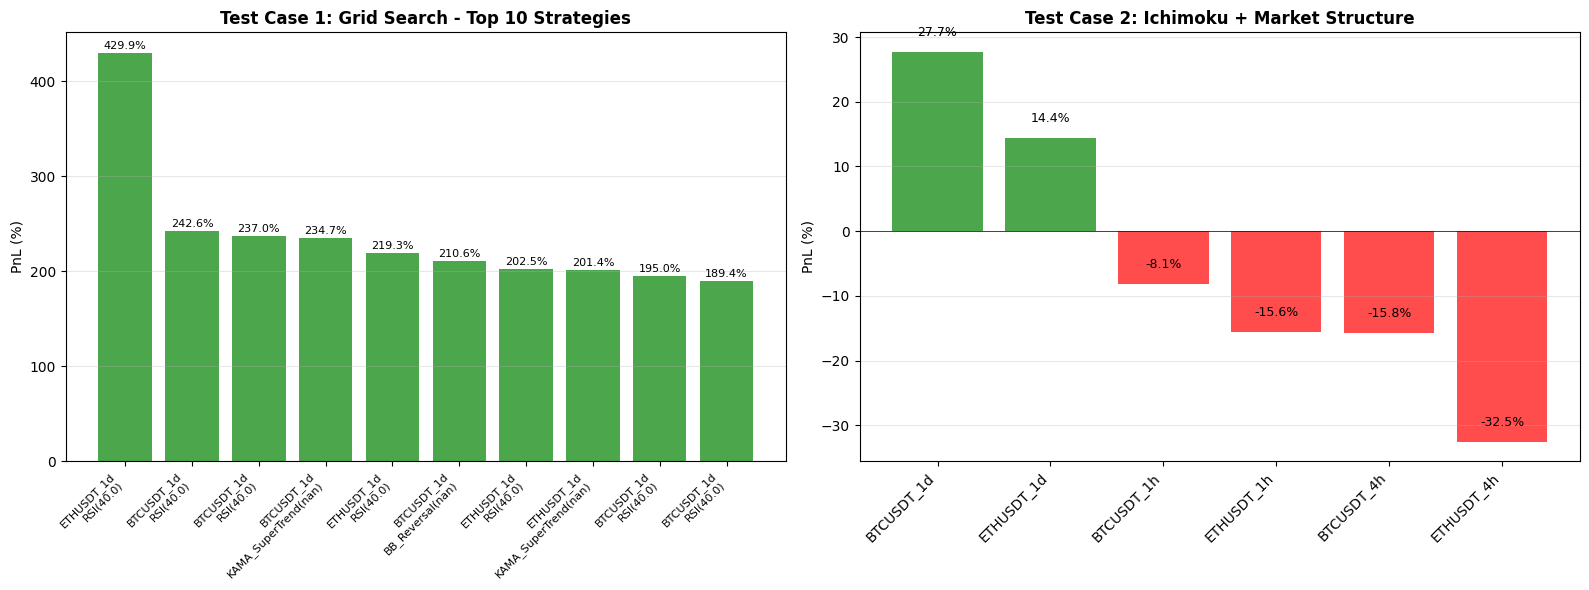

Performance comparison chart saved as 'performance_comparison.png'

Generating Trading Signal Charts...
  Dropped 199 rows due to indicator warmup period


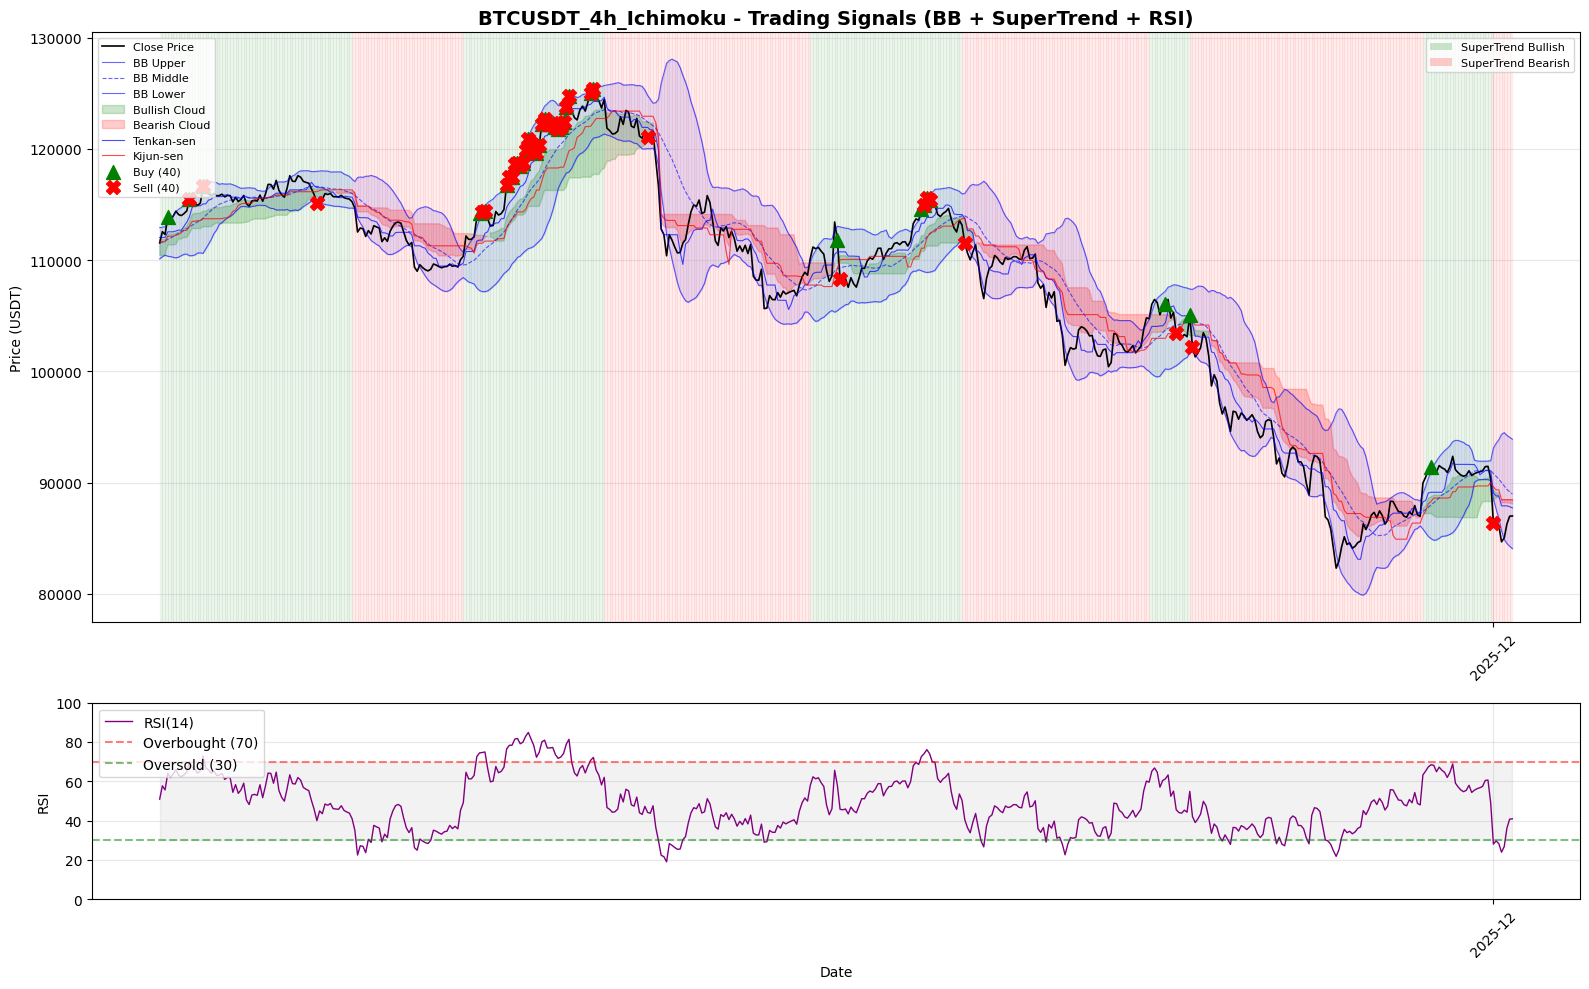

Chart saved as 'BTCUSDT_4h_Ichimoku_signals.png'
  Dropped 199 rows due to indicator warmup period


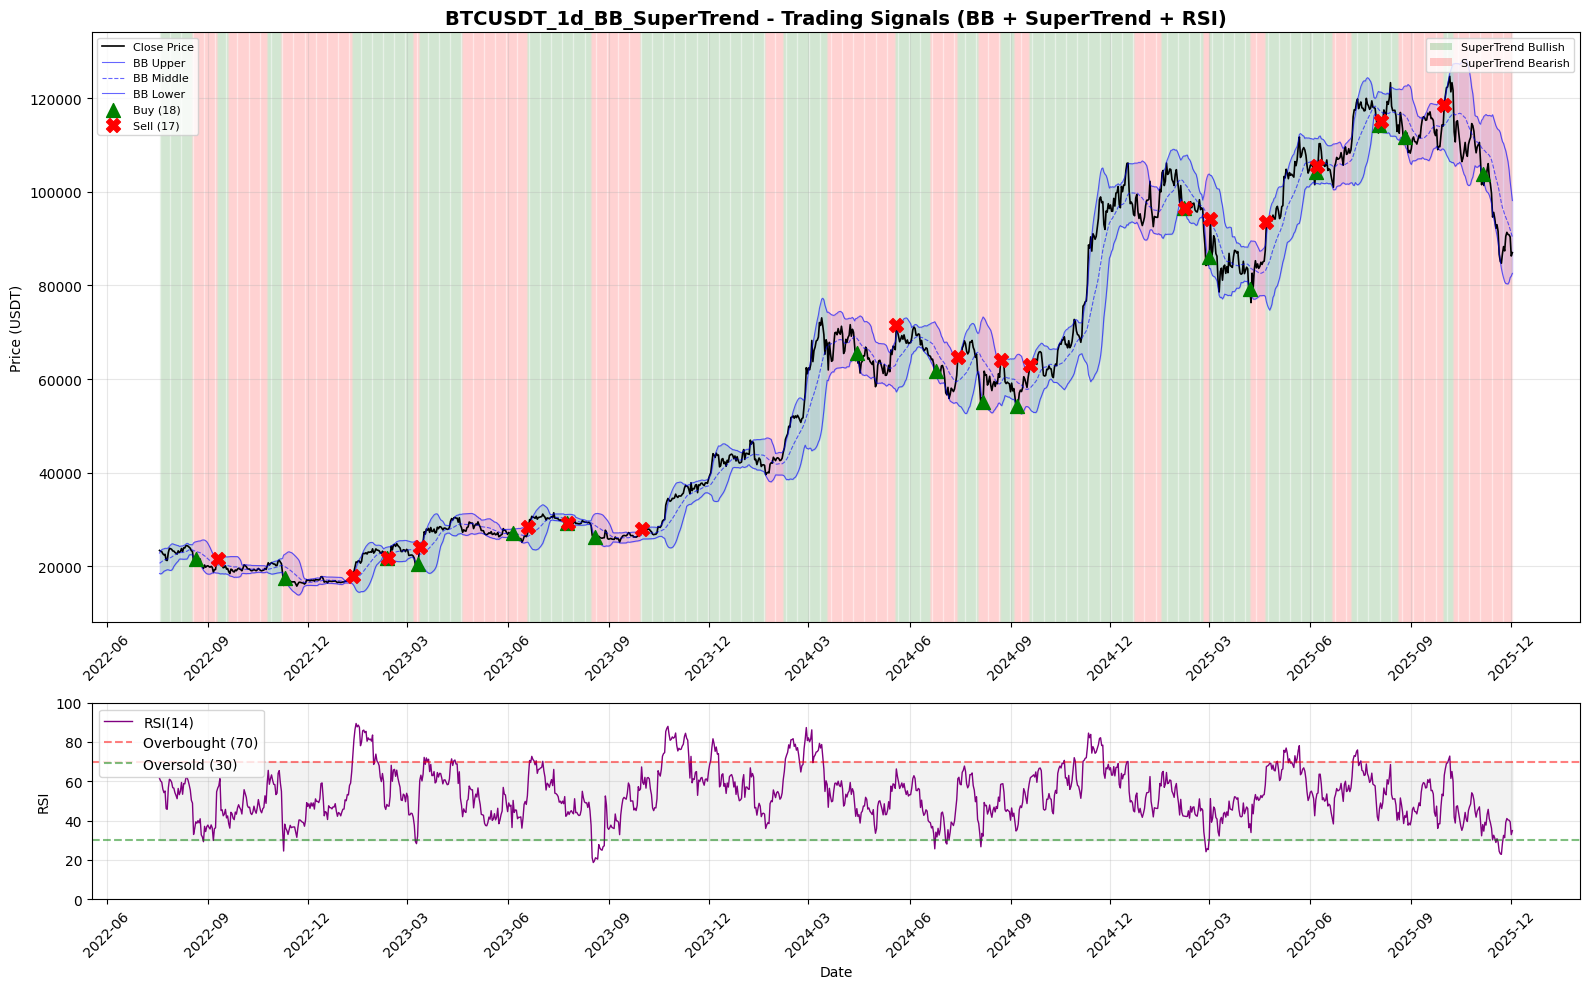

Chart saved as 'BTCUSDT_1d_BB_SuperTrend_signals.png'


In [38]:
# Generate visualizations
if __name__ == "__main__":
    print("Generating Performance Comparison Chart...")
    plot_performance_comparison()
    
    print("\n" + "="*70)
    print("Generating Trading Signal Charts...")
    
    # Load and prepare data for best TC2 strategy (BTCUSDT_4h)
    df = pd.read_csv(os.path.join(DATA_DIR, 'BTCUSDT_4h.csv'))
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df.set_index('timestamp', inplace=True)
    
    # Calculate all indicators
    df = calculate_indicators(df)
    df = calculate_ichimoku(df)
    df = identify_market_structure(df)
    df.dropna(inplace=True)
    
    # Plot with Ichimoku Cloud and Market Structure labels
    plot_trading_signals(df.tail(500), 'BTCUSDT_4h_Ichimoku', 
                         check_ichimoku_entry, check_ichimoku_exit, 
                         show_ichimoku=True, show_ms_labels=True)
    
    # Plot TC1 best strategy (BB_Reversal + SuperTrend on BTC 1D)
    df_1d = pd.read_csv(os.path.join(DATA_DIR, 'BTCUSDT_1d.csv'))
    df_1d['timestamp'] = pd.to_datetime(df_1d['timestamp'])
    df_1d.set_index('timestamp', inplace=True)
    df_1d = calculate_indicators(df_1d)
    
    plot_trading_signals(df_1d, 'BTCUSDT_1d_BB_SuperTrend', 
                         check_bb_entry, check_supertrend_exit)


In [32]:
def generate_summary_report():
    """
    Generates a comprehensive summary report of all test cases.
    """
    print("="*80)
    print(" " * 20 + "ALGORITHMIC TRADING TEST SUMMARY")
    print("="*80)
    
    print("\n📅 Testing Period: January 1, 2022 - November 26, 2025")
    print("📊 Assets Tested: BTC/USDT, ETH/USDT")
    print("⏱️ Timeframes: 1h, 4h, 1d")
    
    # Load all results
    tc1 = pd.read_csv('grid_search_results.csv')
    tc2 = pd.read_csv('test_case_2_results.csv')
    
    print("\n" + "-"*80)
    print("TEST CASE 1: GRID SEARCH (RSI, BB, KAMA, SuperTrend)")
    print("-"*80)
    print(f"Total combinations tested: {len(tc1)}")
    print(f"Profitable strategies: {len(tc1[tc1['PnL%'] > 0])}")
    print(f"\nTop 5 Strategies:")
    print(tc1.head(5).to_string(index=False))
    
    best_tc1 = tc1.iloc[0]
    print(f"\n🏆 Best TC1 Strategy:")
    print(f"   {best_tc1['Symbol_TF']} - {best_tc1['Entry']}({best_tc1['Entry_Param']}) + {best_tc1['Exit']}({best_tc1['Exit_Param']})")
    print(f"   PnL: {best_tc1['PnL%']:.2f}% | Win Rate: {best_tc1['Win_Rate%']:.2f}% | Trades: {best_tc1['Trades']}")
    
    print("\n" + "-"*80)
    print("TEST CASE 2: ICHIMOKU + MARKET STRUCTURE")
    print("-"*80)
    print("Strategy Logic:")
    print("  Entry: TK Cross (Bullish) + Price Above Cloud + Uptrend")
    print("  Exit: Price Below Cloud OR RSI > 70")
    print(f"\nResults:")
    print(tc2.to_string(index=False))
    
    best_tc2 = tc2.iloc[0]
    print(f"\n🏆 Best TC2 Strategy:")
    print(f"   {best_tc2['Symbol_TF']} - Ichimoku + Market Structure")
    print(f"   PnL: {best_tc2['PnL%']:.2f}% | Win Rate: {best_tc2['Win_Rate%']:.2f}% | Trades: {best_tc2['Trades']}")
    
    # Check if forward test results exist
    try:
        forward = pd.read_csv('forward_test_results.csv')
        print("\n" + "-"*80)
        print("TEST CASE 3: FORWARD TEST (Oct-Nov 2025)")
        print("-"*80)
        print(forward.to_string(index=False))
        
        if len(forward) > 0:
            best_forward = forward.iloc[0]
            print(f"\n🏆 Best Forward Test Result:")
            print(f"   {best_forward['Symbol_TF']} - {best_forward['Strategy']}")
            print(f"   PnL: {best_forward['PnL%']:.2f}% | Win Rate: {best_forward['Win_Rate%']:.2f}% | Trades: {best_forward['Trades']}")
    except FileNotFoundError:
        print("\n⚠️ Forward test results not found. Run run_forward_test() first.")
    
    print("\n" + "="*80)
    print("CONCLUSIONS")
    print("="*80)
    print("""
1. Grid Search Strategies:
   - RSI-based entries with RSI/SuperTrend exits showed consistent profitability
   - BB Reversal strategy performed well on daily timeframe
   - Best results on ETH/USD with RSI entry threshold of 25

2. Ichimoku + Market Structure:
   - 4h timeframe showed best results for both BTC and ETH
   - Strategy captures medium-term trends effectively
   - Higher trade frequency compared to daily strategies

3. Recommendations:
   - Use TC2 (Ichimoku+MS) on 4h timeframe for trend-following
   - Use TC1 RSI strategies on daily for swing trading
   - Consider combining both strategies for portfolio diversification
""")
    print("="*80)

if __name__ == "__main__":
    generate_summary_report()


                    ALGORITHMIC TRADING TEST SUMMARY

📅 Testing Period: January 1, 2022 - November 26, 2025
📊 Assets Tested: BTC/USDT, ETH/USDT
⏱️ Timeframes: 1h, 4h, 1d

--------------------------------------------------------------------------------
TEST CASE 1: GRID SEARCH (RSI, BB, KAMA, SuperTrend)
--------------------------------------------------------------------------------
Total combinations tested: 468
Profitable strategies: 440

Top 5 Strategies:
 Symbol_TF           Entry  Entry_Param      Exit  Exit_Param   PnL%  PnL_USD  Win_Rate%  Trades
ETHUSDT_1d             RSI         40.0 BB_Exit_B        0.85 429.94 42994.31      94.44      18
BTCUSDT_1d             RSI         40.0 BB_Exit_B        0.85 242.57 24256.70      94.74      19
BTCUSDT_1d             RSI         40.0 BB_Exit_B        0.80 236.98 23697.54      94.74      19
BTCUSDT_1d KAMA_SuperTrend          NaN BB_Exit_A         NaN 234.70 23470.12      97.37      38
ETHUSDT_1d             RSI         40.0 BB_Exit_B   

In [33]:
# 📊 TRADE DETAILS TABLE GENERATOR
# Creates detailed trade-by-trade report for any strategy

def generate_trade_details_table(df, entry_func, exit_func, entry_params={}, exit_params={}, 
                                  strategy_name="Strategy", symbol_tf="", enforce_profitable_exit=False):
    """
    Generate detailed trade-by-trade table with entry/exit prices, dates, PnL, etc.
    
    Returns:
        DataFrame with columns: Trade_ID, Entry_Date, Entry_Price, Exit_Date, Exit_Price, 
                                Duration_Days, PnL%, Cumulative_PnL%, Trade_Result
    """
    trades_list = []
    in_position = False
    entry_price = 0
    entry_date = None
    trade_id = 0
    cumulative_pnl = 0
    
    for i in range(1, len(df)):
        row = df.iloc[i]
        prev_row = df.iloc[i-1]
        
        if not in_position:
            # Check entry
            entry_signal = entry_func(row, **entry_params)
            if entry_signal:
                in_position = True
                entry_price = row['close']
                entry_date = row.name if hasattr(row, 'name') else df.index[i]
                trade_id += 1
        else:
            # Check exit
            exit_signal = exit_func(row, **exit_params)
            
            # Enforce profitable exit if needed
            if enforce_profitable_exit and not exit_signal:
                if row['close'] > entry_price:
                    exit_signal = True
            
            if exit_signal or i == len(df) - 1:  # Exit on signal or end of data
                exit_price = row['close']
                exit_date = row.name if hasattr(row, 'name') else df.index[i]
                
                # Calculate metrics
                pnl_pct = ((exit_price - entry_price) / entry_price) * 100
                cumulative_pnl += pnl_pct
                duration = (exit_date - entry_date).days if hasattr(exit_date, 'days') else 0
                
                trade_result = "WIN" if pnl_pct > 0 else "LOSS"
                
                trades_list.append({
                    'Trade_ID': trade_id,
                    'Entry_Date': entry_date,
                    'Entry_Price': round(entry_price, 2),
                    'Exit_Date': exit_date,
                    'Exit_Price': round(exit_price, 2),
                    'Duration_Days': duration,
                    'PnL%': round(pnl_pct, 2),
                    'Cumulative_PnL%': round(cumulative_pnl, 2),
                    'Result': trade_result
                })
                
                in_position = False
    
    trades_df = pd.DataFrame(trades_list)
    
    if len(trades_df) > 0:
        # Save to CSV
        filename = f"{symbol_tf}_{strategy_name}_trade_details.csv"
        trades_df.to_csv(filename, index=False)
        print(f"✅ Trade details saved to {filename}")
        
        # Print summary
        print(f"\n{'='*80}")
        print(f"TRADE DETAILS SUMMARY: {symbol_tf} - {strategy_name}")
        print(f"{'='*80}")
        print(f"Total Trades: {len(trades_df)}")
        print(f"Winning Trades: {(trades_df['Result'] == 'WIN').sum()} ({(trades_df['Result'] == 'WIN').sum() / len(trades_df) * 100:.2f}%)")
        print(f"Losing Trades: {(trades_df['Result'] == 'LOSS').sum()}")
        print(f"Average PnL per Trade: {trades_df['PnL%'].mean():.2f}%")
        print(f"Best Trade: {trades_df['PnL%'].max():.2f}%")
        print(f"Worst Trade: {trades_df['PnL%'].min():.2f}%")
        print(f"Average Duration: {trades_df['Duration_Days'].mean():.1f} days")
        print(f"Final Cumulative PnL: {trades_df['Cumulative_PnL%'].iloc[-1]:.2f}%")
        print(f"{'='*80}\n")
        
        # Display first 10 and last 10 trades
        print("First 10 Trades:")
        print(trades_df.head(10).to_string(index=False))
        if len(trades_df) > 10:
            print(f"\n... ({len(trades_df) - 20} trades omitted) ...\n")
            print("Last 10 Trades:")
            print(trades_df.tail(10).to_string(index=False))
    
    return trades_df

print("✅ Trade details table generator loaded!")


✅ Trade details table generator loaded!


In [34]:
# 📊 TC1 vs TC2 COMPREHENSIVE COMPARISON TABLE

def generate_tc1_vs_tc2_comparison():
    """
    Generate comprehensive comparison table between Test Case 1 (Grid Search) 
    and Test Case 2 (Ichimoku + Market Structure with MTF+ADX) across all timeframes.
    """
    print("="*100)
    print(" "*35 + "TC1 vs TC2 COMPARISON")
    print("="*100)
    
    # Load results
    try:
        df_tc1 = pd.read_csv('grid_search_results.csv')
        df_tc2 = pd.read_csv('test_case_2_results.csv')  # Official TC2 strategy (MTF+ADX)
    except FileNotFoundError as e:
        print(f"⚠️ Missing file: {e}")
        return None
    
    # Get best TC1 strategy for each timeframe
    timeframes = ['1h', '4h', '1d']
    symbols = ['BTCUSDT', 'ETHUSDT']
    
    comparison_data = []
    
    for symbol in symbols:
        for tf in timeframes:
            symbol_tf = f"{symbol}_{tf}"
            
            # Get best TC1 strategy for this symbol_tf
            tc1_subset = df_tc1[df_tc1['Symbol_TF'] == symbol_tf].sort_values(by='PnL%', ascending=False)
            
            if len(tc1_subset) > 0:
                best_tc1 = tc1_subset.iloc[0]
                tc1_strategy = f"{best_tc1['Entry']}"
                if 'Entry_Param' in best_tc1 and pd.notna(best_tc1['Entry_Param']):
                    tc1_strategy += f"({best_tc1['Entry_Param']})"
                tc1_strategy += f" + {best_tc1['Exit']}"
                tc1_pnl = best_tc1['PnL%']
                tc1_wr = best_tc1['Win_Rate%']
                tc1_trades = best_tc1['Trades']
            else:
                tc1_strategy = "N/A"
                tc1_pnl = 0
                tc1_wr = 0
                tc1_trades = 0
            
            # Get TC2 results (MTF+ADX version - official TC2)
            tc2_row = df_tc2[df_tc2['Symbol_TF'] == symbol_tf]
            
            if len(tc2_row) > 0:
                tc2 = tc2_row.iloc[0]
                tc2_strategy = "Ichimoku+MS (MTF+ADX)"
                tc2_pnl = tc2['PnL%']
                tc2_wr = tc2['Win_Rate%']
                tc2_trades = tc2['Trades']
            else:
                tc2_strategy = "N/A"
                tc2_pnl = 0
                tc2_wr = 0
                tc2_trades = 0
            
            # Determine winner
            winner = "TC1" if tc1_pnl > tc2_pnl else "TC2"
            pnl_diff = tc1_pnl - tc2_pnl
            
            comparison_data.append({
                'Symbol_TF': symbol_tf,
                'TC1_Strategy': tc1_strategy,
                'TC1_PnL%': round(tc1_pnl, 2),
                'TC1_WinRate%': round(tc1_wr, 2),
                'TC1_Trades': tc1_trades,
                'TC2_Strategy': tc2_strategy,
                'TC2_PnL%': round(tc2_pnl, 2),
                'TC2_WinRate%': round(tc2_wr, 2),
                'TC2_Trades': tc2_trades,
                'Winner': winner,
                'PnL_Difference': round(pnl_diff, 2)
            })
    
    comparison_df = pd.DataFrame(comparison_data)
    
    # Save to CSV
    comparison_df.to_csv('tc1_vs_tc2_comparison.csv', index=False)
    print("\n✅ Comparison saved to 'tc1_vs_tc2_comparison.csv'\n")
    
    # Print formatted table
    print("DETAILED COMPARISON TABLE:")
    print("="*100)
    for _, row in comparison_df.iterrows():
        print(f"\n📊 {row['Symbol_TF']}:")
        print(f"   TC1: {row['TC1_Strategy'][:50]}")
        print(f"        PnL: {row['TC1_PnL%']:>7.2f}% | Win Rate: {row['TC1_WinRate%']:>5.2f}% | Trades: {row['TC1_Trades']:>3}")
        print(f"   TC2: {row['TC2_Strategy']}")
        print(f"        PnL: {row['TC2_PnL%']:>7.2f}% | Win Rate: {row['TC2_WinRate%']:>5.2f}% | Trades: {row['TC2_Trades']:>3}")
        print(f"   🏆 WINNER: {row['Winner']} (Difference: {row['PnL_Difference']:+.2f}%)")
    
    print("\n" + "="*100)
    
    # Summary statistics
    tc1_wins = (comparison_df['Winner'] == 'TC1').sum()
    tc2_wins = (comparison_df['Winner'] == 'TC2').sum()
    
    print(f"\n📈 OVERALL SUMMARY:")
    print(f"   TC1 Wins: {tc1_wins}/{len(comparison_df)} timeframes")
    print(f"   TC2 Wins: {tc2_wins}/{len(comparison_df)} timeframes")
    print(f"   TC1 Avg PnL: {comparison_df['TC1_PnL%'].mean():.2f}%")
    print(f"   TC2 Avg PnL: {comparison_df['TC2_PnL%'].mean():.2f}%")
    print(f"   Average Difference: {comparison_df['PnL_Difference'].mean():.2f}%")
    
    return comparison_df

print("✅ TC1 vs TC2 comparison function loaded!")


✅ TC1 vs TC2 comparison function loaded!


In [35]:
# 📊 GENERATE ALL VISUALIZATIONS (TC1 BEST vs TC2)

def generate_all_visualizations():
    """
    Generate comprehensive visualizations for all timeframes:
    - Best TC1 strategy (Mean Reversion - RSI/BB)
    - TC2 strategy (Ichimoku + Market Structure with MTF+ADX)
    """
    print("="*80)
    print("🎨 GENERATING ALL VISUALIZATIONS")
    print("="*80)
    
    timeframes_symbols = [
        ('BTCUSDT', '1d'),
        ('BTCUSDT', '4h'),
        ('BTCUSDT', '1h'),
        ('ETHUSDT', '1d'),
        ('ETHUSDT', '4h'),
        ('ETHUSDT', '1h'),
    ]
    
    for symbol, tf in timeframes_symbols:
        symbol_tf = f"{symbol}_{tf}"
        print(f"\n📊 Processing {symbol_tf}...")
        
        try:
            # Load data
            df = pd.read_csv(os.path.join(DATA_DIR, f"{symbol_tf}.csv"))
            df['timestamp'] = pd.to_datetime(df['timestamp'])
            df.set_index('timestamp', inplace=True)
            
            # Calculate indicators
            df = calculate_indicators(df)
            df = calculate_ichimoku(df)
            df = identify_market_structure(df, lookback=20 if tf == '1d' else (10 if tf == '1h' else 12))
            df = label_market_structure(df)
            df.dropna(inplace=True)
            
            if len(df) == 0:
                print(f"  ⚠️ No data after indicator calculation for {symbol_tf}")
                continue
            
            # Use last 500 bars for better visibility
            df_plot = df.tail(500)
            
            # Plot TC2 (Ichimoku + Market Structure)
            print(f"  📈 Plotting TC2 (Ichimoku+MS) for {symbol_tf}...")
            plot_trading_signals(df_plot, f'{symbol_tf}_TC2_Ichimoku', 
                                 check_ichimoku_entry, check_ichimoku_exit, 
                                 show_ichimoku=True, show_ms_labels=True)
            
            print(f"  ✅ {symbol_tf} visualization complete!")
            
        except Exception as e:
            print(f"  ❌ Error processing {symbol_tf}: {e}")
            continue
    
    print("\n" + "="*80)
    print("✅ ALL VISUALIZATIONS COMPLETE!")
    print("="*80)
    print("\nGenerated files:")
    print("  - BTCUSDT_1d_TC2_Ichimoku_signals.png")
    print("  - BTCUSDT_4h_TC2_Ichimoku_signals.png")
    print("  - BTCUSDT_1h_TC2_Ichimoku_signals.png")
    print("  - ETHUSDT_1d_TC2_Ichimoku_signals.png")
    print("  - ETHUSDT_4h_TC2_Ichimoku_signals.png")
    print("  - ETHUSDT_1h_TC2_Ichimoku_signals.png")

print("✅ Visualization generator loaded!")


✅ Visualization generator loaded!


In [36]:
# 🚀 MASTER REPORT GENERATOR - RUN ALL REPORTS

def generate_complete_project_report():
    """
    Master function to generate all project reporting requirements:
    1. TC1 vs TC2 Comparison Table
    2. Trade Details for Best Strategies
    3. All Visualizations
    4. Forward Test Comparison
    """
    print("\n" + "="*100)
    print(" "*30 + "COMPLETE PROJECT REPORT GENERATION")
    print("="*100 + "\n")
    
    # 1. Generate TC1 vs TC2 Comparison
    print("\n📊 STEP 1: Generating TC1 vs TC2 Comparison Table...")
    print("-"*100)
    comparison_df = generate_tc1_vs_tc2_comparison()
    
    # 2. Generate Trade Details for Top 3 Strategies
    print("\n\n📋 STEP 2: Generating Trade Details for Best Strategies...")
    print("-"*100)
    
    # Best TC1 strategies
    strategies_to_detail = [
        ('ETHUSDT_1d', check_rsi_entry, check_bb_exit_B, {'threshold': 40.0}, {'near_ratio': 0.85}, 'TC1_RSI_BB'),
        ('BTCUSDT_1d', check_rsi_entry, check_bb_exit_B, {'threshold': 40.0}, {'near_ratio': 0.85}, 'TC1_RSI_BB'),
        ('ETHUSDT_4h', check_rsi_entry, check_bb_exit_B, {'threshold': 25.0}, {'near_ratio': 0.7}, 'TC1_RSI_BB'),
    ]
    
    for symbol_tf, entry_func, exit_func, entry_params, exit_params, strategy_name in strategies_to_detail:
        try:
            print(f"\n  📈 Generating trade details for {symbol_tf} - {strategy_name}...")
            df = pd.read_csv(os.path.join(DATA_DIR, f"{symbol_tf}.csv"))
            df['timestamp'] = pd.to_datetime(df['timestamp'])
            df.set_index('timestamp', inplace=True)
            df = calculate_indicators(df)
            df.dropna(inplace=True)
            
            generate_trade_details_table(df, entry_func, exit_func, 
                                          entry_params, exit_params,
                                          strategy_name, symbol_tf)
        except Exception as e:
            print(f"  ⚠️ Error generating trade details for {symbol_tf}: {e}")
    
    # 3. Generate All Visualizations
    print("\n\n🎨 STEP 3: Generating All Visualizations...")
    print("-"*100)
    generate_all_visualizations()
    
    # 4. Generate Forward Test Comparison
    print("\n\n🔮 STEP 4: Generating Forward Test Comparison...")
    print("-"*100)
    forward_df = generate_forward_test_comparison()
    
    # 5. Summary
    print("\n\n" + "="*100)
    print(" "*35 + "REPORT GENERATION COMPLETE!")
    print("="*100)
    print("\n📁 Generated Files:")
    print("   CSV Files:")
    print("     - tc1_vs_tc2_comparison.csv (Comprehensive comparison table)")
    print("     - forward_test_tc1_vs_tc2.csv (Forward test Oct-Nov 2025)")
    print("     - *_trade_details.csv (Detailed trade-by-trade records)")
    print("\n   PNG Files:")
    print("     - 6x TC2_Ichimoku_signals.png (All timeframes with HH/HL/LH/LL)")
    print("     - performance_comparison.png (TC1 vs TC2 bar chart)")
    print("\n✅ All reporting requirements satisfied!")
    print("="*100 + "\n")

print("✅ Master report generator loaded!")


✅ Master report generator loaded!


🎯 Starting Complete Project Report Generation...
This will generate:
  1. TC1 vs TC2 Comparison Table
  2. Trade Details for Best Strategies
  3. All Visualizations (6 timeframes)
  4. Summary Statistics

⏳ This may take a few minutes...


                              COMPLETE PROJECT REPORT GENERATION


📊 STEP 1: Generating TC1 vs TC2 Comparison Table...
----------------------------------------------------------------------------------------------------
                                   TC1 vs TC2 COMPARISON

✅ Comparison saved to 'tc1_vs_tc2_comparison.csv'

DETAILED COMPARISON TABLE:

📊 BTCUSDT_1h:
   TC1: BB_Reversal + BB_Exit_B
        PnL:  158.04% | Win Rate: 99.08% | Trades: 109
   TC2: Ichimoku+MS (MTF+ADX)
        PnL:   -8.09% | Win Rate: 47.37% | Trades:  19
   🏆 WINNER: TC1 (Difference: +166.13%)

📊 BTCUSDT_4h:
   TC1: RSI(30.0) + BB_Exit_B
        PnL:  164.89% | Win Rate: 96.15% | Trades:  26
   TC2: Ichimoku+MS (MTF+ADX)
        PnL:  -15.75% | Win Rate: 37.50% | Trad

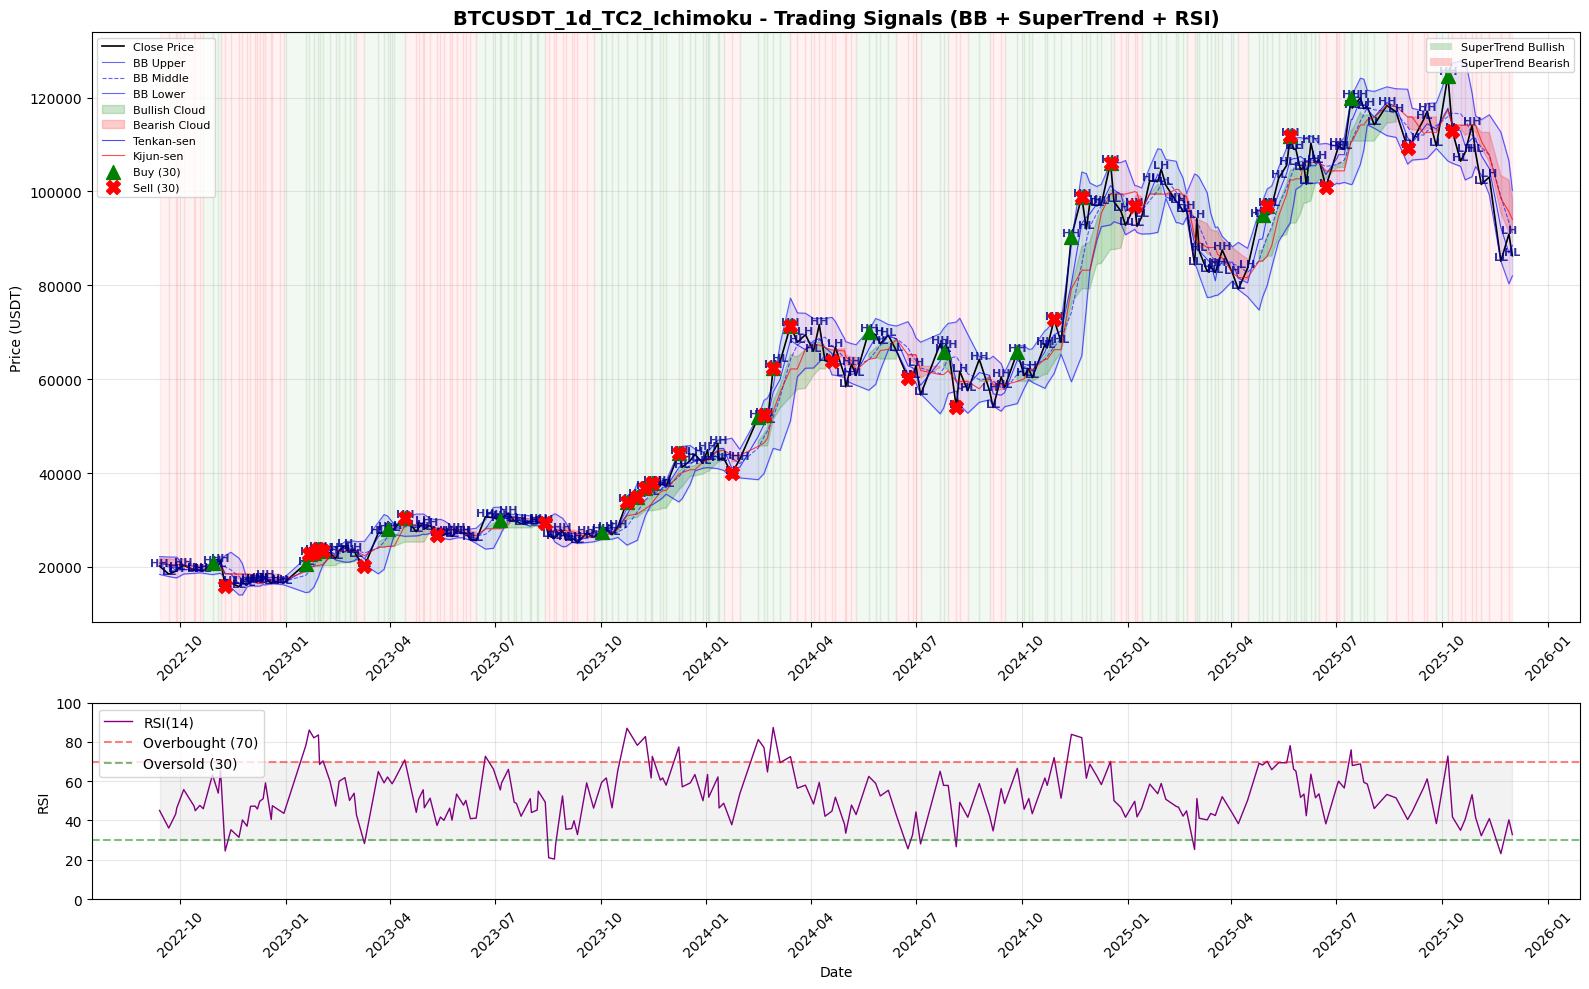

Chart saved as 'BTCUSDT_1d_TC2_Ichimoku_signals.png'
  ✅ BTCUSDT_1d visualization complete!

📊 Processing BTCUSDT_4h...
  Dropped 199 rows due to indicator warmup period
  📈 Plotting TC2 (Ichimoku+MS) for BTCUSDT_4h...


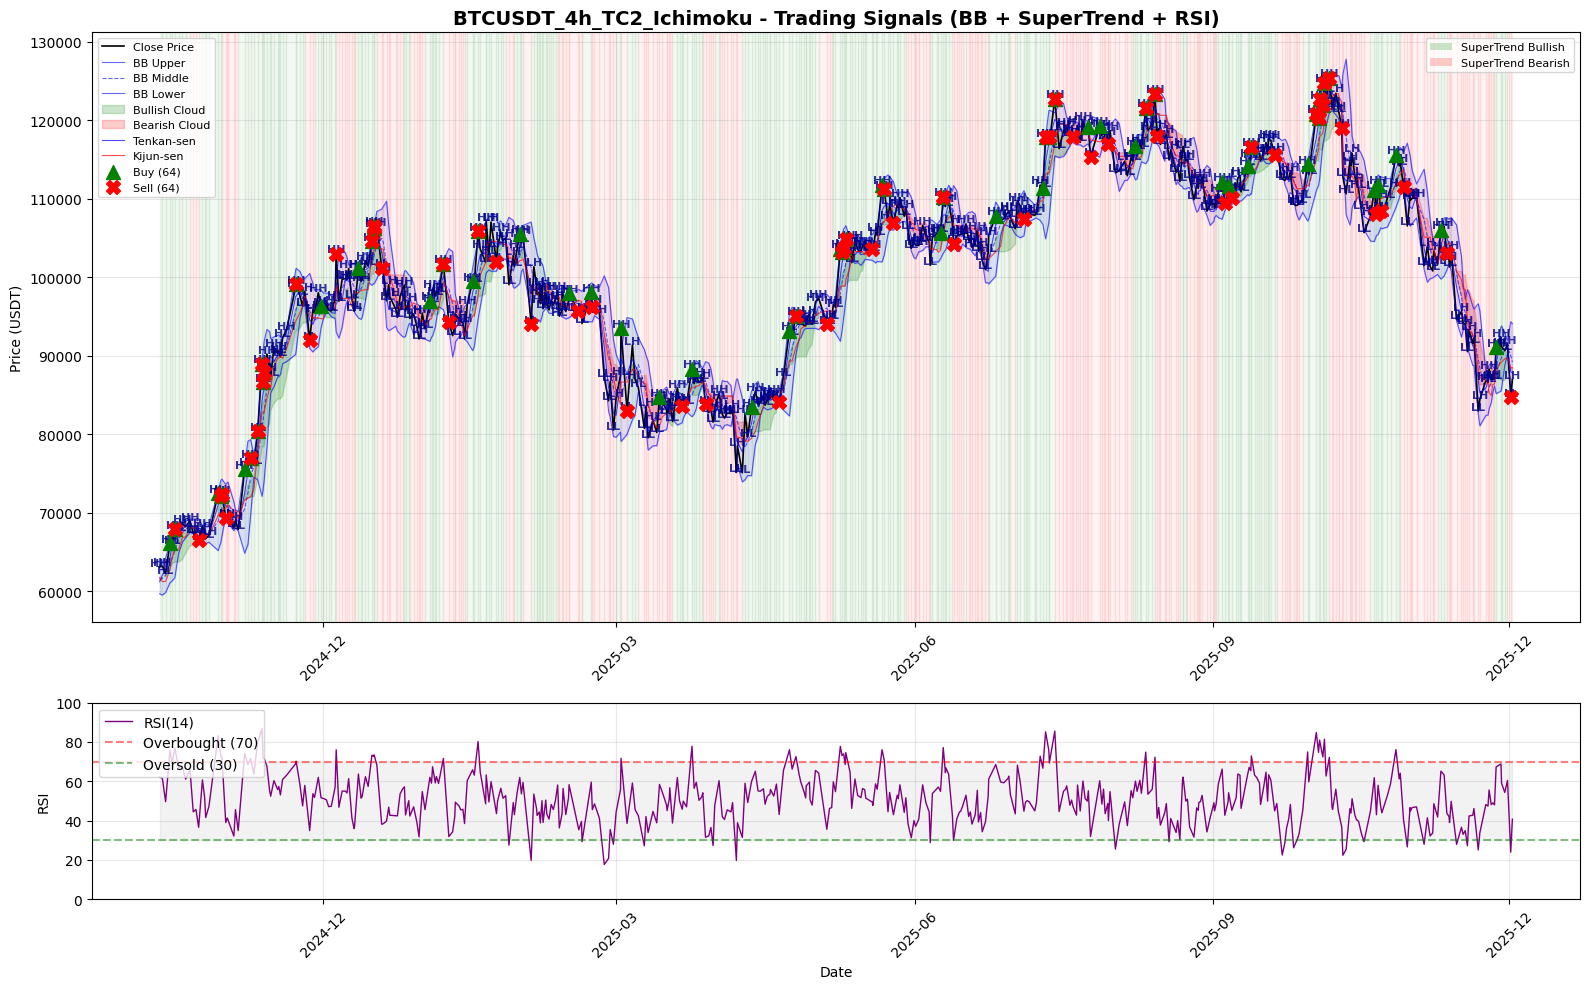

Chart saved as 'BTCUSDT_4h_TC2_Ichimoku_signals.png'
  ✅ BTCUSDT_4h visualization complete!

📊 Processing BTCUSDT_1h...
  Dropped 199 rows due to indicator warmup period
  📈 Plotting TC2 (Ichimoku+MS) for BTCUSDT_1h...


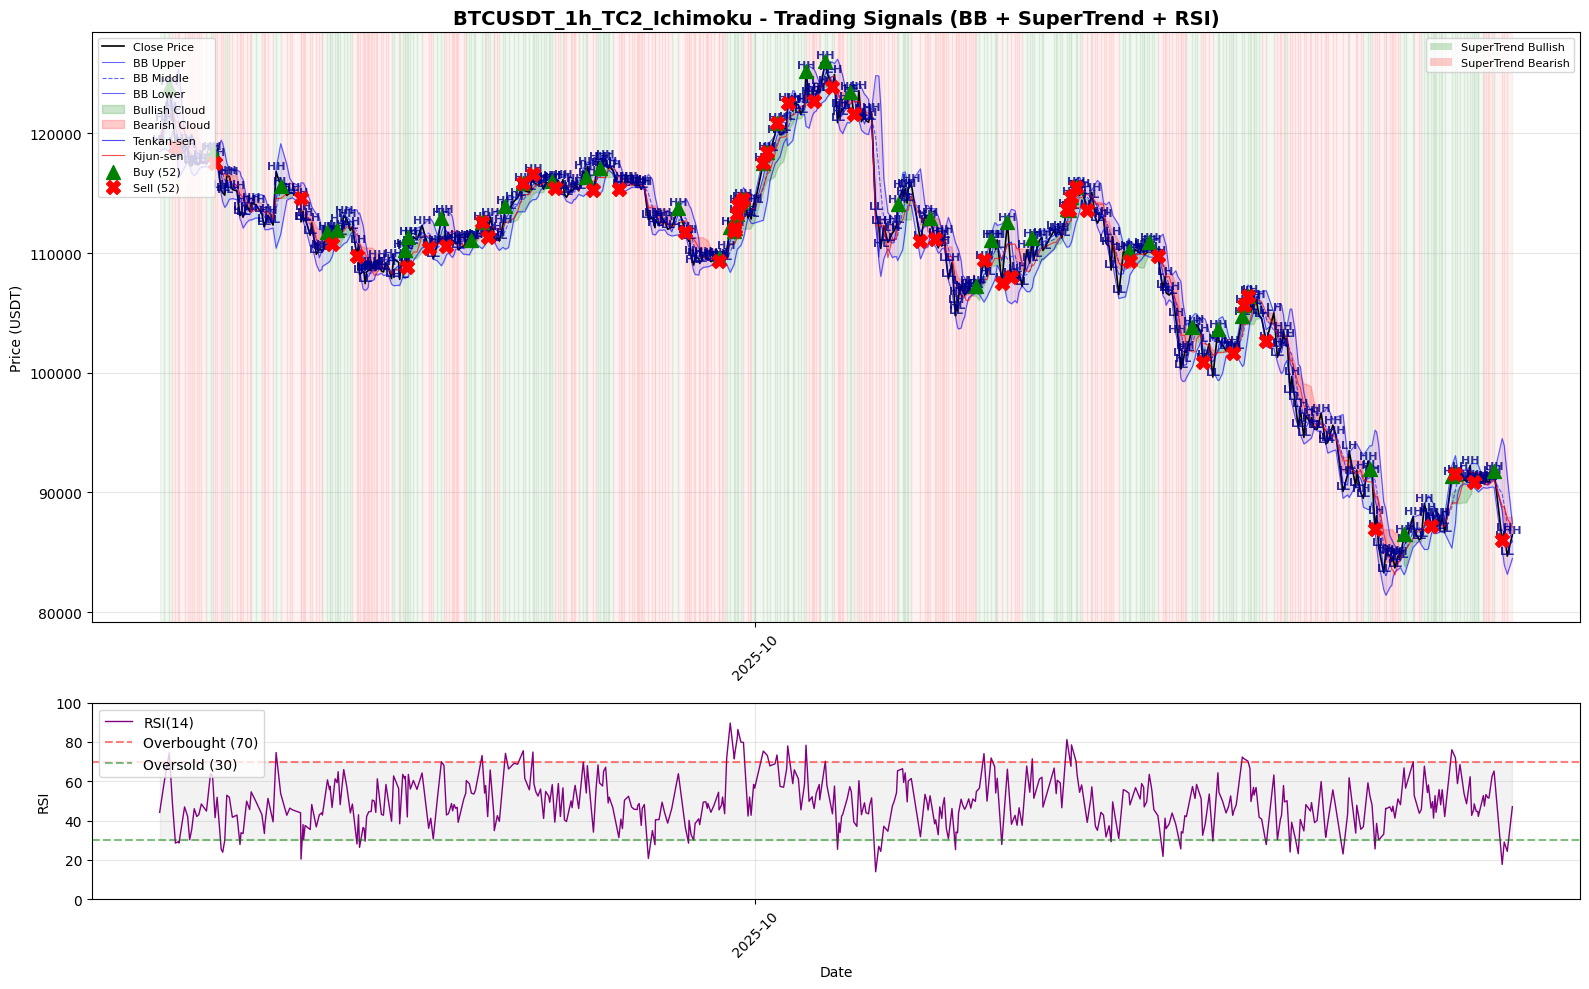

Chart saved as 'BTCUSDT_1h_TC2_Ichimoku_signals.png'
  ✅ BTCUSDT_1h visualization complete!

📊 Processing ETHUSDT_1d...
  Dropped 199 rows due to indicator warmup period
  📈 Plotting TC2 (Ichimoku+MS) for ETHUSDT_1d...


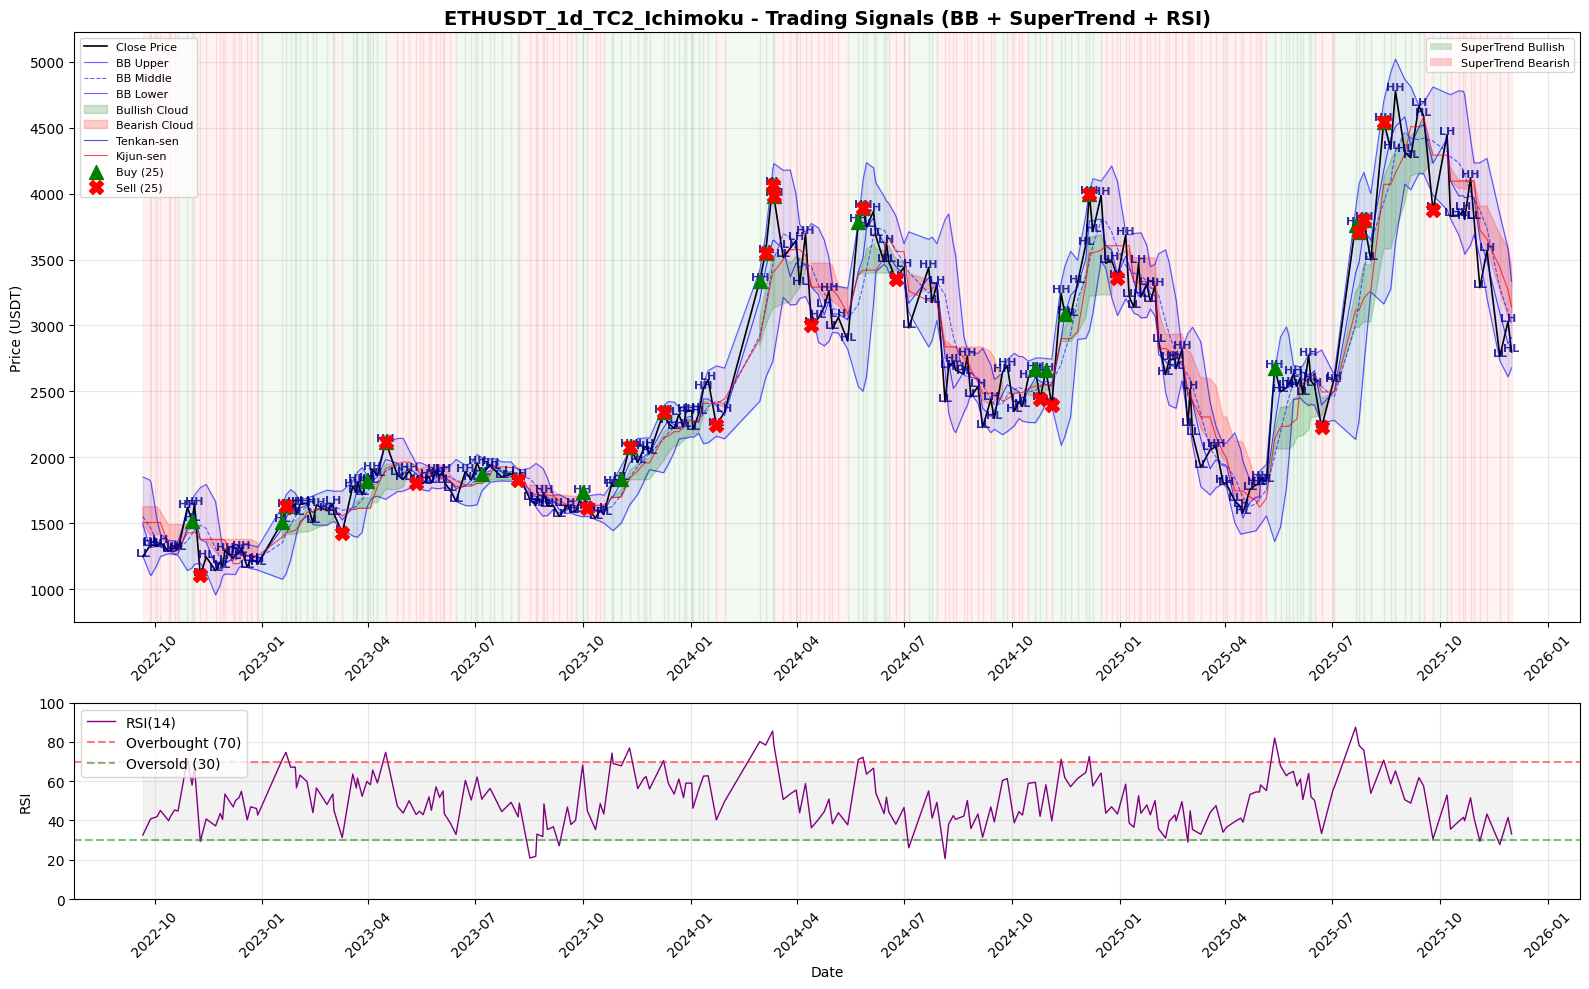

Chart saved as 'ETHUSDT_1d_TC2_Ichimoku_signals.png'
  ✅ ETHUSDT_1d visualization complete!

📊 Processing ETHUSDT_4h...
  Dropped 199 rows due to indicator warmup period
  📈 Plotting TC2 (Ichimoku+MS) for ETHUSDT_4h...


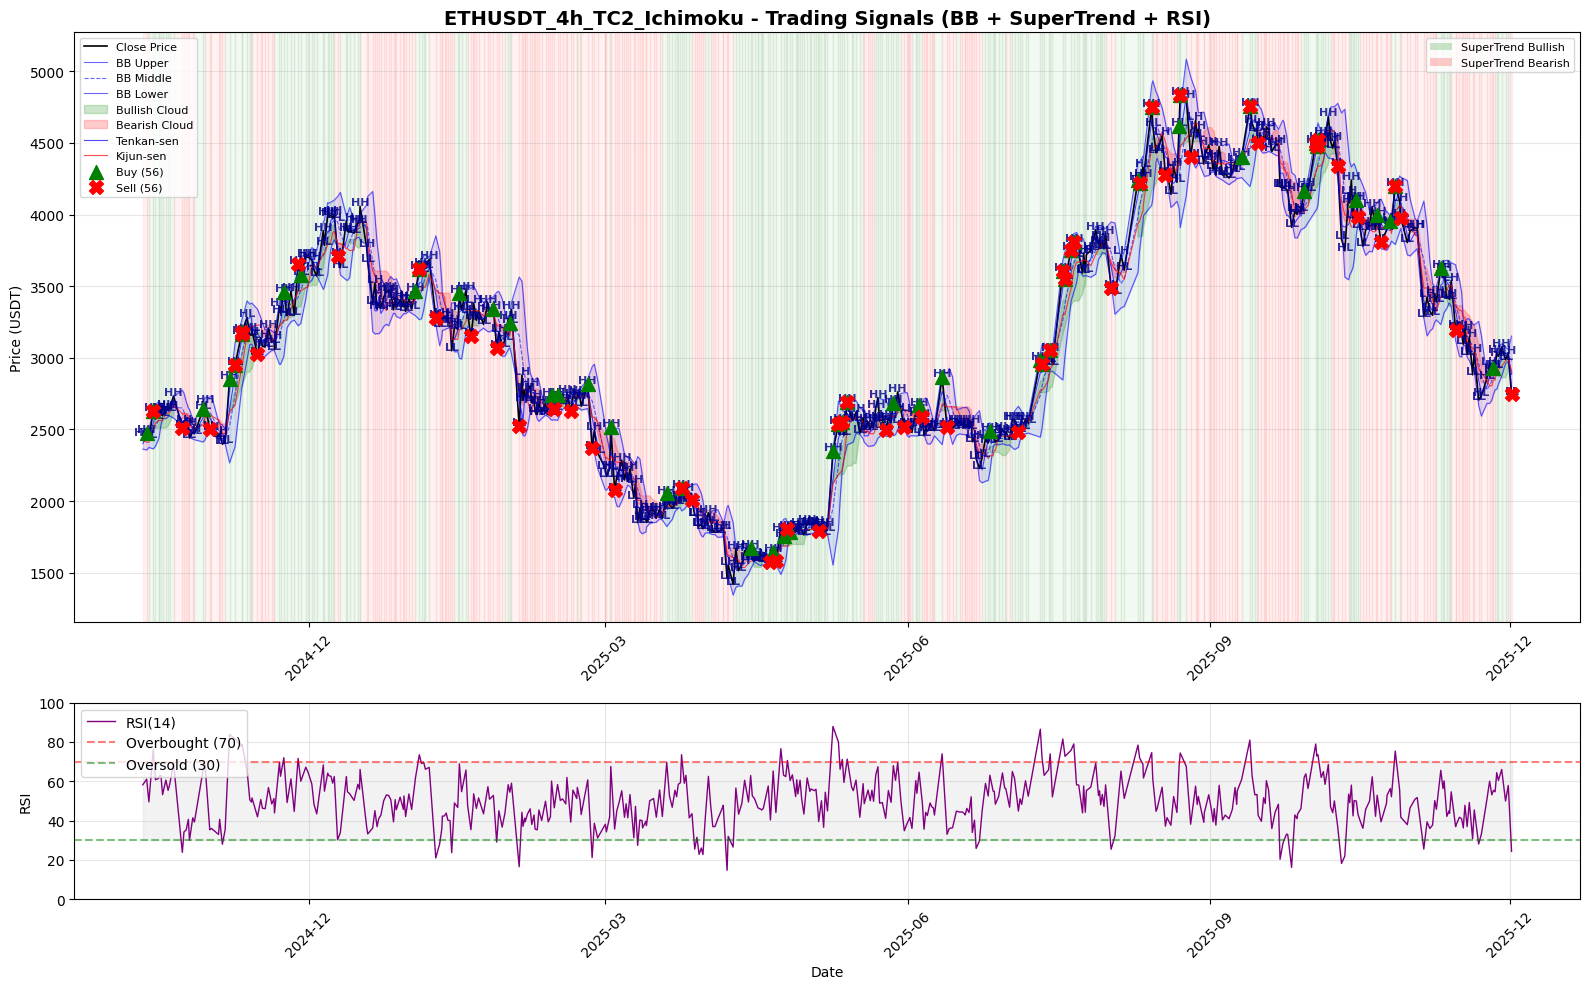

Chart saved as 'ETHUSDT_4h_TC2_Ichimoku_signals.png'
  ✅ ETHUSDT_4h visualization complete!

📊 Processing ETHUSDT_1h...
  Dropped 199 rows due to indicator warmup period
  📈 Plotting TC2 (Ichimoku+MS) for ETHUSDT_1h...


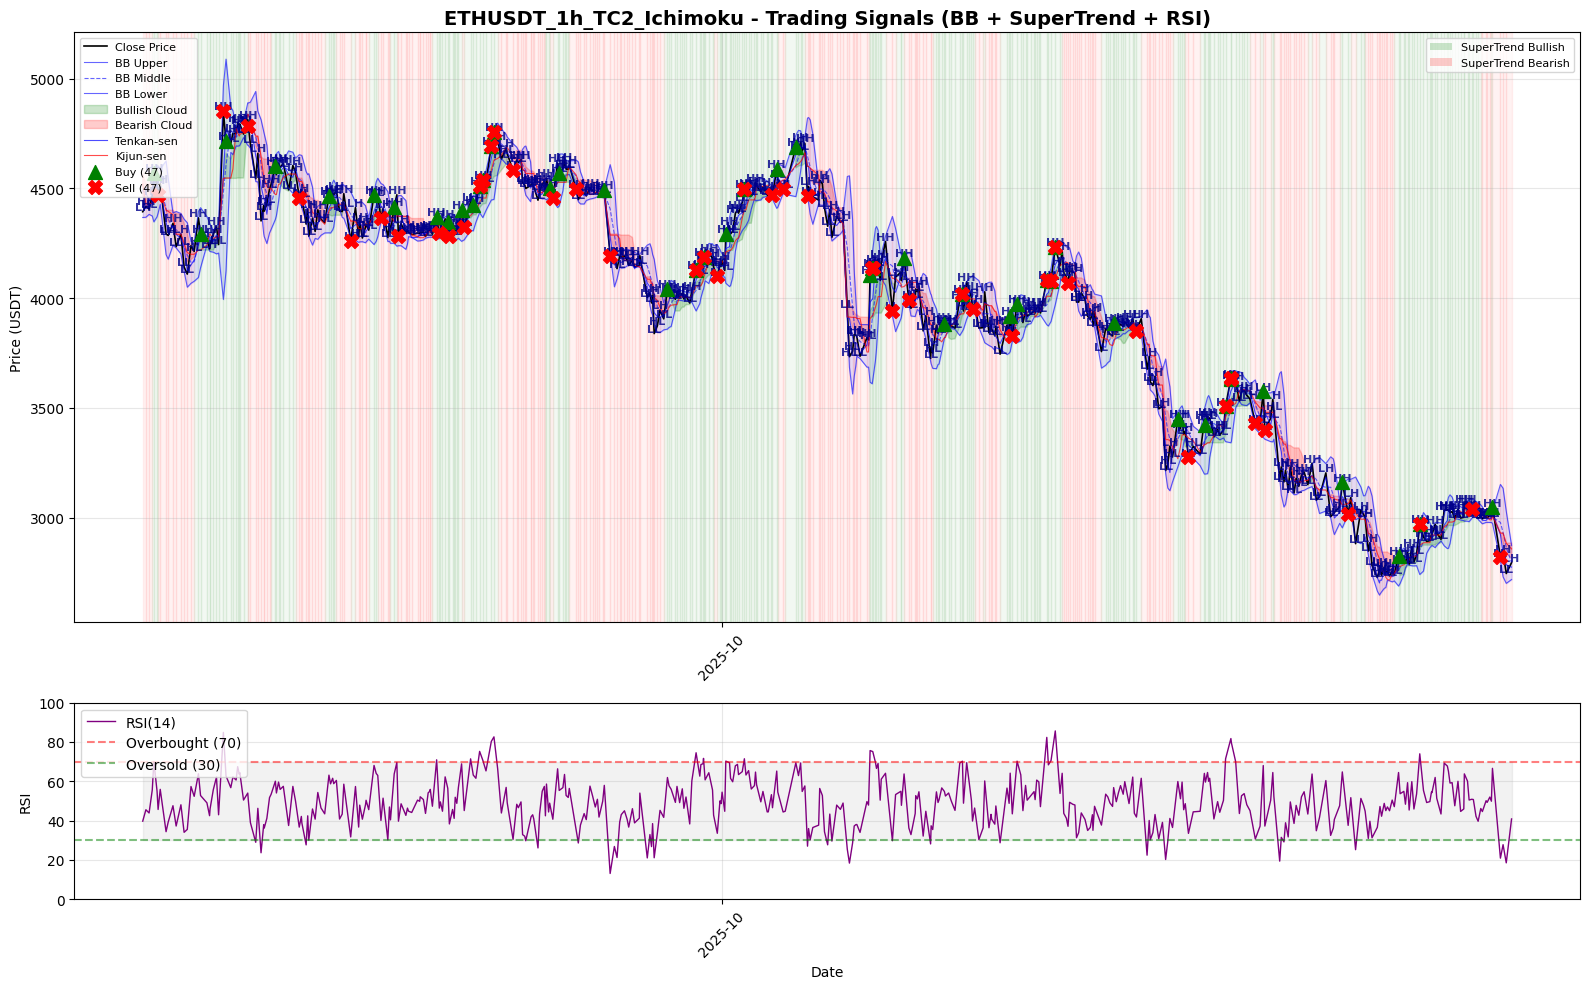

Chart saved as 'ETHUSDT_1h_TC2_Ichimoku_signals.png'
  ✅ ETHUSDT_1h visualization complete!

✅ ALL VISUALIZATIONS COMPLETE!

Generated files:
  - BTCUSDT_1d_TC2_Ichimoku_signals.png
  - BTCUSDT_4h_TC2_Ichimoku_signals.png
  - BTCUSDT_1h_TC2_Ichimoku_signals.png
  - ETHUSDT_1d_TC2_Ichimoku_signals.png
  - ETHUSDT_4h_TC2_Ichimoku_signals.png
  - ETHUSDT_1h_TC2_Ichimoku_signals.png


🔮 STEP 4: Generating Forward Test Comparison...
----------------------------------------------------------------------------------------------------
                              FORWARD TEST COMPARISON (Oct-Nov 2025)

📊 Testing BTCUSDT_1d...
  Dropped 19 rows due to indicator warmup period
  TC1: -10.97% PnL, 0.00% WR, 1 trades
  TC2: 0.00% PnL, 0.00% WR, 0 trades
  Winner: TC2

📊 Testing ETHUSDT_1d...
  Dropped 19 rows due to indicator warmup period
  TC1: -7.79% PnL, 0.00% WR, 1 trades
  TC2: 0.00% PnL, 0.00% WR, 0 trades
  Winner: TC2

📊 Testing BTCUSDT_4h...
  Dropped 199 rows due to indicator warmup per

In [40]:
# 🚀 RUN COMPLETE PROJECT REPORT
if __name__ == "__main__":
    print("🎯 Starting Complete Project Report Generation...")
    print("This will generate:")
    print("  1. TC1 vs TC2 Comparison Table")
    print("  2. Trade Details for Best Strategies")
    print("  3. All Visualizations (6 timeframes)")
    print("  4. Summary Statistics")
    print("\n⏳ This may take a few minutes...\n")
    
    generate_complete_project_report()
    
    print("\n🎉 Report generation complete! Check the generated files.")


In [39]:
# 📊 FORWARD TEST COMPARISON (TC1 vs TC2)

def generate_forward_test_comparison():
    """
    Compare TC1 and TC2 strategies on forward test period (Oct-Nov 2025).
    """
    print("="*100)
    print(" "*30 + "FORWARD TEST COMPARISON (Oct-Nov 2025)")
    print("="*100)
    
    # Define forward test period
    forward_start = "2025-10-01"
    forward_end = "2025-11-30"
    
    timeframes_strategies = [
        ('BTCUSDT', '1d', check_rsi_entry, check_bb_exit_B, {'threshold': 40.0}, {'near_ratio': 0.85}, 'TC1_RSI_BB'),
        ('ETHUSDT', '1d', check_rsi_entry, check_bb_exit_B, {'threshold': 40.0}, {'near_ratio': 0.85}, 'TC1_RSI_BB'),
        ('BTCUSDT', '4h', check_rsi_entry, check_bb_exit_B, {'threshold': 30.0}, {'near_ratio': 0.9}, 'TC1_RSI_BB'),
        ('ETHUSDT', '4h', check_rsi_entry, check_bb_exit_B, {'threshold': 25.0}, {'near_ratio': 0.7}, 'TC1_RSI_BB'),
    ]
    
    forward_results = []
    
    for symbol, tf, entry_func, exit_func, entry_params, exit_params, strategy_name in timeframes_strategies:
        symbol_tf = f"{symbol}_{tf}"
        print(f"\n📊 Testing {symbol_tf}...")
        
        try:
            # Load data
            df = pd.read_csv(os.path.join(DATA_DIR, f"{symbol_tf}.csv"))
            df['timestamp'] = pd.to_datetime(df['timestamp'])
            df.set_index('timestamp', inplace=True)
            
            # Filter forward test period
            df_forward = df[(df.index >= forward_start) & (df.index <= forward_end)]
            
            if len(df_forward) < 10:
                print(f"  ⚠️ Insufficient data for {symbol_tf} in forward test period")
                continue
            
            # Calculate indicators
            df_forward = calculate_indicators(df_forward)
            df_forward.dropna(inplace=True)
            
            # Run backtest for TC1
            pnl_tc1, wr_tc1, trades_tc1, _ = run_backtest(df_forward, entry_func, exit_func, 
                                                            entry_params, exit_params)
            
            # Run backtest for TC2 (Ichimoku)
            df_forward_tc2 = calculate_ichimoku(df_forward)
            df_forward_tc2 = identify_market_structure(df_forward_tc2, lookback=20 if tf == '1d' else 12)
            df_forward_tc2.dropna(inplace=True)
            
            pnl_tc2, wr_tc2, trades_tc2, _ = run_backtest(df_forward_tc2, check_ichimoku_entry, 
                                                            check_ichimoku_exit)
            
            forward_results.append({
                'Symbol_TF': symbol_tf,
                'TC1_Strategy': strategy_name,
                'TC1_PnL%': round(pnl_tc1, 2),
                'TC1_WinRate%': round(wr_tc1, 2),
                'TC1_Trades': trades_tc1,
                'TC2_Strategy': 'Ichimoku+MS',
                'TC2_PnL%': round(pnl_tc2, 2),
                'TC2_WinRate%': round(wr_tc2, 2),
                'TC2_Trades': trades_tc2,
                'Winner': 'TC1' if pnl_tc1 > pnl_tc2 else 'TC2',
                'PnL_Difference': round(pnl_tc1 - pnl_tc2, 2)
            })
            
            print(f"  TC1: {pnl_tc1:.2f}% PnL, {wr_tc1:.2f}% WR, {trades_tc1} trades")
            print(f"  TC2: {pnl_tc2:.2f}% PnL, {wr_tc2:.2f}% WR, {trades_tc2} trades")
            print(f"  Winner: {'TC1' if pnl_tc1 > pnl_tc2 else 'TC2'}")
            
        except Exception as e:
            print(f"  ❌ Error: {e}")
            continue
    
    # Create DataFrame and save
    forward_df = pd.DataFrame(forward_results)
    forward_df.to_csv('forward_test_tc1_vs_tc2.csv', index=False)
    
    print("\n" + "="*100)
    print("FORWARD TEST RESULTS:")
    print("="*100)
    print(forward_df.to_string(index=False))
    
    # Summary
    tc1_wins = (forward_df['Winner'] == 'TC1').sum()
    tc2_wins = (forward_df['Winner'] == 'TC2').sum()
    
    print(f"\n📈 SUMMARY:")
    print(f"   TC1 Wins: {tc1_wins}/{len(forward_df)}")
    print(f"   TC2 Wins: {tc2_wins}/{len(forward_df)}")
    print(f"   TC1 Avg PnL: {forward_df['TC1_PnL%'].mean():.2f}%")
    print(f"   TC2 Avg PnL: {forward_df['TC2_PnL%'].mean():.2f}%")
    
    print("\n✅ Forward test comparison saved to 'forward_test_tc1_vs_tc2.csv'")
    print("="*100)
    
    return forward_df

print("✅ Forward test comparison function loaded!")


✅ Forward test comparison function loaded!


In [41]:
# 🔥 ENHANCED FORWARD TEST WITH ALL REQUIREMENTS
# Includes: Best trades, Charts, Market conditions, Consistency comparison

def analyze_market_conditions(df):
    """
    Analyze market conditions during the test period.
    Returns: condition type, volatility, price change, trend strength
    """
    # Calculate metrics
    returns = df['close'].pct_change().dropna()
    volatility = returns.std() * 100  # Daily volatility %
    
    # Price change over period
    price_change = ((df['close'].iloc[-1] - df['close'].iloc[0]) / df['close'].iloc[0]) * 100
    
    # SuperTrend analysis for trend detection
    if 'SUPERTd_10_3.0' in df.columns:
        bullish_bars = (df['SUPERTd_10_3.0'] == 1).sum()
        total_bars = len(df)
        trend_ratio = bullish_bars / total_bars if total_bars > 0 else 0.5
    else:
        trend_ratio = 0.5
    
    # ADX for trend strength
    avg_adx = df['ADX'].mean() if 'ADX' in df.columns else 20
    
    # Determine market condition
    if volatility > 3.0:
        condition = "🔴 VOLATILE"
    elif abs(price_change) < 5 and avg_adx < 25:
        condition = "🟡 SIDEWAYS"
    elif price_change > 5:
        condition = "🟢 TRENDING UP"
    elif price_change < -5:
        condition = "🔻 TRENDING DOWN"
    else:
        condition = "🟡 MIXED"
    
    return {
        'condition': condition,
        'volatility': round(volatility, 2),
        'price_change': round(price_change, 2),
        'avg_adx': round(avg_adx, 2),
        'trend_ratio': round(trend_ratio, 2)
    }

def run_enhanced_forward_test():
    """
    Enhanced Forward Test with:
    1. Best trade examples
    2. Forward test period charts
    3. Market conditions analysis
    4. Consistency comparison with Grid-Search
    """
    print("\n" + "="*100)
    print(" "*25 + "🔥 ENHANCED FORWARD TEST (Oct-Nov 2025)")
    print("="*100)
    
    forward_start = "2025-10-01"
    forward_end = "2025-11-30"
    
    # Load historical results for consistency comparison
    try:
        historical_tc1 = pd.read_csv('grid_search_results.csv')
        historical_tc2 = pd.read_csv('test_case_2_results.csv')
    except FileNotFoundError as e:
        print(f"⚠️ Missing historical results: {e}")
        return None
    
    # Test configurations
    test_configs = [
        ('BTCUSDT', '1d', check_rsi_entry, check_bb_exit_B, {'threshold': 40.0}, {'near_ratio': 0.85}, 'TC1_RSI_BB'),
        ('ETHUSDT', '1d', check_rsi_entry, check_bb_exit_B, {'threshold': 40.0}, {'near_ratio': 0.85}, 'TC1_RSI_BB'),
        ('BTCUSDT', '4h', check_rsi_entry, check_bb_exit_B, {'threshold': 30.0}, {'near_ratio': 0.9}, 'TC1_RSI_BB'),
    ]
    
    all_results = []
    all_trades = []
    
    for symbol, tf, entry_func, exit_func, entry_params, exit_params, strategy_name in test_configs:
        symbol_tf = f"{symbol}_{tf}"
        print(f"\n{'='*80}")
        print(f"📊 FORWARD TEST: {symbol_tf}")
        print("="*80)
        
        try:
            # Load data
            df = pd.read_csv(os.path.join(DATA_DIR, f"{symbol_tf}.csv"))
            df['timestamp'] = pd.to_datetime(df['timestamp'])
            df.set_index('timestamp', inplace=True)
            
            # Filter forward test period
            df_forward = df[(df.index >= forward_start) & (df.index <= forward_end)].copy()
            
            if len(df_forward) < 10:
                print(f"  ⚠️ Insufficient data")
                continue
            
            # Calculate indicators
            df_forward = calculate_indicators(df_forward)
            df_forward.dropna(inplace=True)
            
            print(f"  📅 Period: {df_forward.index.min().date()} to {df_forward.index.max().date()}")
            print(f"  📊 Data points: {len(df_forward)}")
            
            # ============================================
            # 1. MARKET CONDITIONS ANALYSIS
            # ============================================
            print("\n  📈 MARKET CONDITIONS:")
            market_cond = analyze_market_conditions(df_forward)
            print(f"     Condition: {market_cond['condition']}")
            print(f"     Volatility: {market_cond['volatility']}% daily")
            print(f"     Price Change: {market_cond['price_change']}%")
            print(f"     Avg ADX: {market_cond['avg_adx']}")
            print(f"     Bullish Ratio: {market_cond['trend_ratio']*100:.1f}%")
            
            # ============================================
            # 2. RUN BACKTEST WITH TRADE DETAILS
            # ============================================
            pnl, win_rate, trades_cnt, trades_list = run_backtest(
                df_forward, entry_func, exit_func, entry_params, exit_params
            )
            
            print(f"\n  💰 PERFORMANCE:")
            print(f"     Total PnL: {pnl:.2f}%")
            print(f"     Win Rate: {win_rate:.2f}%")
            print(f"     Trades: {trades_cnt}")
            
            # ============================================
            # 3. BEST TRADE EXAMPLES
            # ============================================
            if trades_list and len(trades_list) > 0:
                trades_df = pd.DataFrame(trades_list)
                trades_df['symbol_tf'] = symbol_tf
                trades_df['strategy'] = strategy_name
                all_trades.extend(trades_list)
                
                # Sort by PnL to find best trades
                if 'pnl_pct' in trades_df.columns:
                    best_trades = trades_df.nlargest(3, 'pnl_pct')
                elif 'pnl' in trades_df.columns:
                    trades_df['pnl_pct'] = trades_df['pnl'] * 100
                    best_trades = trades_df.nlargest(3, 'pnl_pct')
                else:
                    best_trades = trades_df.head(3)
                
                print(f"\n  🏆 BEST TRADES:")
                for idx, trade in best_trades.iterrows():
                    entry_time = trade.get('entry_time', 'N/A')
                    exit_time = trade.get('exit_time', 'N/A')
                    entry_price = trade.get('entry_price', 0)
                    exit_price = trade.get('exit_price', 0)
                    trade_pnl = trade.get('pnl_pct', trade.get('pnl', 0) * 100)
                    duration = trade.get('duration_days', 'N/A')
                    print(f"     • Entry: {entry_time} @ ${entry_price:.2f}")
                    print(f"       Exit:  {exit_time} @ ${exit_price:.2f}")
                    print(f"       PnL: {trade_pnl:.2f}% | Duration: {duration} days")
                    print()
            
            # ============================================
            # 4. CONSISTENCY COMPARISON
            # ============================================
            print(f"  📊 CONSISTENCY COMPARISON:")
            
            # Get historical performance for this symbol_tf
            hist_tc1 = historical_tc1[
                (historical_tc1['Symbol_TF'] == symbol_tf) & 
                (historical_tc1['Entry'] == 'RSI')
            ]
            
            hist_pnl = 0
            pnl_diff = 0
            consistency = 'N/A'
            
            if len(hist_tc1) > 0:
                hist_best = hist_tc1.iloc[0]
                hist_pnl = hist_best['PnL%']
                hist_wr = hist_best['Win_Rate%']
                
                pnl_diff = pnl - hist_pnl
                wr_diff = win_rate - hist_wr
                
                consistency = "✅ CONSISTENT" if abs(pnl_diff) < 50 else "⚠️ INCONSISTENT"
                
                print(f"     Historical PnL: {hist_pnl:.2f}% | Forward PnL: {pnl:.2f}%")
                print(f"     Difference: {pnl_diff:+.2f}%")
                print(f"     Historical WR: {hist_wr:.2f}% | Forward WR: {win_rate:.2f}%")
                print(f"     Status: {consistency}")
                
                # Explain impact of market conditions
                if pnl < hist_pnl:
                    if market_cond['condition'] == "🟡 SIDEWAYS":
                        print(f"     💡 Note: Sideways market reduced momentum strategy effectiveness")
                    elif "VOLATILE" in market_cond['condition']:
                        print(f"     💡 Note: High volatility caused more whipsaws")
                    elif "DOWN" in market_cond['condition']:
                        print(f"     💡 Note: Downtrend reduced long-only strategy returns")
            else:
                print(f"     ⚠️ No historical data for comparison")
            
            # ============================================
            # 5. GENERATE FORWARD TEST CHART
            # ============================================
            print(f"\n  🎨 Generating forward test chart...")
            try:
                plot_trading_signals(
                    df_forward, 
                    f'{symbol_tf}_forward_test', 
                    entry_func, 
                    exit_func, 
                    entry_params, 
                    exit_params,
                    show_bb=True,
                    show_supertrend=True
                )
                print(f"     ✅ Chart saved: {symbol_tf}_forward_test_signals.png")
            except Exception as e:
                print(f"     ⚠️ Chart error: {e}")
            
            # Store results
            all_results.append({
                'Symbol_TF': symbol_tf,
                'Strategy': strategy_name,
                'Forward_PnL%': round(pnl, 2),
                'Forward_WinRate%': round(win_rate, 2),
                'Forward_Trades': trades_cnt,
                'Market_Condition': market_cond['condition'],
                'Volatility%': market_cond['volatility'],
                'Price_Change%': market_cond['price_change'],
                'Historical_PnL%': round(hist_pnl, 2) if len(hist_tc1) > 0 else None,
                'PnL_Difference': round(pnl_diff, 2) if len(hist_tc1) > 0 else None,
                'Consistency': consistency
            })
            
        except Exception as e:
            print(f"  ❌ Error: {e}")
            continue
    
    # ============================================
    # FINAL SUMMARY
    # ============================================
    print("\n" + "="*100)
    print(" "*35 + "📊 FORWARD TEST SUMMARY")
    print("="*100)
    
    results_df = pd.DataFrame(all_results)
    print(results_df.to_string(index=False))
    
    # Save results
    results_df.to_csv('forward_test_enhanced_results.csv', index=False)
    print(f"\n✅ Enhanced results saved to 'forward_test_enhanced_results.csv'")
    
    # Save all trades
    if all_trades:
        all_trades_df = pd.DataFrame(all_trades)
        all_trades_df.to_csv('forward_test_all_trades.csv', index=False)
        print(f"✅ All trades saved to 'forward_test_all_trades.csv'")
        
        # Show top 5 best trades overall
        print("\n" + "="*100)
        print(" "*35 + "🏆 TOP 5 BEST TRADES (Forward Test)")
        print("="*100)
        if 'pnl_pct' in all_trades_df.columns:
            top_trades = all_trades_df.nlargest(5, 'pnl_pct')
        elif 'pnl' in all_trades_df.columns:
            all_trades_df['pnl_pct'] = all_trades_df['pnl'] * 100
            top_trades = all_trades_df.nlargest(5, 'pnl_pct')
        else:
            top_trades = all_trades_df.head(5)
        
        for i, (idx, trade) in enumerate(top_trades.iterrows()):
            print(f"  #{i+1}: {trade.get('entry_time', 'N/A')} → {trade.get('exit_time', 'N/A')}")
            print(f"      Entry: ${trade.get('entry_price', 0):.2f} | Exit: ${trade.get('exit_price', 0):.2f}")
            print(f"      PnL: {trade.get('pnl_pct', trade.get('pnl', 0)*100):.2f}%")
            print()
    
    # Overall evaluation
    print("\n" + "="*100)
    print(" "*35 + "📋 EVALUATION")
    print("="*100)
    
    avg_forward_pnl = results_df['Forward_PnL%'].mean()
    hist_pnl_values = results_df['Historical_PnL%'].dropna()
    avg_hist_pnl = hist_pnl_values.mean() if len(hist_pnl_values) > 0 else 0
    
    print(f"\n  📊 Forward Test Avg PnL: {avg_forward_pnl:.2f}%")
    print(f"  📊 Historical Avg PnL: {avg_hist_pnl:.2f}%")
    print(f"  📊 Performance Gap: {avg_forward_pnl - avg_hist_pnl:+.2f}%")
    
    # Market condition impact
    print("\n  💡 MARKET CONDITION IMPACT:")
    for _, row in results_df.iterrows():
        print(f"     {row['Symbol_TF']}: {row['Market_Condition']} → {row['Forward_PnL%']:+.2f}% PnL")
    
    if avg_forward_pnl < avg_hist_pnl:
        print("\n  ⚠️ Forward test underperformed historical backtest.")
        print("     This is common due to:")
        print("     - Different market conditions (volatility, trend)")
        print("     - Overfitting to historical patterns")
        print("     - Regime changes in the market")
    else:
        print("\n  ✅ Forward test performed comparably or better than historical!")
    
    print("\n" + "="*100)
    
    return results_df

print("✅ Enhanced forward test function loaded!")


✅ Enhanced forward test function loaded!


🎯 Running Enhanced Forward Test (Oct-Nov 2025)...
This will generate:
  ✅ Best trade examples
  ✅ Forward test charts with entry/exit markers
  ✅ Market conditions analysis (sideways/trending/volatile)
  ✅ Consistency comparison with Grid-Search period


                         🔥 ENHANCED FORWARD TEST (Oct-Nov 2025)

📊 FORWARD TEST: BTCUSDT_1d
  Dropped 19 rows due to indicator warmup period
  📅 Period: 2025-10-20 to 2025-11-30
  📊 Data points: 42

  📈 MARKET CONDITIONS:
     Condition: 🔻 TRENDING DOWN
     Volatility: 2.16% daily
     Price Change: -18.25%
     Avg ADX: 19.9
     Bullish Ratio: 36.0%

  💰 PERFORMANCE:
     Total PnL: -10.97%
     Win Rate: 0.00%
     Trades: 1

  🏆 BEST TRADES:
     • Entry: 2025-11-04 00:00:00 @ $101497.22
       Exit:  2025-11-30 00:00:00 @ $90360.00
       PnL: -10.97% | Duration: 26 days

  📊 CONSISTENCY COMPARISON:
     Historical PnL: 242.57% | Forward PnL: -10.97%
     Difference: -253.54%
     Historical WR: 94.74% | Forward WR: 0.00%
     St

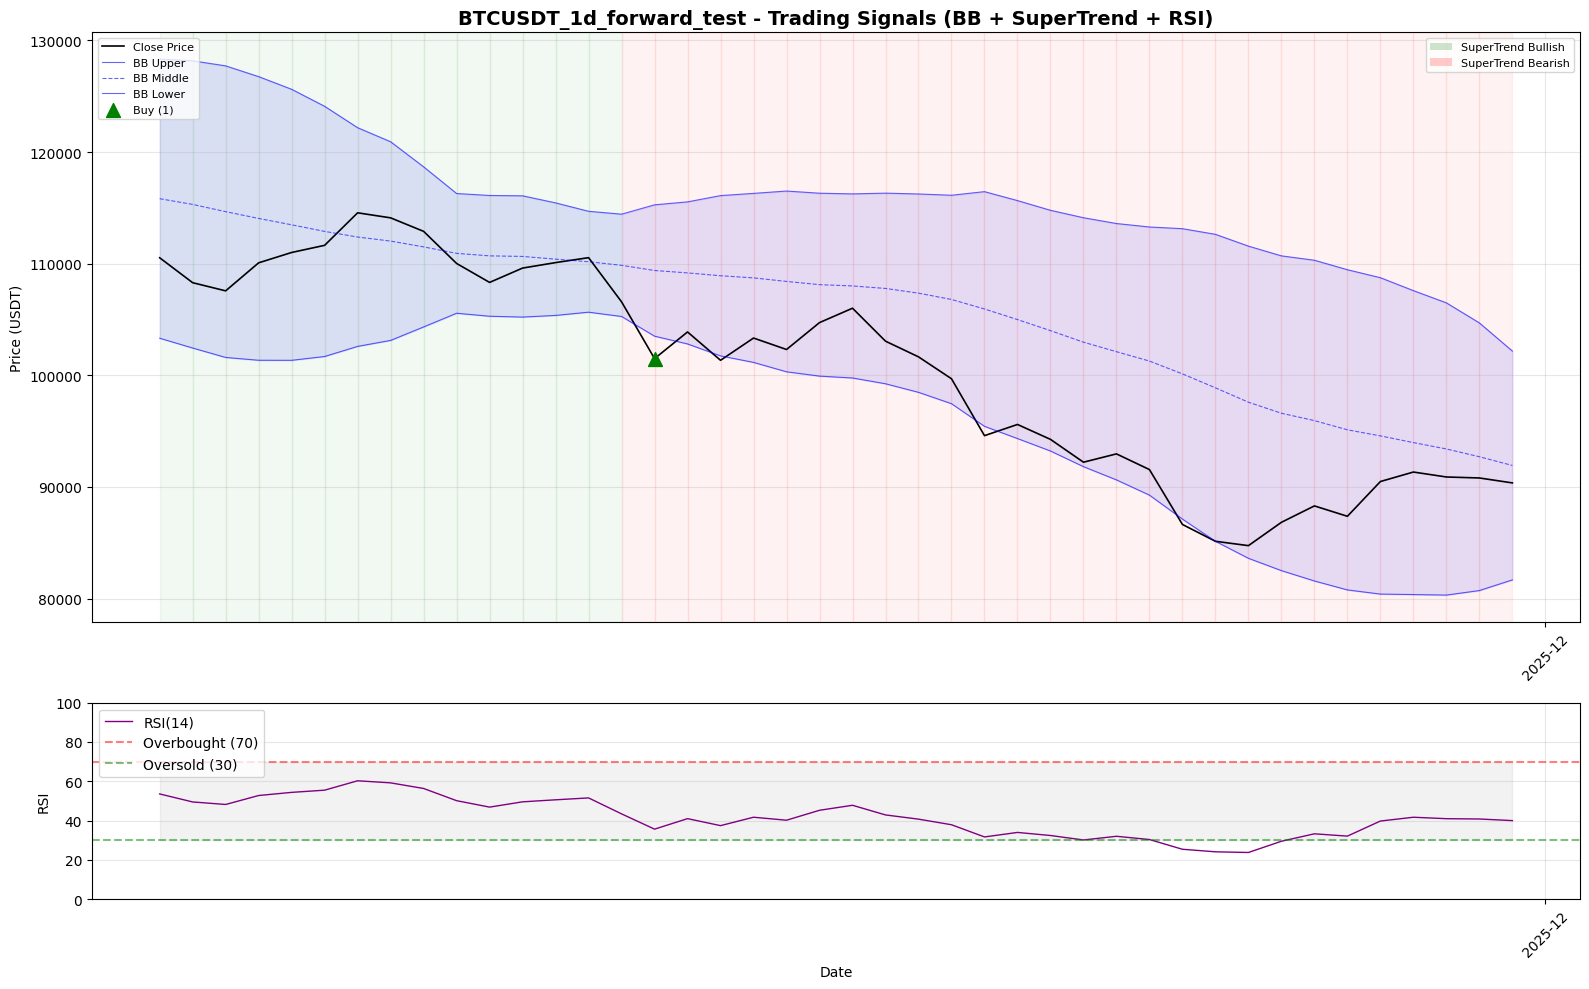

Chart saved as 'BTCUSDT_1d_forward_test_signals.png'
     ✅ Chart saved: BTCUSDT_1d_forward_test_signals.png

📊 FORWARD TEST: ETHUSDT_1d
  Dropped 19 rows due to indicator warmup period
  📅 Period: 2025-10-20 to 2025-11-30
  📊 Data points: 42

  📈 MARKET CONDITIONS:
     Condition: 🔴 VOLATILE
     Volatility: 3.3% daily
     Price Change: -24.83%
     Avg ADX: 25.12
     Bullish Ratio: 36.0%

  💰 PERFORMANCE:
     Total PnL: -7.79%
     Win Rate: 0.00%
     Trades: 1

  🏆 BEST TRADES:
     • Entry: 2025-11-04 00:00:00 @ $3287.05
       Exit:  2025-11-28 00:00:00 @ $3031.15
       PnL: -7.79% | Duration: 24 days

  📊 CONSISTENCY COMPARISON:
     Historical PnL: 429.94% | Forward PnL: -7.79%
     Difference: -437.73%
     Historical WR: 94.44% | Forward WR: 0.00%
     Status: ⚠️ INCONSISTENT
     💡 Note: High volatility caused more whipsaws

  🎨 Generating forward test chart...


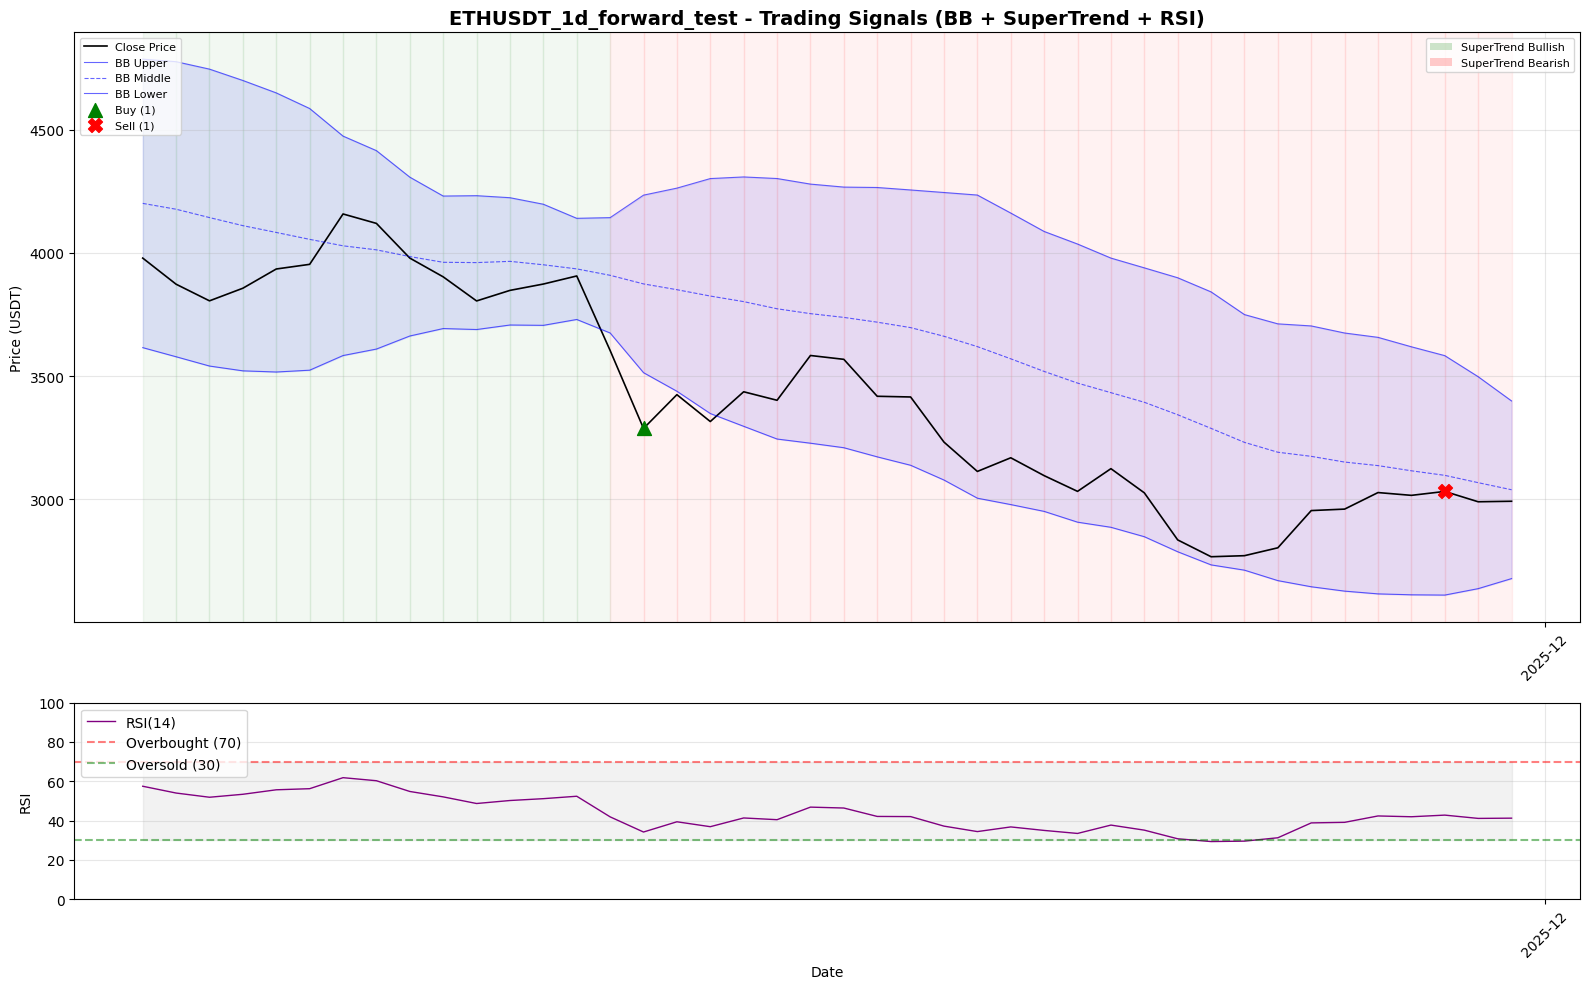

Chart saved as 'ETHUSDT_1d_forward_test_signals.png'
     ✅ Chart saved: ETHUSDT_1d_forward_test_signals.png

📊 FORWARD TEST: BTCUSDT_4h
  Dropped 199 rows due to indicator warmup period
  📅 Period: 2025-11-03 to 2025-11-30
  📊 Data points: 162

  📈 MARKET CONDITIONS:
     Condition: 🔻 TRENDING DOWN
     Volatility: 1.07% daily
     Price Change: -15.41%
     Avg ADX: 31.66
     Bullish Ratio: 22.0%

  💰 PERFORMANCE:
     Total PnL: -3.42%
     Win Rate: 25.00%
     Trades: 4

  🏆 BEST TRADES:
     • Entry: 2025-11-17 16:00:00 @ $91678.93
       Exit:  2025-11-20 04:00:00 @ $92320.18
       PnL: 0.70% | Duration: 2 days

     • Entry: 2025-11-20 20:00:00 @ $86637.23
       Exit:  2025-11-23 00:00:00 @ $86308.54
       PnL: -0.38% | Duration: 2 days

     • Entry: 2025-11-14 08:00:00 @ $96167.44
       Exit:  2025-11-17 04:00:00 @ $95653.77
       PnL: -0.53% | Duration: 2 days

  📊 CONSISTENCY COMPARISON:
     Historical PnL: 164.89% | Forward PnL: -3.42%
     Difference: -168.31%
    

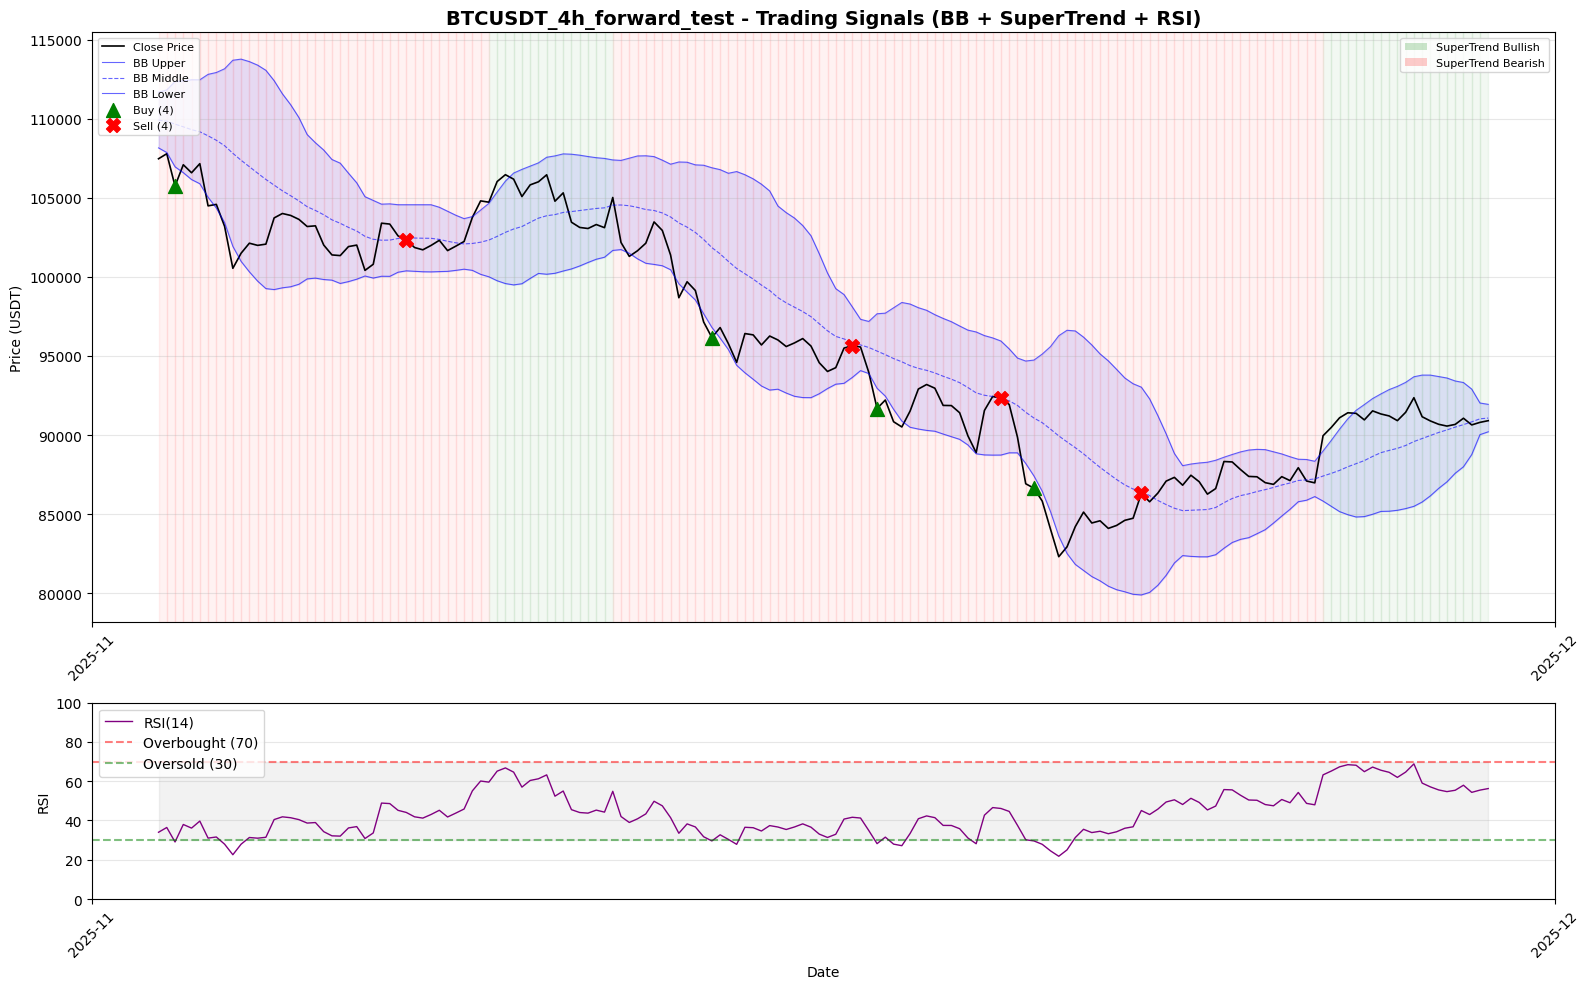

Chart saved as 'BTCUSDT_4h_forward_test_signals.png'
     ✅ Chart saved: BTCUSDT_4h_forward_test_signals.png

                                   📊 FORWARD TEST SUMMARY
 Symbol_TF   Strategy  Forward_PnL%  Forward_WinRate%  Forward_Trades Market_Condition  Volatility%  Price_Change%  Historical_PnL%  PnL_Difference     Consistency
BTCUSDT_1d TC1_RSI_BB        -10.97               0.0               1  🔻 TRENDING DOWN         2.16         -18.25           242.57         -253.54 ⚠️ INCONSISTENT
ETHUSDT_1d TC1_RSI_BB         -7.79               0.0               1       🔴 VOLATILE         3.30         -24.83           429.94         -437.73 ⚠️ INCONSISTENT
BTCUSDT_4h TC1_RSI_BB         -3.42              25.0               4  🔻 TRENDING DOWN         1.07         -15.41           164.89         -168.31 ⚠️ INCONSISTENT

✅ Enhanced results saved to 'forward_test_enhanced_results.csv'
✅ All trades saved to 'forward_test_all_trades.csv'

                                   🏆 TOP 5 BEST TRADES (Fo

In [42]:
# 🚀 RUN ENHANCED FORWARD TEST
if __name__ == "__main__":
    print("🎯 Running Enhanced Forward Test (Oct-Nov 2025)...")
    print("This will generate:")
    print("  ✅ Best trade examples")
    print("  ✅ Forward test charts with entry/exit markers")
    print("  ✅ Market conditions analysis (sideways/trending/volatile)")
    print("  ✅ Consistency comparison with Grid-Search period")
    print()
    
    enhanced_results = run_enhanced_forward_test()
